In [1]:
#######################################################################################
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn tqdm matplotlib --quiet
########################################################################################

!git clone https://github.com/HelenGuohx/logbert.git
%cd logbert


!ls


import sys
sys.path.append("/content/logbert")  # Add root folder to Python path


import torch
from bert_pytorch.model.log_model import BERTLog
from bert_pytorch.model.bert import BERT
import torch.nn as nn


vocab_size = 10000        # Total unique log keys in your dataset
max_len = 128             # Sequence length
hidden = 768              # Hidden size
n_layers = 12             # Transformer blocks
attn_heads = 12           # Attention heads
dropout = 0.3
is_logkey = True
is_time = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=is_logkey,
    is_time=is_time
).to(device)


class BERTLog(nn.Module):
    def __init__(self, bert, vocab_size):
        super().__init__()
        self.bert = bert
        self.logkey_predictor = nn.Linear(bert.hidden, vocab_size)
        if self.bert.is_time:
            self.time_predictor = nn.Linear(bert.hidden, bert.max_len) # Example output size, adjust as needed
        else:
            self.time_predictor = None

        # Add classification heads if they exist in your original model structure
        if hasattr(bert, 'cls_head'):
             self.cls_head = bert.cls_head
        if hasattr(bert, 'cls_fnn'):
            self.cls_fnn = bert.cls_fnn


    def forward(self, x, time_info=None):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        encoded_layers = self.bert(x, time_info, mask) # Original forward pass

        logkey_output = self.logkey_predictor(encoded_layers)
        time_output = None
        if self.time_predictor:
            time_output = self.time_predictor(encoded_layers)

        # Include classification head outputs if available
        cls_output = None
        if hasattr(self, 'cls_head'):
            cls_output = self.cls_head(encoded_layers[:, 0]) # Assuming CLS token at index 0

        cls_fnn_output = None
        if hasattr(self, 'cls_fnn'):
            cls_fnn_output = self.cls_fnn(encoded_layers[:, 0]) # Assuming CLS token at index 0


        return {'logkey_output': logkey_output,
                'time_output': time_output,
                'cls_output': cls_output,
                'cls_fnn_output': cls_fnn_output}

    def forward_from_embedding(self, x_emb, time_info=None):
        # Assume x_emb is already token embeddings [batch, seq_len, embedding_dim]
        # We need a dummy mask based on the original input shape
        # Since we don't have the original tokens, we'll create a mask assuming non-padding
        # This might need refinement based on how your model handles padding after embedding
        dummy_x = torch.ones(x_emb.shape[0], x_emb.shape[1], dtype=torch.long, device=x_emb.device) # Dummy input for mask
        mask = (dummy_x > 0).unsqueeze(1).repeat(1, dummy_x.size(1), 1).unsqueeze(1)


        # Pass embedding directly to BERT's core layers (after embedding and positional encoding)
        # This requires access to BERT's internal layers.
        # Need to replicate the steps in bert_pytorch.model.bert.BERT.forward() after embedding
        # This might be complex and require modifying the original BERT class as well.
        # For simplicity, let's assume the BERT model can take embeddings directly after positional encoding
        # *********** This part needs adjustment based on the actual BERT implementation *************
        # Assuming bert_model has a method or can be modified to accept pre-computed embeddings
        # For now, let's call the main forward and hope it handles pre-computed embeddings if possible
        # If not, the BERT class needs modification.

        # A more correct approach might be to access BERT's internal layers:
        # 1. Add positional encoding to x_emb
        # 2. Pass through transformer layers
        # This requires significant changes to the original BERT class.

        # As a temporary workaround (and if your BERT model allows),
        # let's try passing the embedding and time_info directly to the BERT model's forward.
        # This is unlikely to work without modifications to the BERT model itself.

        # A better approach is to re-implement the BERT forward pass after embedding
        # within this forward_from_embedding method.

        # Let's try accessing BERT's layers directly (requires knowledge of BERT internal structure)
        # This is highly dependent on the specific BERT implementation in bert_pytorch.model.bert
        # Assuming a standard BERT structure: Embedding + Positional Encoding -> Transformer Layers -> Pooler/Output

        # Need to access BERT's positional encoding and transformer layers
        # This requires inspecting the BERT class source code.

        # Let's assume a simplified structure for demonstration:
        # x_emb = x_emb + self.bert.position(dummy_x) # Add positional encoding (simplified)
        # encoded_layers = self.bert.transformer_layers(x_emb, mask) # Pass through transformers (simplified)

        # This requires modifying the BERT class to expose transformer layers or accept pre-encoded inputs.

        # Given the complexity of modifying the original BERT class,
        # let's revisit the strategy. Can we explain the model using token indices instead of embeddings?
        # The previous error suggested that float inputs were required for GradientExplainer.

        # Let's go back to explaining token indices, but ensure the model wrapper handles float inputs correctly
        # without converting them back to long immediately if the underlying model can handle float embeddings
        # or if we modify the model to take float indices and handle embedding lookup internally.

        # Let's revert to the previous SHAPWrapper that takes token indices and see if we can make it work with floats.
        # The issue was 'element 0 of tensors does not require grad and does not have a grad_fn'.
        # This means the input tensor itself (background_long_float / test_long_float) didn't have grad enabled.
        # When creating tensors for SHAP, they should have requires_grad=True.

        # Let's try enabling gradients on the input tensors in the SHAP computation cell.

        # Reverting this forward_from_embedding method as it requires significant changes to the BERT class.
        # We will go back to the SHAPWrapper that takes token indices.
        pass # Reverting this method

Cloning into 'logbert'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 133 (delta 12), reused 11 (delta 11), pack-reused 78 (from 1)
Receiving objects: 100% (133/133), 211.46 KiB | 4.60 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cpu


In [2]:
import pandas as pd

# Replace with your JSON path
test_path = "/content/test.json"

# Load JSON lines
test_df = pd.read_json(test_path, lines=True)
print(test_df.head())


   sequence_id label  error_anomaly  \
0       769477   [0]          False   
1       733393   [0]          False   
2       740405   [0]          False   
3       921915   [0]          False   
4         8298   [0]          False   

                                    numeric_sequence  \
0  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
1  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
2  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
3  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
4  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   

                                     mapped_sequence  \
0  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
1  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
2  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
3  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
4  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   

                                                logs  logbert_ready  \
0  [2024-05-26T00:00

In [3]:
# Keep sequences as a list (no need to convert to NumPy array)
test_samples = test_df['mapped_sequence'].tolist()[:50]

# Check length of first 5 sequences
for i, seq in enumerate(test_samples[:5]):
    print(f"Sample {i} length: {len(seq)}")


Sample 0 length: 1
Sample 1 length: 1
Sample 2 length: 1
Sample 3 length: 1
Sample 4 length: 1


In [4]:
import torch
import numpy as np

# Assuming you have your trained LogBERT model
# model = ... (your trained LogBERT)
# tokenizer = ... (if needed for mapping)

def logbert_predict(sequences):
    """
    sequences: list of numeric sequences (list of ints)
    returns: np.array of prediction probabilities
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for seq in sequences:
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([seq], dtype=torch.long)  # shape: [1, seq_len]

            # Get model prediction (adjust depending on your model's output)
            logits = model(input_tensor)  # shape: [1, num_classes]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            outputs.append(probs[0])

    return np.array(outputs)


Using device: cpu
Tokenizer loaded, vocab size: 18
Model loaded.
Loaded 2634 test samples.
Padded shape: (2634, 128)


Explaining samples: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]
/tmp/ipython-input-598975971.py:161: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_plot, features=features_for_plot, feature_names=feature_names, show=True)


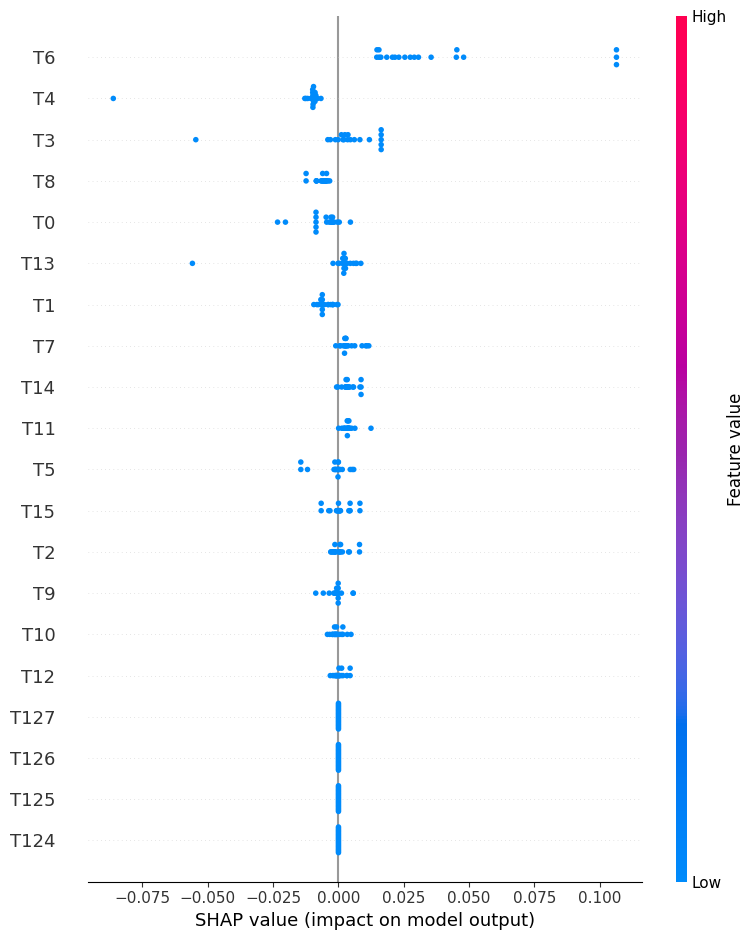

SHAP explanation completed on real test data.


In [5]:
# ==============================
# SHAP Explanations for Trained LogBERT
# ==============================
import os, json, numpy as np, torch, shap
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# -----------------------------
# 0️⃣ Paths & device
# -----------------------------
MODEL_PATH = "/content/01_model_final1.pt"
TOKENIZER_PATH = "/content/tokenizer.json"
TEST_JSONL = "/content/test.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1️⃣ Manual config
# -----------------------------
config = {
    "vocab_size": 18,
    "max_len": 128,
    "hidden": 32,
    "n_layers": 6,
    "attn_heads": 8,
    "dropout": 0.3,
    "batch_size": 16,
    "lr": 2e-05,
    "epochs": 6
}

max_len = config["max_len"]
vocab_size = config["vocab_size"]
hidden = config["hidden"]
n_layers = config["n_layers"]
attn_heads = config["attn_heads"]
dropout = config["dropout"]

# -----------------------------
# 2️⃣ Load tokenizer
# -----------------------------
with open(TOKENIZER_PATH, "r") as f:
    log2idx = json.load(f)
PAD_ID = log2idx.get("<PAD>", 0)
UNK_ID = log2idx.get("<UNK>", 1)
print(f"Tokenizer loaded, vocab size: {len(log2idx)}")

# -----------------------------
# 3️⃣ Load model
# -----------------------------
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog

bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=True,
    is_time=False
).to(device)

model = BERTLog(bert_model, vocab_size=vocab_size).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded.")

# -----------------------------
# 4️⃣ Prepare test sequences
# -----------------------------
test_samples_tokens = []
test_seqids = []

with open(TEST_JSONL, "r") as f:
    for line in f:
        item = json.loads(line)
        seq_tokens = item.get("mapped_sequence", None)
        if seq_tokens is None:
            seq_tokens = item.get("numeric_sequence", None)
        if isinstance(seq_tokens, list) and len(seq_tokens) > 0 and isinstance(seq_tokens[0], list):
            seq = seq_tokens[0]
        elif isinstance(seq_tokens, list):
            seq = seq_tokens
        else:
            seq = []
        test_samples_tokens.append(seq)
        test_seqids.append(item.get("sequence_id", None))

print(f"Loaded {len(test_samples_tokens)} test samples.")

# Tokenize sequences
def tokens_to_ids(seq, mapper=log2idx, unk_token="<UNK>"):
    unk_id = mapper.get(unk_token, 1)
    return [mapper.get(tok, unk_id) for tok in seq]

int_samples = [tokens_to_ids(seq) for seq in test_samples_tokens]

# Pad sequences
padded_samples = pad_sequences(int_samples, maxlen=max_len, padding="post", truncating="post", value=PAD_ID)
padded_samples = np.asarray(padded_samples, dtype=np.int32)
print("Padded shape:", padded_samples.shape)

# -----------------------------
# 5️⃣ SHAP wrapper for model
# -----------------------------
def model_numpy_wrapper(x_batch_np):
    model.eval()
    input_ids = torch.tensor(x_batch_np, dtype=torch.long, device=device)
    batch_size, seq_len = input_ids.shape
    time_info = torch.zeros(batch_size, seq_len, dtype=torch.float32, device=device)
    with torch.no_grad():
        outputs = model(input_ids, time_info)
        logits = outputs.get("logkey_output") if isinstance(outputs, dict) else outputs
        if logits.dim() == 3:
            # average token logits for SHAP
            mask = (input_ids != PAD_ID).unsqueeze(-1).float()
            masked_logits = logits * mask
            denom = mask.sum(dim=1).clamp(min=1.0)
            logits = masked_logits.sum(dim=1) / denom
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# -----------------------------
# 6️⃣ SHAP Explainer
# -----------------------------
masker = shap.maskers.Independent(data=np.zeros((1, max_len), dtype=np.int32), max_samples=20)
explainer = shap.Explainer(model_numpy_wrapper, masker=masker)

# -----------------------------
# 7️⃣ Explain real test samples
# -----------------------------
n_to_explain = min(20, padded_samples.shape[0])
x_test_subset = padded_samples[:n_to_explain]

all_shap_values = []
for i in tqdm(range(x_test_subset.shape[0]), desc="Explaining samples"):
    sample = x_test_subset[i:i+1]
    try:
        sv = explainer(sample, max_evals=50)
        all_shap_values.append(sv)
    except Exception as e:
        print(f"SHAP failed for sample {i} (seqid={test_seqids[i]}): {e}")

# Aggregate SHAP values
values_list = [sv.values for sv in all_shap_values]
shap_values_arr = np.concatenate(values_list, axis=0)
features_for_plot = x_test_subset[:shap_values_arr.shape[0]]
feature_names = [f"T{i}" for i in range(max_len)]

# -----------------------------
# 8️⃣ SHAP summary plot
# -----------------------------
if shap_values_arr.ndim == 3:
    probs_batch = model_numpy_wrapper(features_for_plot)
    pred_classes = np.argmax(probs_batch, axis=1)
    shap_for_plot = np.array([shap_values_arr[idx, :, pred_classes[idx]] for idx in range(shap_values_arr.shape[0])])
    shap.summary_plot(shap_for_plot, features=features_for_plot, feature_names=feature_names, show=True)
else:
    shap.summary_plot(shap_values_arr, features=features_for_plot, feature_names=feature_names, show=True)

print("SHAP explanation completed on real test data.")


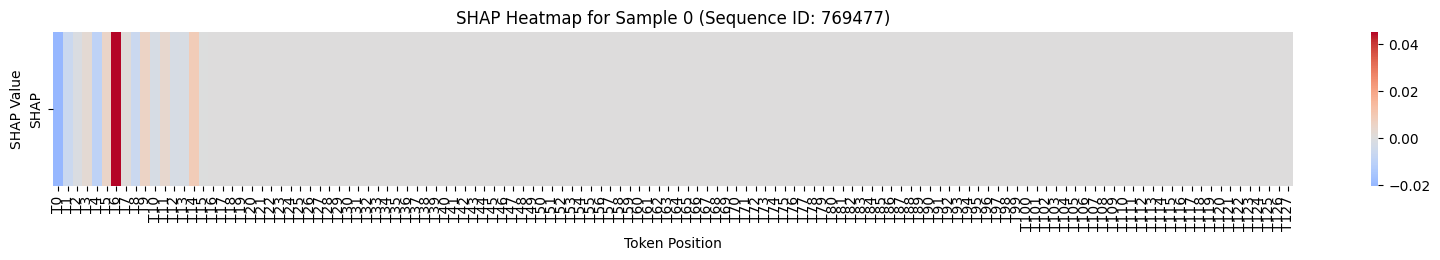

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1️⃣ Prepare SHAP values for heatmap
# -----------------------------
# For simplicity, let's use the first sample
sample_idx = 0
sample_seq = features_for_plot[sample_idx]

# If 3D (tokens x classes), pick predicted class
if shap_values_arr.ndim == 3:
    probs_batch = model_numpy_wrapper(sample_seq[np.newaxis, :])
    pred_class = np.argmax(probs_batch, axis=1)[0]
    shap_for_heatmap = shap_values_arr[sample_idx, :, pred_class]
else:
    shap_for_heatmap = shap_values_arr[sample_idx]

# -----------------------------
# 2️⃣ Token labels
# -----------------------------
token_labels = [f"T{i}" for i in range(len(sample_seq))]

# -----------------------------
# 3️⃣ Plot heatmap
# -----------------------------
plt.figure(figsize=(20, 2))
sns.heatmap([shap_for_heatmap], annot=False, cmap="coolwarm", center=0, xticklabels=token_labels, yticklabels=["SHAP"])
plt.title(f"SHAP Heatmap for Sample {sample_idx} (Sequence ID: {test_seqids[sample_idx]})")
plt.xlabel("Token Position")
plt.ylabel("SHAP Value")
plt.show()


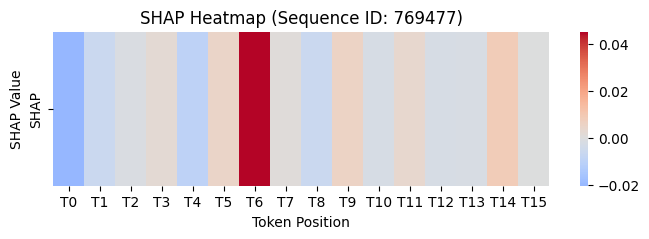

In [7]:
# Mask only real tokens
mask_real = sample_seq != PAD_ID
shap_for_heatmap_real = shap_for_heatmap[mask_real]
token_labels_real = [f"T{i}" for i, m in enumerate(mask_real) if m]

plt.figure(figsize=(len(token_labels_real)/2, 2))
sns.heatmap([shap_for_heatmap_real], annot=False, cmap="coolwarm", center=0,
            xticklabels=token_labels_real, yticklabels=["SHAP"])
plt.title(f"SHAP Heatmap (Sequence ID: {test_seqids[sample_idx]})")
plt.xlabel("Token Position")
plt.ylabel("SHAP Value")
plt.show()


#LLM


In [8]:
!pip install transformers accelerate --quiet


In [9]:
'''from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
model_name = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
text_gen = pipeline("text-generation", model=model, tokenizer=tokenizer)


SyntaxError: incomplete input (ipython-input-3143213791.py, line 1)

In [10]:
# -----------------------------
# Memory-efficient LLM setup
# -----------------------------
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Use smaller model for Colab memory
llm_model_name = "bigscience/bloom-560m"  # <2GB VRAM
tokenizer_llm = AutoTokenizer.from_pretrained(llm_model_name)
model_llm = AutoModelForCausalLM.from_pretrained(llm_model_name, device_map="auto")
text_gen = pipeline("text-generation", model=model_llm, tokenizer=tokenizer_llm)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Device set to use cpu


In [17]:
# ==============================
# LLM-based anomaly detection & human-readable output (with file saving)
# ==============================

import numpy as np
from tqdm import tqdm

output_file = "/content/01_together_llm_anomaly_results.txt"

# Token ID → token name
idx2log = {v: k for k, v in log2idx.items()}

ANOMALY_THRESHOLD = 0.02
MIN_ANOMALOUS_TOKENS = 1

TOKEN_EXPLANATIONS = {
    "UNK_0": "represents an uncommon IP or token pattern not seen in normal sequences",
    "UNK_1": "appears in traffic patterns linked to unusual external behavior",
    "UNK_2": "maps to a protocol or state transition that rarely occurs in benign logs",
    "START": "appears in an unexpected structure compared to normal log sequences",
    "PARAM": "indicates abnormal request parameters often used in probing attempts",
    "OPEN": "matches automated tool request headers rather than legitimate users",
    "CLOSE": "appears in malformed request structures",
    "UNK_7": "deviates from normal byte or payload size distributions",
    "UNK_8": "encodes metadata outside the normal operational range",
    "SEP": "appears in an unexpected position indicating automated log generation",
    "UNK_10": "maps to an internal user-agent token not seen in legitimate clients",
    "INFO": "represents metadata inconsistent with standard event patterns",
    "UNK_12": "corresponds to SQLMap, an automated SQL-injection scanning tool",
    "GENERIC_EVENT": "indicates an abnormal event type for this protocol or action",
    "UNK_14": "represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch)",
    "UNK_15": "shows threat indicators appearing in contradictory or irregular patterns",
}

def build_llm_explanation(anomalous_tokens):
    lines = []
    lines.append("Anomalous due to unusual tokens detected.")
    for token, _ in anomalous_tokens:
        reason = TOKEN_EXPLANATIONS.get(
            token,
            "appears rarely in normal logs and deviates from benign behavior"
        )
        #lines.append(f"\"- Token: "{token}\" - {reason}.")
        lines.append(f'- Token: "{token}" - {reason}.')

    return "\n".join(lines)  # ✅ NO extra gaps

with open(output_file, "w") as f_out:
    for i in tqdm(range(len(padded_samples)), desc="LLM anomaly detection"):

        sample = padded_samples[i:i+1]

        try:
            shap_vals = explainer(sample, max_evals=50).values[0]
        except Exception as e:
            print(f"SHAP failed for sequence {test_seqids[i]}: {e}")
            continue

        probs = model_numpy_wrapper(sample)
        pred_class = np.argmax(probs, axis=1)[0]

        top_indices = np.argsort(-np.abs(shap_vals[:, pred_class]))[:5]
        top_tokens = []

        for pos in top_indices:
            token_id = int(sample[0, pos])
            token_name = idx2log.get(token_id, "unexpected log entry")
            score = float(shap_vals[pos, pred_class])
            top_tokens.append((token_name, score))

        anomalous_tokens = [
            (t, round(v, 4))
            for t, v in top_tokens
            if abs(v) >= ANOMALY_THRESHOLD
        ]

        label = "Anomalous" if len(anomalous_tokens) >= MIN_ANOMALOUS_TOKENS else "Normal"

        # ======================
        # PRINT
        # ======================
        print(f"\n--- Sequence {test_seqids[i]} ---")
        print(label)

        if label == "Anomalous":
            print(f"Top anomalous tokens: {anomalous_tokens}\n")
            print("LLM Explanation:")
            print(build_llm_explanation(anomalous_tokens))
            print("\n\n")  # ✅ spacing AFTER explanation block only
        else:
            print("")

        # ======================
        # SAVE TO FILE
        # ======================
        f_out.write(f"\n--- Sequence {test_seqids[i]} ---\n")
        f_out.write(label + "\n")

        if label == "Anomalous":
            f_out.write(f"Top anomalous tokens: {anomalous_tokens}\n\n")
            f_out.write("LLM Explanation:\n")
            f_out.write(build_llm_explanation(anomalous_tokens))
            f_out.write("\n\n")
        else:
            f_out.write("\n")

print(f"✅ Finished. Results saved to {output_file}")


LLM anomaly detection:   0%|          | 1/2634 [00:00<13:34,  3.23it/s]


--- Sequence 769477 ---
Normal



LLM anomaly detection:   0%|          | 2/2634 [00:00<13:05,  3.35it/s]


--- Sequence 733393 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   0%|          | 3/2634 [00:00<12:18,  3.56it/s]


--- Sequence 740405 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   0%|          | 4/2634 [00:01<12:09,  3.60it/s]


--- Sequence 921915 ---
Normal



LLM anomaly detection:   0%|          | 5/2634 [00:01<12:18,  3.56it/s]


--- Sequence 8298 ---
Normal



LLM anomaly detection:   0%|          | 6/2634 [00:01<12:22,  3.54it/s]


--- Sequence 86731 ---
Normal



LLM anomaly detection:   0%|          | 7/2634 [00:01<12:08,  3.61it/s]


--- Sequence 71214 ---
Normal



LLM anomaly detection:   0%|          | 8/2634 [00:02<12:07,  3.61it/s]


--- Sequence 732939 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   0%|          | 9/2634 [00:02<11:55,  3.67it/s]


--- Sequence 54432 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   0%|          | 10/2634 [00:02<11:53,  3.68it/s]


--- Sequence 889918 ---
Normal



LLM anomaly detection:   0%|          | 11/2634 [00:03<11:46,  3.71it/s]


--- Sequence 888836 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   0%|          | 12/2634 [00:03<11:54,  3.67it/s]


--- Sequence 112814 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   0%|          | 13/2634 [00:03<11:54,  3.67it/s]


--- Sequence 870880 ---
Normal



LLM anomaly detection:   1%|          | 14/2634 [00:03<11:51,  3.68it/s]


--- Sequence 819580 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|          | 15/2634 [00:04<11:47,  3.70it/s]


--- Sequence 13477 ---
Normal



LLM anomaly detection:   1%|          | 16/2634 [00:04<11:42,  3.73it/s]


--- Sequence 103359 ---
Normal



LLM anomaly detection:   1%|          | 17/2634 [00:04<11:36,  3.76it/s]


--- Sequence 38631 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|          | 18/2634 [00:04<12:05,  3.61it/s]


--- Sequence 928013 ---
Normal



LLM anomaly detection:   1%|          | 19/2634 [00:05<13:16,  3.28it/s]


--- Sequence 99103 ---
Normal



LLM anomaly detection:   1%|          | 20/2634 [00:05<14:07,  3.09it/s]


--- Sequence 803705 ---
Normal



LLM anomaly detection:   1%|          | 21/2634 [00:06<14:45,  2.95it/s]


--- Sequence 107266 ---
Normal



LLM anomaly detection:   1%|          | 22/2634 [00:06<15:09,  2.87it/s]


--- Sequence 72903 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|          | 23/2634 [00:06<15:27,  2.81it/s]


--- Sequence 103785 ---
Normal



LLM anomaly detection:   1%|          | 24/2634 [00:07<15:52,  2.74it/s]


--- Sequence 719324 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0274)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|          | 25/2634 [00:07<16:09,  2.69it/s]


--- Sequence 726425 ---
Normal



LLM anomaly detection:   1%|          | 26/2634 [00:07<16:07,  2.69it/s]


--- Sequence 20273 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|          | 27/2634 [00:08<14:54,  2.91it/s]


--- Sequence 858829 ---
Normal



LLM anomaly detection:   1%|          | 28/2634 [00:08<14:03,  3.09it/s]


--- Sequence 795575 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('OPEN', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:   1%|          | 29/2634 [00:08<13:30,  3.21it/s]


--- Sequence 838182 ---
Normal



LLM anomaly detection:   1%|          | 30/2634 [00:09<13:22,  3.25it/s]


--- Sequence 4515 ---
Normal



LLM anomaly detection:   1%|          | 31/2634 [00:09<13:12,  3.28it/s]


--- Sequence 827204 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:   1%|          | 32/2634 [00:09<12:57,  3.35it/s]


--- Sequence 731225 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('PARAM', -0.0286)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   1%|▏         | 33/2634 [00:09<12:48,  3.39it/s]


--- Sequence 942197 ---
Normal



LLM anomaly detection:   1%|▏         | 34/2634 [00:10<12:46,  3.39it/s]


--- Sequence 848853 ---
Normal



LLM anomaly detection:   1%|▏         | 35/2634 [00:10<12:24,  3.49it/s]


--- Sequence 755903 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0224)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|▏         | 36/2634 [00:10<12:24,  3.49it/s]


--- Sequence 817329 ---
Normal



LLM anomaly detection:   1%|▏         | 37/2634 [00:11<12:29,  3.46it/s]


--- Sequence 855832 ---
Normal



LLM anomaly detection:   1%|▏         | 38/2634 [00:11<12:26,  3.48it/s]


--- Sequence 80519 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0297)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   1%|▏         | 39/2634 [00:11<12:21,  3.50it/s]


--- Sequence 52867 ---
Normal



LLM anomaly detection:   2%|▏         | 40/2634 [00:11<12:31,  3.45it/s]


--- Sequence 887309 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:   2%|▏         | 41/2634 [00:12<12:40,  3.41it/s]


--- Sequence 911856 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   2%|▏         | 42/2634 [00:12<12:34,  3.43it/s]


--- Sequence 855128 ---
Normal



LLM anomaly detection:   2%|▏         | 43/2634 [00:12<12:16,  3.52it/s]


--- Sequence 922501 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:   2%|▏         | 44/2634 [00:13<12:03,  3.58it/s]


--- Sequence 818924 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   2%|▏         | 45/2634 [00:13<11:59,  3.60it/s]


--- Sequence 39762 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:   2%|▏         | 46/2634 [00:13<11:51,  3.64it/s]


--- Sequence 836628 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   2%|▏         | 47/2634 [00:13<11:49,  3.65it/s]


--- Sequence 805960 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354), ('UNK_0', -0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   2%|▏         | 48/2634 [00:14<11:54,  3.62it/s]


--- Sequence 849091 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   2%|▏         | 49/2634 [00:14<11:46,  3.66it/s]


--- Sequence 748218 ---
Normal



LLM anomaly detection:   2%|▏         | 50/2634 [00:14<11:45,  3.66it/s]


--- Sequence 76885 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   2%|▏         | 51/2634 [00:14<11:37,  3.70it/s]


--- Sequence 940585 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('PARAM', -0.0343)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   2%|▏         | 52/2634 [00:15<11:33,  3.72it/s]


--- Sequence 87916 ---
Normal



LLM anomaly detection:   2%|▏         | 53/2634 [00:15<11:29,  3.74it/s]


--- Sequence 749968 ---
Normal



LLM anomaly detection:   2%|▏         | 54/2634 [00:15<11:27,  3.75it/s]


--- Sequence 23086 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   2%|▏         | 55/2634 [00:16<11:26,  3.76it/s]


--- Sequence 774161 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.02)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   2%|▏         | 56/2634 [00:16<11:34,  3.71it/s]


--- Sequence 77068 ---
Normal



LLM anomaly detection:   2%|▏         | 57/2634 [00:16<11:35,  3.71it/s]


--- Sequence 836213 ---
Normal



LLM anomaly detection:   2%|▏         | 58/2634 [00:16<11:43,  3.66it/s]


--- Sequence 925830 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:   2%|▏         | 59/2634 [00:17<11:39,  3.68it/s]


--- Sequence 30104 ---
Normal



LLM anomaly detection:   2%|▏         | 60/2634 [00:17<11:39,  3.68it/s]


--- Sequence 62393 ---
Normal



LLM anomaly detection:   2%|▏         | 61/2634 [00:17<11:31,  3.72it/s]


--- Sequence 791209 ---
Normal



LLM anomaly detection:   2%|▏         | 62/2634 [00:18<12:08,  3.53it/s]


--- Sequence 11308 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0274)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   2%|▏         | 63/2634 [00:18<13:30,  3.17it/s]


--- Sequence 814260 ---
Normal



LLM anomaly detection:   2%|▏         | 64/2634 [00:18<14:07,  3.03it/s]


--- Sequence 921927 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0313)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   2%|▏         | 65/2634 [00:19<14:29,  2.95it/s]


--- Sequence 720824 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0302)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 66/2634 [00:19<14:57,  2.86it/s]


--- Sequence 1076108 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 67/2634 [00:19<15:25,  2.77it/s]


--- Sequence 789511 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('OPEN', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:   3%|▎         | 68/2634 [00:20<15:35,  2.74it/s]


--- Sequence 53498 ---
Normal



LLM anomaly detection:   3%|▎         | 69/2634 [00:20<15:57,  2.68it/s]


--- Sequence 826812 ---
Normal



LLM anomaly detection:   3%|▎         | 70/2634 [00:21<15:43,  2.72it/s]


--- Sequence 812295 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 71/2634 [00:21<14:30,  2.95it/s]


--- Sequence 94758 ---
Normal



LLM anomaly detection:   3%|▎         | 72/2634 [00:21<13:33,  3.15it/s]


--- Sequence 849957 ---
Normal



LLM anomaly detection:   3%|▎         | 73/2634 [00:21<13:10,  3.24it/s]


--- Sequence 65488 ---
Normal



LLM anomaly detection:   3%|▎         | 74/2634 [00:22<12:39,  3.37it/s]


--- Sequence 25883 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:   3%|▎         | 75/2634 [00:22<12:28,  3.42it/s]


--- Sequence 72076 ---
Normal



LLM anomaly detection:   3%|▎         | 76/2634 [00:22<12:16,  3.47it/s]


--- Sequence 889037 ---
Normal



LLM anomaly detection:   3%|▎         | 77/2634 [00:22<12:12,  3.49it/s]


--- Sequence 863334 ---
Normal



LLM anomaly detection:   3%|▎         | 78/2634 [00:23<12:08,  3.51it/s]


--- Sequence 942028 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:   3%|▎         | 79/2634 [00:23<12:09,  3.50it/s]


--- Sequence 831339 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 80/2634 [00:23<12:10,  3.50it/s]


--- Sequence 28879 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0269)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 81/2634 [00:24<11:54,  3.57it/s]


--- Sequence 1079585 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 82/2634 [00:24<11:44,  3.62it/s]


--- Sequence 815257 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668), ('PARAM', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   3%|▎         | 83/2634 [00:24<11:41,  3.63it/s]


--- Sequence 789502 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:   3%|▎         | 84/2634 [00:24<11:46,  3.61it/s]


--- Sequence 89281 ---
Normal



LLM anomaly detection:   3%|▎         | 85/2634 [00:25<11:44,  3.62it/s]


--- Sequence 871351 ---
Normal



LLM anomaly detection:   3%|▎         | 86/2634 [00:25<11:41,  3.63it/s]


--- Sequence 937508 ---
Normal



LLM anomaly detection:   3%|▎         | 87/2634 [00:25<11:35,  3.66it/s]


--- Sequence 741244 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_8', -0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:   3%|▎         | 88/2634 [00:25<11:46,  3.60it/s]


--- Sequence 902066 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:   3%|▎         | 89/2634 [00:26<11:43,  3.62it/s]


--- Sequence 858064 ---
Normal



LLM anomaly detection:   3%|▎         | 90/2634 [00:26<11:34,  3.66it/s]


--- Sequence 828642 ---
Normal



LLM anomaly detection:   3%|▎         | 91/2634 [00:26<11:34,  3.66it/s]


--- Sequence 27990 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   3%|▎         | 92/2634 [00:27<11:45,  3.60it/s]


--- Sequence 46498 ---
Normal



LLM anomaly detection:   4%|▎         | 93/2634 [00:27<11:37,  3.64it/s]


--- Sequence 737329 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('UNK_0', -0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   4%|▎         | 94/2634 [00:27<11:38,  3.64it/s]


--- Sequence 940915 ---
Normal



LLM anomaly detection:   4%|▎         | 95/2634 [00:27<11:58,  3.54it/s]


--- Sequence 48394 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:   4%|▎         | 96/2634 [00:28<11:48,  3.58it/s]


--- Sequence 910010 ---
Normal



LLM anomaly detection:   4%|▎         | 97/2634 [00:28<11:46,  3.59it/s]


--- Sequence 933296 ---
Normal



LLM anomaly detection:   4%|▎         | 98/2634 [00:28<11:43,  3.61it/s]


--- Sequence 841050 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:   4%|▍         | 99/2634 [00:29<11:42,  3.61it/s]


--- Sequence 819328 ---
Normal



LLM anomaly detection:   4%|▍         | 100/2634 [00:29<11:33,  3.65it/s]


--- Sequence 888687 ---
Normal



LLM anomaly detection:   4%|▍         | 101/2634 [00:29<11:32,  3.66it/s]


--- Sequence 816108 ---
Normal



LLM anomaly detection:   4%|▍         | 102/2634 [00:29<11:34,  3.64it/s]


--- Sequence 742369 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 103/2634 [00:30<11:30,  3.67it/s]


--- Sequence 716191 ---
Normal



LLM anomaly detection:   4%|▍         | 104/2634 [00:30<11:20,  3.72it/s]


--- Sequence 118199 ---
Normal



LLM anomaly detection:   4%|▍         | 105/2634 [00:30<11:18,  3.73it/s]


--- Sequence 915170 ---
Normal



LLM anomaly detection:   4%|▍         | 106/2634 [00:30<11:14,  3.75it/s]


--- Sequence 757184 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 107/2634 [00:31<12:34,  3.35it/s]


--- Sequence 81236 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 108/2634 [00:31<13:28,  3.12it/s]


--- Sequence 839356 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 109/2634 [00:32<14:01,  3.00it/s]


--- Sequence 58434 ---
Normal



LLM anomaly detection:   4%|▍         | 110/2634 [00:32<14:26,  2.91it/s]


--- Sequence 12201 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   4%|▍         | 111/2634 [00:32<14:47,  2.84it/s]


--- Sequence 945217 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:   4%|▍         | 112/2634 [00:33<15:12,  2.77it/s]


--- Sequence 929395 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 113/2634 [00:33<15:35,  2.70it/s]


--- Sequence 830393 ---
Normal



LLM anomaly detection:   4%|▍         | 114/2634 [00:33<15:53,  2.64it/s]


--- Sequence 1074720 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 115/2634 [00:34<14:51,  2.83it/s]


--- Sequence 849568 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   4%|▍         | 116/2634 [00:34<13:57,  3.01it/s]


--- Sequence 852609 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   4%|▍         | 117/2634 [00:34<13:07,  3.20it/s]


--- Sequence 875489 ---
Normal



LLM anomaly detection:   4%|▍         | 118/2634 [00:35<12:30,  3.35it/s]


--- Sequence 779494 ---
Normal



LLM anomaly detection:   5%|▍         | 119/2634 [00:35<12:10,  3.44it/s]


--- Sequence 39955 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▍         | 120/2634 [00:35<11:53,  3.53it/s]


--- Sequence 14361 ---
Normal



LLM anomaly detection:   5%|▍         | 121/2634 [00:35<11:41,  3.58it/s]


--- Sequence 764421 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   5%|▍         | 122/2634 [00:36<11:37,  3.60it/s]


--- Sequence 11296 ---
Normal



LLM anomaly detection:   5%|▍         | 123/2634 [00:36<11:36,  3.61it/s]


--- Sequence 854443 ---
Normal



LLM anomaly detection:   5%|▍         | 124/2634 [00:36<11:26,  3.66it/s]


--- Sequence 904561 ---
Normal



LLM anomaly detection:   5%|▍         | 125/2634 [00:36<11:27,  3.65it/s]


--- Sequence 923553 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0285)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▍         | 126/2634 [00:37<11:19,  3.69it/s]


--- Sequence 773668 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253), ('PARAM', -0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   5%|▍         | 127/2634 [00:37<11:22,  3.67it/s]


--- Sequence 15343 ---
Normal



LLM anomaly detection:   5%|▍         | 128/2634 [00:37<11:19,  3.69it/s]


--- Sequence 828769 ---
Normal



LLM anomaly detection:   5%|▍         | 129/2634 [00:38<11:18,  3.69it/s]


--- Sequence 839226 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▍         | 130/2634 [00:38<11:12,  3.72it/s]


--- Sequence 70577 ---
Normal



LLM anomaly detection:   5%|▍         | 131/2634 [00:38<11:20,  3.68it/s]


--- Sequence 90042 ---
Normal



LLM anomaly detection:   5%|▌         | 132/2634 [00:38<11:31,  3.62it/s]


--- Sequence 72319 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 133/2634 [00:39<11:22,  3.67it/s]


--- Sequence 929904 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 134/2634 [00:39<11:13,  3.71it/s]


--- Sequence 746890 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 135/2634 [00:39<11:27,  3.64it/s]


--- Sequence 815643 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 136/2634 [00:39<11:20,  3.67it/s]


--- Sequence 736806 ---
Normal



LLM anomaly detection:   5%|▌         | 137/2634 [00:40<11:15,  3.70it/s]


--- Sequence 1071280 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 138/2634 [00:40<11:16,  3.69it/s]


--- Sequence 837270 ---
Normal



LLM anomaly detection:   5%|▌         | 139/2634 [00:40<11:20,  3.67it/s]


--- Sequence 896297 ---
Normal



LLM anomaly detection:   5%|▌         | 140/2634 [00:41<11:15,  3.69it/s]


--- Sequence 724797 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 141/2634 [00:41<11:06,  3.74it/s]


--- Sequence 925787 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 142/2634 [00:41<11:18,  3.67it/s]


--- Sequence 58416 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0269)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 143/2634 [00:41<11:22,  3.65it/s]


--- Sequence 741379 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   5%|▌         | 144/2634 [00:42<11:16,  3.68it/s]


--- Sequence 763344 ---
Normal



LLM anomaly detection:   6%|▌         | 145/2634 [00:42<11:12,  3.70it/s]


--- Sequence 88675 ---
Normal



LLM anomaly detection:   6%|▌         | 146/2634 [00:42<11:23,  3.64it/s]


--- Sequence 103780 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0307)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▌         | 147/2634 [00:42<11:16,  3.67it/s]


--- Sequence 888336 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▌         | 148/2634 [00:43<11:19,  3.66it/s]


--- Sequence 776423 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('UNK_0', -0.0233)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   6%|▌         | 149/2634 [00:43<11:12,  3.69it/s]


--- Sequence 853724 ---
Normal



LLM anomaly detection:   6%|▌         | 150/2634 [00:43<11:18,  3.66it/s]


--- Sequence 58582 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   6%|▌         | 151/2634 [00:43<11:13,  3.69it/s]


--- Sequence 116258 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0259)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▌         | 152/2634 [00:44<12:40,  3.26it/s]


--- Sequence 883034 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:   6%|▌         | 153/2634 [00:44<13:31,  3.06it/s]


--- Sequence 757099 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▌         | 154/2634 [00:45<14:00,  2.95it/s]


--- Sequence 110749 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559), ('UNK_8', -0.0236)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:   6%|▌         | 155/2634 [00:45<14:20,  2.88it/s]


--- Sequence 877406 ---
Normal



LLM anomaly detection:   6%|▌         | 156/2634 [00:45<14:51,  2.78it/s]


--- Sequence 835953 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▌         | 157/2634 [00:46<14:57,  2.76it/s]


--- Sequence 902740 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:   6%|▌         | 158/2634 [00:46<15:02,  2.74it/s]


--- Sequence 906798 ---
Normal



LLM anomaly detection:   6%|▌         | 159/2634 [00:47<15:25,  2.68it/s]


--- Sequence 77586 ---
Normal



LLM anomaly detection:   6%|▌         | 160/2634 [00:47<14:04,  2.93it/s]


--- Sequence 886855 ---
Normal



LLM anomaly detection:   6%|▌         | 161/2634 [00:47<13:03,  3.15it/s]


--- Sequence 853865 ---
Normal



LLM anomaly detection:   6%|▌         | 162/2634 [00:47<12:26,  3.31it/s]


--- Sequence 918283 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▌         | 163/2634 [00:48<12:08,  3.39it/s]


--- Sequence 1072282 ---
Normal



LLM anomaly detection:   6%|▌         | 164/2634 [00:48<11:44,  3.51it/s]


--- Sequence 76485 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▋         | 165/2634 [00:48<11:26,  3.59it/s]


--- Sequence 939376 ---
Normal



LLM anomaly detection:   6%|▋         | 166/2634 [00:48<11:19,  3.63it/s]


--- Sequence 733427 ---
Normal



LLM anomaly detection:   6%|▋         | 167/2634 [00:49<11:22,  3.62it/s]


--- Sequence 111767 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0294)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▋         | 168/2634 [00:49<11:10,  3.68it/s]


--- Sequence 53914 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▋         | 169/2634 [00:49<11:08,  3.69it/s]


--- Sequence 802625 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0279)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   6%|▋         | 170/2634 [00:49<11:03,  3.72it/s]


--- Sequence 739703 ---
Normal



LLM anomaly detection:   6%|▋         | 171/2634 [00:50<11:04,  3.71it/s]


--- Sequence 883682 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 172/2634 [00:50<11:02,  3.71it/s]


--- Sequence 929539 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 173/2634 [00:50<11:02,  3.72it/s]


--- Sequence 6511 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 174/2634 [00:51<11:04,  3.70it/s]


--- Sequence 747773 ---
Normal



LLM anomaly detection:   7%|▋         | 175/2634 [00:51<11:10,  3.67it/s]


--- Sequence 68581 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:   7%|▋         | 176/2634 [00:51<11:06,  3.69it/s]


--- Sequence 32375 ---
Normal



LLM anomaly detection:   7%|▋         | 177/2634 [00:51<11:10,  3.66it/s]


--- Sequence 818698 ---
Normal



LLM anomaly detection:   7%|▋         | 178/2634 [00:52<11:02,  3.70it/s]


--- Sequence 846524 ---
Normal



LLM anomaly detection:   7%|▋         | 179/2634 [00:52<11:08,  3.67it/s]


--- Sequence 10315 ---
Normal



LLM anomaly detection:   7%|▋         | 180/2634 [00:52<11:06,  3.68it/s]


--- Sequence 883548 ---
Normal



LLM anomaly detection:   7%|▋         | 181/2634 [00:52<11:05,  3.69it/s]


--- Sequence 61023 ---
Normal



LLM anomaly detection:   7%|▋         | 182/2634 [00:53<11:08,  3.67it/s]


--- Sequence 47307 ---
Normal



LLM anomaly detection:   7%|▋         | 183/2634 [00:53<11:01,  3.71it/s]


--- Sequence 112051 ---
Normal



LLM anomaly detection:   7%|▋         | 184/2634 [00:53<11:02,  3.70it/s]


--- Sequence 796523 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 185/2634 [00:54<10:58,  3.72it/s]


--- Sequence 867174 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 186/2634 [00:54<11:00,  3.71it/s]


--- Sequence 852488 ---
Normal



LLM anomaly detection:   7%|▋         | 187/2634 [00:54<10:56,  3.73it/s]


--- Sequence 766489 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 188/2634 [00:54<11:00,  3.70it/s]


--- Sequence 71682 ---
Normal



LLM anomaly detection:   7%|▋         | 189/2634 [00:55<10:55,  3.73it/s]


--- Sequence 804133 ---
Normal



LLM anomaly detection:   7%|▋         | 190/2634 [00:55<11:04,  3.68it/s]


--- Sequence 66140 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 191/2634 [00:55<11:03,  3.68it/s]


--- Sequence 1075963 ---
Normal



LLM anomaly detection:   7%|▋         | 192/2634 [00:55<11:06,  3.66it/s]


--- Sequence 9210 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   7%|▋         | 193/2634 [00:56<11:48,  3.45it/s]


--- Sequence 69316 ---
Normal



LLM anomaly detection:   7%|▋         | 194/2634 [00:56<12:48,  3.17it/s]


--- Sequence 898750 ---
Normal



LLM anomaly detection:   7%|▋         | 195/2634 [00:56<13:34,  2.99it/s]


--- Sequence 109835 ---
Normal



LLM anomaly detection:   7%|▋         | 196/2634 [00:57<14:32,  2.79it/s]


--- Sequence 733218 ---
Normal



LLM anomaly detection:   7%|▋         | 197/2634 [00:57<15:26,  2.63it/s]


--- Sequence 73861 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 198/2634 [00:58<15:45,  2.58it/s]


--- Sequence 830712 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 199/2634 [00:58<16:35,  2.45it/s]


--- Sequence 761633 ---
Normal



LLM anomaly detection:   8%|▊         | 200/2634 [00:59<16:30,  2.46it/s]


--- Sequence 61662 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 201/2634 [00:59<16:11,  2.50it/s]


--- Sequence 1078287 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('PARAM', -0.0343)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   8%|▊         | 202/2634 [00:59<16:40,  2.43it/s]


--- Sequence 831284 ---
Normal



LLM anomaly detection:   8%|▊         | 203/2634 [01:00<17:06,  2.37it/s]


--- Sequence 730793 ---
Normal



LLM anomaly detection:   8%|▊         | 204/2634 [01:00<17:19,  2.34it/s]


--- Sequence 5543 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 205/2634 [01:01<17:00,  2.38it/s]


--- Sequence 752214 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 206/2634 [01:01<16:29,  2.45it/s]


--- Sequence 815148 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 207/2634 [01:01<15:27,  2.62it/s]


--- Sequence 902710 ---
Normal



LLM anomaly detection:   8%|▊         | 208/2634 [01:02<14:02,  2.88it/s]


--- Sequence 868781 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 209/2634 [01:02<13:03,  3.10it/s]


--- Sequence 855258 ---
Normal



LLM anomaly detection:   8%|▊         | 210/2634 [01:02<12:19,  3.28it/s]


--- Sequence 927504 ---
Normal



LLM anomaly detection:   8%|▊         | 211/2634 [01:02<12:03,  3.35it/s]


--- Sequence 745800 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:   8%|▊         | 212/2634 [01:03<11:37,  3.47it/s]


--- Sequence 754490 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 213/2634 [01:03<11:27,  3.52it/s]


--- Sequence 758186 ---
Normal



LLM anomaly detection:   8%|▊         | 214/2634 [01:03<11:11,  3.60it/s]


--- Sequence 863348 ---
Normal



LLM anomaly detection:   8%|▊         | 215/2634 [01:04<11:09,  3.61it/s]


--- Sequence 720070 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 216/2634 [01:04<11:01,  3.66it/s]


--- Sequence 913055 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 217/2634 [01:04<10:56,  3.68it/s]


--- Sequence 942460 ---
Normal



LLM anomaly detection:   8%|▊         | 218/2634 [01:04<11:03,  3.64it/s]


--- Sequence 74663 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0248)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 219/2634 [01:05<11:06,  3.62it/s]


--- Sequence 68315 ---
Normal



LLM anomaly detection:   8%|▊         | 220/2634 [01:05<10:54,  3.69it/s]


--- Sequence 917488 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0285)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 221/2634 [01:05<10:52,  3.70it/s]


--- Sequence 5988 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0206)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   8%|▊         | 222/2634 [01:05<10:54,  3.68it/s]


--- Sequence 839688 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598), ('PARAM', -0.0311)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   8%|▊         | 223/2634 [01:06<11:11,  3.59it/s]


--- Sequence 764368 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   9%|▊         | 224/2634 [01:06<11:13,  3.58it/s]


--- Sequence 97353 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:   9%|▊         | 225/2634 [01:06<11:13,  3.58it/s]


--- Sequence 114822 ---
Normal



LLM anomaly detection:   9%|▊         | 226/2634 [01:07<11:05,  3.62it/s]


--- Sequence 53581 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_0', -0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   9%|▊         | 227/2634 [01:07<11:01,  3.64it/s]


--- Sequence 892667 ---
Normal



LLM anomaly detection:   9%|▊         | 228/2634 [01:07<11:00,  3.64it/s]


--- Sequence 751053 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   9%|▊         | 229/2634 [01:07<11:04,  3.62it/s]


--- Sequence 71891 ---
Normal



LLM anomaly detection:   9%|▊         | 230/2634 [01:08<11:06,  3.61it/s]


--- Sequence 753260 ---
Normal



LLM anomaly detection:   9%|▉         | 231/2634 [01:08<10:55,  3.67it/s]


--- Sequence 934147 ---
Normal



LLM anomaly detection:   9%|▉         | 232/2634 [01:08<10:47,  3.71it/s]


--- Sequence 869515 ---
Normal



LLM anomaly detection:   9%|▉         | 233/2634 [01:09<10:51,  3.69it/s]


--- Sequence 745212 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:   9%|▉         | 234/2634 [01:09<10:56,  3.66it/s]


--- Sequence 815987 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   9%|▉         | 235/2634 [01:09<10:53,  3.67it/s]


--- Sequence 865183 ---
Normal



LLM anomaly detection:   9%|▉         | 236/2634 [01:09<10:55,  3.66it/s]


--- Sequence 785752 ---
Normal



LLM anomaly detection:   9%|▉         | 237/2634 [01:10<10:57,  3.64it/s]


--- Sequence 873668 ---
Normal



LLM anomaly detection:   9%|▉         | 238/2634 [01:10<11:05,  3.60it/s]


--- Sequence 758066 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.031)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   9%|▉         | 239/2634 [01:10<10:54,  3.66it/s]


--- Sequence 874371 ---
Normal



LLM anomaly detection:   9%|▉         | 240/2634 [01:10<10:47,  3.70it/s]


--- Sequence 867177 ---
Normal



LLM anomaly detection:   9%|▉         | 241/2634 [01:11<10:43,  3.72it/s]


--- Sequence 814582 ---
Normal



LLM anomaly detection:   9%|▉         | 242/2634 [01:11<10:43,  3.72it/s]


--- Sequence 889494 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:   9%|▉         | 243/2634 [01:11<11:00,  3.62it/s]


--- Sequence 47526 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('UNK_0', -0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:   9%|▉         | 244/2634 [01:12<12:29,  3.19it/s]


--- Sequence 790246 ---
Normal



LLM anomaly detection:   9%|▉         | 245/2634 [01:12<13:19,  2.99it/s]


--- Sequence 58260 ---
Normal



LLM anomaly detection:   9%|▉         | 246/2634 [01:12<13:46,  2.89it/s]


--- Sequence 714692 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('PARAM', -0.0234)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:   9%|▉         | 247/2634 [01:13<14:00,  2.84it/s]


--- Sequence 112856 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:   9%|▉         | 248/2634 [01:13<14:15,  2.79it/s]


--- Sequence 813537 ---
Normal



LLM anomaly detection:   9%|▉         | 249/2634 [01:14<14:28,  2.75it/s]


--- Sequence 899111 ---
Normal



LLM anomaly detection:   9%|▉         | 250/2634 [01:14<14:35,  2.72it/s]


--- Sequence 883434 ---
Normal



LLM anomaly detection:  10%|▉         | 251/2634 [01:14<14:37,  2.72it/s]


--- Sequence 814653 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|▉         | 252/2634 [01:15<13:22,  2.97it/s]


--- Sequence 908669 ---
Normal



LLM anomaly detection:  10%|▉         | 253/2634 [01:15<12:29,  3.18it/s]


--- Sequence 875512 ---
Normal



LLM anomaly detection:  10%|▉         | 254/2634 [01:15<11:52,  3.34it/s]


--- Sequence 84781 ---
Normal



LLM anomaly detection:  10%|▉         | 255/2634 [01:15<11:34,  3.43it/s]


--- Sequence 755494 ---
Normal



LLM anomaly detection:  10%|▉         | 256/2634 [01:16<11:16,  3.52it/s]


--- Sequence 815013 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  10%|▉         | 257/2634 [01:16<10:57,  3.62it/s]


--- Sequence 753895 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|▉         | 258/2634 [01:16<10:47,  3.67it/s]


--- Sequence 759007 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|▉         | 259/2634 [01:16<10:51,  3.65it/s]


--- Sequence 113833 ---
Normal



LLM anomaly detection:  10%|▉         | 260/2634 [01:17<10:43,  3.69it/s]


--- Sequence 921099 ---
Normal



LLM anomaly detection:  10%|▉         | 261/2634 [01:17<10:42,  3.69it/s]


--- Sequence 769160 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|▉         | 262/2634 [01:17<10:36,  3.73it/s]


--- Sequence 759741 ---
Normal



LLM anomaly detection:  10%|▉         | 263/2634 [01:17<10:47,  3.66it/s]


--- Sequence 934035 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|█         | 264/2634 [01:18<10:42,  3.69it/s]


--- Sequence 50435 ---
Normal



LLM anomaly detection:  10%|█         | 265/2634 [01:18<10:34,  3.74it/s]


--- Sequence 805388 ---
Normal



LLM anomaly detection:  10%|█         | 266/2634 [01:18<10:34,  3.73it/s]


--- Sequence 53832 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|█         | 267/2634 [01:19<10:35,  3.72it/s]


--- Sequence 722782 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|█         | 268/2634 [01:19<10:32,  3.74it/s]


--- Sequence 25523 ---
Normal



LLM anomaly detection:  10%|█         | 269/2634 [01:19<10:30,  3.75it/s]


--- Sequence 804245 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  10%|█         | 270/2634 [01:19<10:38,  3.70it/s]


--- Sequence 764786 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|█         | 271/2634 [01:20<10:52,  3.62it/s]


--- Sequence 71086 ---
Normal



LLM anomaly detection:  10%|█         | 272/2634 [01:20<10:41,  3.68it/s]


--- Sequence 908436 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  10%|█         | 273/2634 [01:20<10:37,  3.70it/s]


--- Sequence 853951 ---
Normal



LLM anomaly detection:  10%|█         | 274/2634 [01:20<10:46,  3.65it/s]


--- Sequence 16662 ---
Normal



LLM anomaly detection:  10%|█         | 275/2634 [01:21<10:46,  3.65it/s]


--- Sequence 859358 ---
Normal



LLM anomaly detection:  10%|█         | 276/2634 [01:21<10:37,  3.70it/s]


--- Sequence 715733 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█         | 277/2634 [01:21<10:33,  3.72it/s]


--- Sequence 101754 ---
Normal



LLM anomaly detection:  11%|█         | 278/2634 [01:22<10:37,  3.69it/s]


--- Sequence 760291 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█         | 279/2634 [01:22<10:31,  3.73it/s]


--- Sequence 843653 ---
Normal



LLM anomaly detection:  11%|█         | 280/2634 [01:22<10:27,  3.75it/s]


--- Sequence 764690 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  11%|█         | 281/2634 [01:22<10:29,  3.74it/s]


--- Sequence 728529 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  11%|█         | 282/2634 [01:23<10:39,  3.68it/s]


--- Sequence 899606 ---
Normal



LLM anomaly detection:  11%|█         | 283/2634 [01:23<10:39,  3.67it/s]


--- Sequence 79188 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█         | 284/2634 [01:23<10:34,  3.70it/s]


--- Sequence 25462 ---
Normal



LLM anomaly detection:  11%|█         | 285/2634 [01:23<10:36,  3.69it/s]


--- Sequence 115251 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█         | 286/2634 [01:24<10:47,  3.62it/s]


--- Sequence 847660 ---
Normal



LLM anomaly detection:  11%|█         | 287/2634 [01:24<10:38,  3.68it/s]


--- Sequence 867632 ---
Normal



LLM anomaly detection:  11%|█         | 288/2634 [01:24<10:47,  3.62it/s]


--- Sequence 840056 ---
Normal



LLM anomaly detection:  11%|█         | 289/2634 [01:25<12:09,  3.22it/s]


--- Sequence 819553 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█         | 290/2634 [01:25<12:46,  3.06it/s]


--- Sequence 111903 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.029)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█         | 291/2634 [01:25<13:08,  2.97it/s]


--- Sequence 19090 ---
Normal



LLM anomaly detection:  11%|█         | 292/2634 [01:26<13:35,  2.87it/s]


--- Sequence 67443 ---
Normal



LLM anomaly detection:  11%|█         | 293/2634 [01:26<13:50,  2.82it/s]


--- Sequence 920353 ---
Normal



LLM anomaly detection:  11%|█         | 294/2634 [01:26<14:03,  2.77it/s]


--- Sequence 809306 ---
Normal



LLM anomaly detection:  11%|█         | 295/2634 [01:27<14:21,  2.72it/s]


--- Sequence 840930 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  11%|█         | 296/2634 [01:27<14:18,  2.72it/s]


--- Sequence 865684 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█▏        | 297/2634 [01:28<13:15,  2.94it/s]


--- Sequence 77619 ---
Normal



LLM anomaly detection:  11%|█▏        | 298/2634 [01:28<12:43,  3.06it/s]


--- Sequence 911144 ---
Normal



LLM anomaly detection:  11%|█▏        | 299/2634 [01:28<12:02,  3.23it/s]


--- Sequence 95361 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  11%|█▏        | 300/2634 [01:28<11:29,  3.39it/s]


--- Sequence 440 ---
Normal



LLM anomaly detection:  11%|█▏        | 301/2634 [01:29<11:12,  3.47it/s]


--- Sequence 87748 ---
Normal



LLM anomaly detection:  11%|█▏        | 302/2634 [01:29<11:04,  3.51it/s]


--- Sequence 804092 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  12%|█▏        | 303/2634 [01:29<10:56,  3.55it/s]


--- Sequence 26917 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  12%|█▏        | 304/2634 [01:29<10:46,  3.60it/s]


--- Sequence 805441 ---
Normal



LLM anomaly detection:  12%|█▏        | 305/2634 [01:30<10:39,  3.64it/s]


--- Sequence 913712 ---
Normal



LLM anomaly detection:  12%|█▏        | 306/2634 [01:30<10:43,  3.62it/s]


--- Sequence 761878 ---
Normal



LLM anomaly detection:  12%|█▏        | 307/2634 [01:30<10:38,  3.64it/s]


--- Sequence 1079800 ---
Normal



LLM anomaly detection:  12%|█▏        | 308/2634 [01:31<10:37,  3.65it/s]


--- Sequence 746624 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  12%|█▏        | 309/2634 [01:31<10:31,  3.68it/s]


--- Sequence 793655 ---
Normal



LLM anomaly detection:  12%|█▏        | 310/2634 [01:31<10:33,  3.67it/s]


--- Sequence 83170 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  12%|█▏        | 311/2634 [01:31<10:53,  3.55it/s]


--- Sequence 791967 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  12%|█▏        | 312/2634 [01:32<10:57,  3.53it/s]


--- Sequence 929595 ---
Normal



LLM anomaly detection:  12%|█▏        | 313/2634 [01:32<10:52,  3.55it/s]


--- Sequence 82417 ---
Normal



LLM anomaly detection:  12%|█▏        | 314/2634 [01:32<10:47,  3.58it/s]


--- Sequence 777921 ---
Normal



LLM anomaly detection:  12%|█▏        | 315/2634 [01:32<10:45,  3.59it/s]


--- Sequence 769826 ---
Normal



LLM anomaly detection:  12%|█▏        | 316/2634 [01:33<10:39,  3.63it/s]


--- Sequence 740358 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  12%|█▏        | 317/2634 [01:33<10:38,  3.63it/s]


--- Sequence 93573 ---
Normal



LLM anomaly detection:  12%|█▏        | 318/2634 [01:33<10:31,  3.67it/s]


--- Sequence 719604 ---
Normal



LLM anomaly detection:  12%|█▏        | 319/2634 [01:34<10:24,  3.71it/s]


--- Sequence 802426 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0231)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  12%|█▏        | 320/2634 [01:34<10:22,  3.72it/s]


--- Sequence 84047 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  12%|█▏        | 321/2634 [01:34<10:29,  3.67it/s]


--- Sequence 104739 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0273)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  12%|█▏        | 322/2634 [01:34<10:25,  3.70it/s]


--- Sequence 97007 ---
Normal



LLM anomaly detection:  12%|█▏        | 323/2634 [01:35<10:26,  3.69it/s]


--- Sequence 1073254 ---
Normal



LLM anomaly detection:  12%|█▏        | 324/2634 [01:35<10:38,  3.62it/s]


--- Sequence 102764 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  12%|█▏        | 325/2634 [01:35<10:39,  3.61it/s]


--- Sequence 873778 ---
Normal



LLM anomaly detection:  12%|█▏        | 326/2634 [01:35<10:31,  3.66it/s]


--- Sequence 720874 ---
Normal



LLM anomaly detection:  12%|█▏        | 327/2634 [01:36<10:23,  3.70it/s]


--- Sequence 1071668 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  12%|█▏        | 328/2634 [01:36<10:30,  3.66it/s]


--- Sequence 889455 ---
Normal



LLM anomaly detection:  12%|█▏        | 329/2634 [01:36<10:28,  3.67it/s]


--- Sequence 777024 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  13%|█▎        | 330/2634 [01:37<10:26,  3.68it/s]


--- Sequence 943103 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 331/2634 [01:37<10:24,  3.69it/s]


--- Sequence 915896 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 332/2634 [01:37<10:26,  3.68it/s]


--- Sequence 11003 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 333/2634 [01:37<11:11,  3.43it/s]


--- Sequence 740849 ---
Normal



LLM anomaly detection:  13%|█▎        | 334/2634 [01:38<12:06,  3.17it/s]


--- Sequence 934081 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 335/2634 [01:38<12:54,  2.97it/s]


--- Sequence 879143 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 336/2634 [01:39<13:09,  2.91it/s]


--- Sequence 882886 ---
Normal



LLM anomaly detection:  13%|█▎        | 337/2634 [01:39<13:21,  2.87it/s]


--- Sequence 1072400 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 338/2634 [01:39<13:44,  2.79it/s]


--- Sequence 732244 ---
Normal



LLM anomaly detection:  13%|█▎        | 339/2634 [01:40<13:59,  2.73it/s]


--- Sequence 883965 ---
Normal



LLM anomaly detection:  13%|█▎        | 340/2634 [01:40<14:24,  2.65it/s]


--- Sequence 809942 ---
Normal



LLM anomaly detection:  13%|█▎        | 341/2634 [01:40<13:45,  2.78it/s]


--- Sequence 117580 ---
Normal



LLM anomaly detection:  13%|█▎        | 342/2634 [01:41<12:44,  3.00it/s]


--- Sequence 721072 ---
Normal



LLM anomaly detection:  13%|█▎        | 343/2634 [01:41<12:02,  3.17it/s]


--- Sequence 739811 ---
Normal



LLM anomaly detection:  13%|█▎        | 344/2634 [01:41<11:30,  3.32it/s]


--- Sequence 755342 ---
Normal



LLM anomaly detection:  13%|█▎        | 345/2634 [01:41<11:18,  3.37it/s]


--- Sequence 15239 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.02)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 346/2634 [01:42<11:02,  3.45it/s]


--- Sequence 941117 ---
Normal



LLM anomaly detection:  13%|█▎        | 347/2634 [01:42<10:52,  3.50it/s]


--- Sequence 816090 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354), ('PARAM', -0.0312)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  13%|█▎        | 348/2634 [01:42<10:51,  3.51it/s]


--- Sequence 69314 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 349/2634 [01:43<10:57,  3.48it/s]


--- Sequence 889768 ---
Normal



LLM anomaly detection:  13%|█▎        | 350/2634 [01:43<10:49,  3.52it/s]


--- Sequence 795060 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0278)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  13%|█▎        | 351/2634 [01:43<10:40,  3.57it/s]


--- Sequence 818428 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  13%|█▎        | 352/2634 [01:43<10:39,  3.57it/s]


--- Sequence 846879 ---
Normal



LLM anomaly detection:  13%|█▎        | 353/2634 [01:44<10:31,  3.61it/s]


--- Sequence 722546 ---
Normal



LLM anomaly detection:  13%|█▎        | 354/2634 [01:44<10:20,  3.67it/s]


--- Sequence 879406 ---
Normal



LLM anomaly detection:  13%|█▎        | 355/2634 [01:44<10:15,  3.70it/s]


--- Sequence 783708 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▎        | 356/2634 [01:45<10:33,  3.59it/s]


--- Sequence 728063 ---
Normal



LLM anomaly detection:  14%|█▎        | 357/2634 [01:45<10:32,  3.60it/s]


--- Sequence 68720 ---
Normal



LLM anomaly detection:  14%|█▎        | 358/2634 [01:45<10:27,  3.63it/s]


--- Sequence 855634 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▎        | 359/2634 [01:45<10:24,  3.64it/s]


--- Sequence 29486 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▎        | 360/2634 [01:46<10:31,  3.60it/s]


--- Sequence 839902 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▎        | 361/2634 [01:46<10:25,  3.63it/s]


--- Sequence 96619 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▎        | 362/2634 [01:46<10:27,  3.62it/s]


--- Sequence 11067 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  14%|█▍        | 363/2634 [01:46<10:23,  3.64it/s]


--- Sequence 66798 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  14%|█▍        | 364/2634 [01:47<10:28,  3.61it/s]


--- Sequence 931696 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 365/2634 [01:47<10:31,  3.59it/s]


--- Sequence 786012 ---
Normal



LLM anomaly detection:  14%|█▍        | 366/2634 [01:47<10:41,  3.53it/s]


--- Sequence 904041 ---
Normal



LLM anomaly detection:  14%|█▍        | 367/2634 [01:48<10:47,  3.50it/s]


--- Sequence 715350 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 368/2634 [01:48<10:36,  3.56it/s]


--- Sequence 60839 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0207)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 369/2634 [01:48<10:33,  3.57it/s]


--- Sequence 872871 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 370/2634 [01:48<10:27,  3.61it/s]


--- Sequence 756718 ---
Normal



LLM anomaly detection:  14%|█▍        | 371/2634 [01:49<10:27,  3.60it/s]


--- Sequence 1080337 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 372/2634 [01:49<10:29,  3.59it/s]


--- Sequence 57598 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 373/2634 [01:49<10:28,  3.60it/s]


--- Sequence 823829 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  14%|█▍        | 374/2634 [01:50<10:23,  3.62it/s]


--- Sequence 785104 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0332)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 375/2634 [01:50<10:32,  3.57it/s]


--- Sequence 69799 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 376/2634 [01:50<10:23,  3.62it/s]


--- Sequence 887229 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 377/2634 [01:50<11:32,  3.26it/s]


--- Sequence 897443 ---
Normal



LLM anomaly detection:  14%|█▍        | 378/2634 [01:51<12:18,  3.05it/s]


--- Sequence 838655 ---
Normal



LLM anomaly detection:  14%|█▍        | 379/2634 [01:51<12:50,  2.93it/s]


--- Sequence 818909 ---
Normal



LLM anomaly detection:  14%|█▍        | 380/2634 [01:52<13:19,  2.82it/s]


--- Sequence 912150 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0212)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  14%|█▍        | 381/2634 [01:52<13:38,  2.75it/s]


--- Sequence 26716 ---
Normal



LLM anomaly detection:  15%|█▍        | 382/2634 [01:52<13:53,  2.70it/s]


--- Sequence 5103 ---
Normal



LLM anomaly detection:  15%|█▍        | 383/2634 [01:53<14:06,  2.66it/s]


--- Sequence 814310 ---
Normal



LLM anomaly detection:  15%|█▍        | 384/2634 [01:53<14:24,  2.60it/s]


--- Sequence 842242 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▍        | 385/2634 [01:54<13:43,  2.73it/s]


--- Sequence 715991 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449), ('PARAM', -0.028)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  15%|█▍        | 386/2634 [01:54<12:52,  2.91it/s]


--- Sequence 47582 ---
Normal



LLM anomaly detection:  15%|█▍        | 387/2634 [01:54<12:14,  3.06it/s]


--- Sequence 821981 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0351)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  15%|█▍        | 388/2634 [01:54<11:45,  3.18it/s]


--- Sequence 790266 ---
Normal



LLM anomaly detection:  15%|█▍        | 389/2634 [01:55<11:20,  3.30it/s]


--- Sequence 743495 ---
Normal



LLM anomaly detection:  15%|█▍        | 390/2634 [01:55<11:03,  3.38it/s]


--- Sequence 57697 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0332)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▍        | 391/2634 [01:55<11:07,  3.36it/s]


--- Sequence 886950 ---
Normal



LLM anomaly detection:  15%|█▍        | 392/2634 [01:56<11:00,  3.40it/s]


--- Sequence 108826 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▍        | 393/2634 [01:56<10:55,  3.42it/s]


--- Sequence 808083 ---
Normal



LLM anomaly detection:  15%|█▍        | 394/2634 [01:56<10:54,  3.42it/s]


--- Sequence 35775 ---
Normal



LLM anomaly detection:  15%|█▍        | 395/2634 [01:56<10:54,  3.42it/s]


--- Sequence 107779 ---
Normal



LLM anomaly detection:  15%|█▌        | 396/2634 [01:57<10:55,  3.42it/s]


--- Sequence 741177 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  15%|█▌        | 397/2634 [01:57<10:48,  3.45it/s]


--- Sequence 845553 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('OPEN', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  15%|█▌        | 398/2634 [01:57<10:52,  3.43it/s]


--- Sequence 32374 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▌        | 399/2634 [01:58<10:47,  3.45it/s]


--- Sequence 941359 ---
Normal



LLM anomaly detection:  15%|█▌        | 400/2634 [01:58<10:38,  3.50it/s]


--- Sequence 774981 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0245)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▌        | 401/2634 [01:58<10:46,  3.45it/s]


--- Sequence 45408 ---
Normal



LLM anomaly detection:  15%|█▌        | 402/2634 [01:58<10:54,  3.41it/s]


--- Sequence 820729 ---
Normal



LLM anomaly detection:  15%|█▌        | 403/2634 [01:59<10:56,  3.40it/s]


--- Sequence 10015 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▌        | 404/2634 [01:59<10:55,  3.40it/s]


--- Sequence 104562 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  15%|█▌        | 405/2634 [01:59<10:50,  3.43it/s]


--- Sequence 44200 ---
Normal



LLM anomaly detection:  15%|█▌        | 406/2634 [02:00<10:43,  3.46it/s]


--- Sequence 780846 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451), ('PARAM', -0.0232)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  15%|█▌        | 407/2634 [02:00<10:32,  3.52it/s]


--- Sequence 826247 ---
Normal



LLM anomaly detection:  15%|█▌        | 408/2634 [02:00<10:32,  3.52it/s]


--- Sequence 774122 ---
Normal



LLM anomaly detection:  16%|█▌        | 409/2634 [02:00<10:40,  3.47it/s]


--- Sequence 107874 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▌        | 410/2634 [02:01<10:35,  3.50it/s]


--- Sequence 773045 ---
Normal



LLM anomaly detection:  16%|█▌        | 411/2634 [02:01<10:49,  3.42it/s]


--- Sequence 785023 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▌        | 412/2634 [02:01<10:46,  3.44it/s]


--- Sequence 919587 ---
Normal



LLM anomaly detection:  16%|█▌        | 413/2634 [02:02<11:00,  3.36it/s]


--- Sequence 934513 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('UNK_1', -0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  16%|█▌        | 414/2634 [02:02<10:39,  3.47it/s]


--- Sequence 825170 ---
Normal



LLM anomaly detection:  16%|█▌        | 415/2634 [02:02<10:28,  3.53it/s]


--- Sequence 115515 ---
Normal



LLM anomaly detection:  16%|█▌        | 416/2634 [02:02<10:26,  3.54it/s]


--- Sequence 831816 ---
Normal



LLM anomaly detection:  16%|█▌        | 417/2634 [02:03<10:17,  3.59it/s]


--- Sequence 754841 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  16%|█▌        | 418/2634 [02:03<10:12,  3.62it/s]


--- Sequence 728519 ---
Normal



LLM anomaly detection:  16%|█▌        | 419/2634 [02:03<10:04,  3.66it/s]


--- Sequence 56042 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  16%|█▌        | 420/2634 [02:04<11:01,  3.35it/s]


--- Sequence 733351 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▌        | 421/2634 [02:04<11:56,  3.09it/s]


--- Sequence 856396 ---
Normal



LLM anomaly detection:  16%|█▌        | 422/2634 [02:04<12:23,  2.98it/s]


--- Sequence 803354 ---
Normal



LLM anomaly detection:  16%|█▌        | 423/2634 [02:05<12:52,  2.86it/s]


--- Sequence 89125 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▌        | 424/2634 [02:05<13:07,  2.81it/s]


--- Sequence 943353 ---
Normal



LLM anomaly detection:  16%|█▌        | 425/2634 [02:05<13:24,  2.75it/s]


--- Sequence 876716 ---
Normal



LLM anomaly detection:  16%|█▌        | 426/2634 [02:06<13:42,  2.68it/s]


--- Sequence 41849 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0245)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▌        | 427/2634 [02:06<14:14,  2.58it/s]


--- Sequence 909486 ---
Normal



LLM anomaly detection:  16%|█▌        | 428/2634 [02:07<13:30,  2.72it/s]


--- Sequence 907283 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  16%|█▋        | 429/2634 [02:07<12:41,  2.90it/s]


--- Sequence 5811 ---
Normal



LLM anomaly detection:  16%|█▋        | 430/2634 [02:07<11:57,  3.07it/s]


--- Sequence 69572 ---
Normal



LLM anomaly detection:  16%|█▋        | 431/2634 [02:07<11:28,  3.20it/s]


--- Sequence 784553 ---
Normal



LLM anomaly detection:  16%|█▋        | 432/2634 [02:08<11:11,  3.28it/s]


--- Sequence 755867 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▋        | 433/2634 [02:08<10:50,  3.38it/s]


--- Sequence 801004 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0275)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  16%|█▋        | 434/2634 [02:08<10:32,  3.48it/s]


--- Sequence 30056 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0278)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 435/2634 [02:09<10:22,  3.53it/s]


--- Sequence 10577 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 436/2634 [02:09<10:22,  3.53it/s]


--- Sequence 714260 ---
Normal



LLM anomaly detection:  17%|█▋        | 437/2634 [02:09<10:17,  3.56it/s]


--- Sequence 85142 ---
Normal



LLM anomaly detection:  17%|█▋        | 438/2634 [02:09<10:22,  3.53it/s]


--- Sequence 63369 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  17%|█▋        | 439/2634 [02:10<10:09,  3.60it/s]


--- Sequence 713955 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 440/2634 [02:10<10:08,  3.61it/s]


--- Sequence 98876 ---
Normal



LLM anomaly detection:  17%|█▋        | 441/2634 [02:10<10:02,  3.64it/s]


--- Sequence 830759 ---
Normal



LLM anomaly detection:  17%|█▋        | 442/2634 [02:11<09:56,  3.67it/s]


--- Sequence 115590 ---
Normal



LLM anomaly detection:  17%|█▋        | 443/2634 [02:11<09:53,  3.69it/s]


--- Sequence 817105 ---
Normal



LLM anomaly detection:  17%|█▋        | 444/2634 [02:11<09:57,  3.67it/s]


--- Sequence 856805 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0266)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 445/2634 [02:11<09:56,  3.67it/s]


--- Sequence 53436 ---
Normal



LLM anomaly detection:  17%|█▋        | 446/2634 [02:12<09:54,  3.68it/s]


--- Sequence 900825 ---
Normal



LLM anomaly detection:  17%|█▋        | 447/2634 [02:12<09:44,  3.74it/s]


--- Sequence 50930 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  17%|█▋        | 448/2634 [02:12<09:55,  3.67it/s]


--- Sequence 797924 ---
Normal



LLM anomaly detection:  17%|█▋        | 449/2634 [02:12<09:50,  3.70it/s]


--- Sequence 880180 ---
Normal



LLM anomaly detection:  17%|█▋        | 450/2634 [02:13<09:47,  3.71it/s]


--- Sequence 32405 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 451/2634 [02:13<10:05,  3.60it/s]


--- Sequence 78829 ---
Normal



LLM anomaly detection:  17%|█▋        | 452/2634 [02:13<10:01,  3.63it/s]


--- Sequence 72713 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 453/2634 [02:13<09:57,  3.65it/s]


--- Sequence 1080970 ---
Normal



LLM anomaly detection:  17%|█▋        | 454/2634 [02:14<09:51,  3.69it/s]


--- Sequence 859394 ---
Normal



LLM anomaly detection:  17%|█▋        | 455/2634 [02:14<10:01,  3.63it/s]


--- Sequence 851251 ---
Normal



LLM anomaly detection:  17%|█▋        | 456/2634 [02:14<09:56,  3.65it/s]


--- Sequence 940249 ---
Normal



LLM anomaly detection:  17%|█▋        | 457/2634 [02:15<09:52,  3.67it/s]


--- Sequence 112826 ---
Normal



LLM anomaly detection:  17%|█▋        | 458/2634 [02:15<09:51,  3.68it/s]


--- Sequence 103546 ---
Normal



LLM anomaly detection:  17%|█▋        | 459/2634 [02:15<09:53,  3.67it/s]


--- Sequence 796926 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  17%|█▋        | 460/2634 [02:15<09:57,  3.64it/s]


--- Sequence 822210 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 461/2634 [02:16<09:56,  3.64it/s]


--- Sequence 12988 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  18%|█▊        | 462/2634 [02:16<09:54,  3.65it/s]


--- Sequence 106424 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0285)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 463/2634 [02:16<10:03,  3.60it/s]


--- Sequence 935030 ---
Normal



LLM anomaly detection:  18%|█▊        | 464/2634 [02:17<10:20,  3.50it/s]


--- Sequence 118986 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('PARAM', -0.0351)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  18%|█▊        | 465/2634 [02:17<11:17,  3.20it/s]


--- Sequence 760642 ---
Normal



LLM anomaly detection:  18%|█▊        | 466/2634 [02:17<12:12,  2.96it/s]


--- Sequence 82504 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 467/2634 [02:18<12:36,  2.87it/s]


--- Sequence 913221 ---
Normal



LLM anomaly detection:  18%|█▊        | 468/2634 [02:18<12:40,  2.85it/s]


--- Sequence 30289 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 469/2634 [02:18<13:05,  2.75it/s]


--- Sequence 769783 ---
Normal



LLM anomaly detection:  18%|█▊        | 470/2634 [02:19<13:10,  2.74it/s]


--- Sequence 99511 ---
Normal



LLM anomaly detection:  18%|█▊        | 471/2634 [02:19<13:22,  2.69it/s]


--- Sequence 102531 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  18%|█▊        | 472/2634 [02:20<13:31,  2.66it/s]


--- Sequence 766246 ---
Normal



LLM anomaly detection:  18%|█▊        | 473/2634 [02:20<12:21,  2.91it/s]


--- Sequence 82033 ---
Normal



LLM anomaly detection:  18%|█▊        | 474/2634 [02:20<11:32,  3.12it/s]


--- Sequence 796023 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 475/2634 [02:20<11:06,  3.24it/s]


--- Sequence 913443 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 476/2634 [02:21<10:41,  3.36it/s]


--- Sequence 797242 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 477/2634 [02:21<10:17,  3.49it/s]


--- Sequence 75947 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 478/2634 [02:21<10:05,  3.56it/s]


--- Sequence 905785 ---
Normal



LLM anomaly detection:  18%|█▊        | 479/2634 [02:21<10:08,  3.54it/s]


--- Sequence 791177 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0278)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 480/2634 [02:22<09:57,  3.60it/s]


--- Sequence 13318 ---
Normal



LLM anomaly detection:  18%|█▊        | 481/2634 [02:22<09:52,  3.64it/s]


--- Sequence 20270 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('UNK_1', -0.0227)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  18%|█▊        | 482/2634 [02:22<09:52,  3.63it/s]


--- Sequence 1078541 ---
Normal



LLM anomaly detection:  18%|█▊        | 483/2634 [02:23<09:58,  3.59it/s]


--- Sequence 95395 ---
Normal



LLM anomaly detection:  18%|█▊        | 484/2634 [02:23<09:59,  3.58it/s]


--- Sequence 17257 ---
Normal



LLM anomaly detection:  18%|█▊        | 485/2634 [02:23<10:05,  3.55it/s]


--- Sequence 192 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  18%|█▊        | 486/2634 [02:23<09:55,  3.61it/s]


--- Sequence 796186 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  18%|█▊        | 487/2634 [02:24<10:03,  3.56it/s]


--- Sequence 101983 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▊        | 488/2634 [02:24<10:00,  3.57it/s]


--- Sequence 56609 ---
Normal



LLM anomaly detection:  19%|█▊        | 489/2634 [02:24<10:04,  3.55it/s]


--- Sequence 68661 ---
Normal



LLM anomaly detection:  19%|█▊        | 490/2634 [02:25<10:07,  3.53it/s]


--- Sequence 73997 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▊        | 491/2634 [02:25<10:07,  3.53it/s]


--- Sequence 927086 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▊        | 492/2634 [02:25<10:10,  3.51it/s]


--- Sequence 30687 ---
Normal



LLM anomaly detection:  19%|█▊        | 493/2634 [02:25<10:04,  3.54it/s]


--- Sequence 80762 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▉        | 494/2634 [02:26<10:05,  3.53it/s]


--- Sequence 1075381 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  19%|█▉        | 495/2634 [02:26<10:02,  3.55it/s]


--- Sequence 52199 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▉        | 496/2634 [02:26<10:15,  3.48it/s]


--- Sequence 868349 ---
Normal



LLM anomaly detection:  19%|█▉        | 497/2634 [02:27<10:25,  3.42it/s]


--- Sequence 725151 ---
Normal



LLM anomaly detection:  19%|█▉        | 498/2634 [02:27<10:39,  3.34it/s]


--- Sequence 778877 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▉        | 499/2634 [02:27<10:46,  3.30it/s]


--- Sequence 746342 ---
Normal



LLM anomaly detection:  19%|█▉        | 500/2634 [02:28<10:54,  3.26it/s]


--- Sequence 805569 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  19%|█▉        | 501/2634 [02:28<11:02,  3.22it/s]


--- Sequence 933824 ---
Normal



LLM anomaly detection:  19%|█▉        | 502/2634 [02:28<11:09,  3.19it/s]


--- Sequence 44772 ---
Normal



LLM anomaly detection:  19%|█▉        | 503/2634 [02:28<10:50,  3.28it/s]


--- Sequence 31866 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▉        | 504/2634 [02:29<11:01,  3.22it/s]


--- Sequence 18384 ---
Normal



LLM anomaly detection:  19%|█▉        | 505/2634 [02:29<10:49,  3.28it/s]


--- Sequence 875373 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  19%|█▉        | 506/2634 [02:29<11:22,  3.12it/s]


--- Sequence 827586 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  19%|█▉        | 507/2634 [02:30<12:50,  2.76it/s]


--- Sequence 52767 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  19%|█▉        | 508/2634 [02:30<14:10,  2.50it/s]


--- Sequence 19268 ---
Normal



LLM anomaly detection:  19%|█▉        | 509/2634 [02:31<14:53,  2.38it/s]


--- Sequence 927588 ---
Normal



LLM anomaly detection:  19%|█▉        | 510/2634 [02:31<14:33,  2.43it/s]


--- Sequence 823998 ---
Normal



LLM anomaly detection:  19%|█▉        | 511/2634 [02:32<14:19,  2.47it/s]


--- Sequence 752735 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  19%|█▉        | 512/2634 [02:32<14:07,  2.50it/s]


--- Sequence 71651 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  19%|█▉        | 513/2634 [02:32<13:57,  2.53it/s]


--- Sequence 68120 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  20%|█▉        | 514/2634 [02:33<13:50,  2.55it/s]


--- Sequence 939209 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  20%|█▉        | 515/2634 [02:33<13:30,  2.62it/s]


--- Sequence 802862 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  20%|█▉        | 516/2634 [02:33<12:19,  2.87it/s]


--- Sequence 908722 ---
Normal



LLM anomaly detection:  20%|█▉        | 517/2634 [02:34<11:24,  3.09it/s]


--- Sequence 17181 ---
Normal



LLM anomaly detection:  20%|█▉        | 518/2634 [02:34<10:46,  3.27it/s]


--- Sequence 791943 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|█▉        | 519/2634 [02:34<10:32,  3.34it/s]


--- Sequence 873402 ---
Normal



LLM anomaly detection:  20%|█▉        | 520/2634 [02:34<10:14,  3.44it/s]


--- Sequence 900586 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|█▉        | 521/2634 [02:35<10:01,  3.51it/s]


--- Sequence 858351 ---
Normal



LLM anomaly detection:  20%|█▉        | 522/2634 [02:35<09:47,  3.60it/s]


--- Sequence 937513 ---
Normal



LLM anomaly detection:  20%|█▉        | 523/2634 [02:35<09:56,  3.54it/s]


--- Sequence 768604 ---
Normal



LLM anomaly detection:  20%|█▉        | 524/2634 [02:36<09:50,  3.57it/s]


--- Sequence 733293 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|█▉        | 525/2634 [02:36<09:40,  3.63it/s]


--- Sequence 892651 ---
Normal



LLM anomaly detection:  20%|█▉        | 526/2634 [02:36<09:35,  3.66it/s]


--- Sequence 99181 ---
Normal



LLM anomaly detection:  20%|██        | 527/2634 [02:36<09:44,  3.61it/s]


--- Sequence 754430 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|██        | 528/2634 [02:37<09:38,  3.64it/s]


--- Sequence 909062 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  20%|██        | 529/2634 [02:37<09:42,  3.61it/s]


--- Sequence 748130 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0295)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|██        | 530/2634 [02:37<09:51,  3.56it/s]


--- Sequence 881738 ---
Normal



LLM anomaly detection:  20%|██        | 531/2634 [02:38<09:46,  3.58it/s]


--- Sequence 22866 ---
Normal



LLM anomaly detection:  20%|██        | 532/2634 [02:38<09:46,  3.58it/s]


--- Sequence 51825 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|██        | 533/2634 [02:38<09:49,  3.57it/s]


--- Sequence 867682 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|██        | 534/2634 [02:38<09:56,  3.52it/s]


--- Sequence 887832 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  20%|██        | 535/2634 [02:39<09:56,  3.52it/s]


--- Sequence 867842 ---
Normal



LLM anomaly detection:  20%|██        | 536/2634 [02:39<09:53,  3.54it/s]


--- Sequence 740982 ---
Normal



LLM anomaly detection:  20%|██        | 537/2634 [02:39<09:51,  3.54it/s]


--- Sequence 47790 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  20%|██        | 538/2634 [02:40<09:51,  3.54it/s]


--- Sequence 81685 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  20%|██        | 539/2634 [02:40<09:44,  3.58it/s]


--- Sequence 52527 ---
Normal



LLM anomaly detection:  21%|██        | 540/2634 [02:40<09:36,  3.63it/s]


--- Sequence 48686 ---
Normal



LLM anomaly detection:  21%|██        | 541/2634 [02:40<09:34,  3.64it/s]


--- Sequence 769178 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██        | 542/2634 [02:41<09:32,  3.65it/s]


--- Sequence 37379 ---
Normal



LLM anomaly detection:  21%|██        | 543/2634 [02:41<09:26,  3.69it/s]


--- Sequence 728492 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054), ('UNK_8', -0.0247)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  21%|██        | 544/2634 [02:41<09:21,  3.72it/s]


--- Sequence 763015 ---
Normal



LLM anomaly detection:  21%|██        | 545/2634 [02:41<09:27,  3.68it/s]


--- Sequence 23498 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██        | 546/2634 [02:42<09:23,  3.71it/s]


--- Sequence 112694 ---
Normal



LLM anomaly detection:  21%|██        | 547/2634 [02:42<09:20,  3.72it/s]


--- Sequence 105449 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██        | 548/2634 [02:42<09:20,  3.72it/s]


--- Sequence 906242 ---
Normal



LLM anomaly detection:  21%|██        | 549/2634 [02:42<09:27,  3.68it/s]


--- Sequence 114175 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██        | 550/2634 [02:43<09:23,  3.70it/s]


--- Sequence 31711 ---
Normal



LLM anomaly detection:  21%|██        | 551/2634 [02:43<09:20,  3.72it/s]


--- Sequence 825875 ---
Normal



LLM anomaly detection:  21%|██        | 552/2634 [02:43<10:29,  3.31it/s]


--- Sequence 837426 ---
Normal



LLM anomaly detection:  21%|██        | 553/2634 [02:44<11:13,  3.09it/s]


--- Sequence 876238 ---
Normal



LLM anomaly detection:  21%|██        | 554/2634 [02:44<11:34,  2.99it/s]


--- Sequence 852563 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██        | 555/2634 [02:44<11:50,  2.93it/s]


--- Sequence 109505 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██        | 556/2634 [02:45<12:00,  2.88it/s]


--- Sequence 53237 ---
Normal



LLM anomaly detection:  21%|██        | 557/2634 [02:45<12:13,  2.83it/s]


--- Sequence 96549 ---
Normal



LLM anomaly detection:  21%|██        | 558/2634 [02:46<12:27,  2.78it/s]


--- Sequence 834031 ---
Normal



LLM anomaly detection:  21%|██        | 559/2634 [02:46<12:53,  2.68it/s]


--- Sequence 911764 ---
Normal



LLM anomaly detection:  21%|██▏       | 560/2634 [02:46<12:20,  2.80it/s]


--- Sequence 849632 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██▏       | 561/2634 [02:47<11:24,  3.03it/s]


--- Sequence 115048 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  21%|██▏       | 562/2634 [02:47<10:49,  3.19it/s]


--- Sequence 54130 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  21%|██▏       | 563/2634 [02:47<10:24,  3.32it/s]


--- Sequence 855971 ---
Normal



LLM anomaly detection:  21%|██▏       | 564/2634 [02:47<10:14,  3.37it/s]


--- Sequence 86945 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  21%|██▏       | 565/2634 [02:48<09:57,  3.46it/s]


--- Sequence 811058 ---
Normal



LLM anomaly detection:  21%|██▏       | 566/2634 [02:48<09:54,  3.48it/s]


--- Sequence 816026 ---
Normal



LLM anomaly detection:  22%|██▏       | 567/2634 [02:48<09:39,  3.57it/s]


--- Sequence 868201 ---
Normal



LLM anomaly detection:  22%|██▏       | 568/2634 [02:48<09:28,  3.64it/s]


--- Sequence 820101 ---
Normal



LLM anomaly detection:  22%|██▏       | 569/2634 [02:49<09:23,  3.67it/s]


--- Sequence 70223 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  22%|██▏       | 570/2634 [02:49<09:27,  3.63it/s]


--- Sequence 16546 ---
Normal



LLM anomaly detection:  22%|██▏       | 571/2634 [02:49<09:25,  3.65it/s]


--- Sequence 118123 ---
Normal



LLM anomaly detection:  22%|██▏       | 572/2634 [02:50<09:19,  3.69it/s]


--- Sequence 914900 ---
Normal



LLM anomaly detection:  22%|██▏       | 573/2634 [02:50<09:24,  3.65it/s]


--- Sequence 774212 ---
Normal



LLM anomaly detection:  22%|██▏       | 574/2634 [02:50<09:21,  3.67it/s]


--- Sequence 715061 ---
Normal



LLM anomaly detection:  22%|██▏       | 575/2634 [02:50<09:20,  3.68it/s]


--- Sequence 726124 ---
Normal



LLM anomaly detection:  22%|██▏       | 576/2634 [02:51<09:21,  3.67it/s]


--- Sequence 739090 ---
Normal



LLM anomaly detection:  22%|██▏       | 577/2634 [02:51<09:22,  3.66it/s]


--- Sequence 59830 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  22%|██▏       | 578/2634 [02:51<09:18,  3.68it/s]


--- Sequence 778073 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  22%|██▏       | 579/2634 [02:51<09:19,  3.67it/s]


--- Sequence 758845 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  22%|██▏       | 580/2634 [02:52<09:19,  3.67it/s]


--- Sequence 1080236 ---
Normal



LLM anomaly detection:  22%|██▏       | 581/2634 [02:52<09:22,  3.65it/s]


--- Sequence 941992 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  22%|██▏       | 582/2634 [02:52<09:24,  3.63it/s]


--- Sequence 23341 ---
Normal



LLM anomaly detection:  22%|██▏       | 583/2634 [02:53<09:28,  3.61it/s]


--- Sequence 1078230 ---
Normal



LLM anomaly detection:  22%|██▏       | 584/2634 [02:53<09:21,  3.65it/s]


--- Sequence 827360 ---
Normal



LLM anomaly detection:  22%|██▏       | 585/2634 [02:53<09:18,  3.67it/s]


--- Sequence 779220 ---
Normal



LLM anomaly detection:  22%|██▏       | 586/2634 [02:53<09:31,  3.59it/s]


--- Sequence 808377 ---
Normal



LLM anomaly detection:  22%|██▏       | 587/2634 [02:54<09:37,  3.55it/s]


--- Sequence 105886 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  22%|██▏       | 588/2634 [02:54<09:37,  3.54it/s]


--- Sequence 829979 ---
Normal



LLM anomaly detection:  22%|██▏       | 589/2634 [02:54<09:46,  3.48it/s]


--- Sequence 67673 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  22%|██▏       | 590/2634 [02:55<09:35,  3.55it/s]


--- Sequence 55912 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0313)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  22%|██▏       | 591/2634 [02:55<09:27,  3.60it/s]


--- Sequence 922740 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  22%|██▏       | 592/2634 [02:55<09:28,  3.59it/s]


--- Sequence 789436 ---
Normal



LLM anomaly detection:  23%|██▎       | 593/2634 [02:55<09:31,  3.57it/s]


--- Sequence 44546 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('PARAM', -0.0343)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  23%|██▎       | 594/2634 [02:56<09:34,  3.55it/s]


--- Sequence 36806 ---
Normal



LLM anomaly detection:  23%|██▎       | 595/2634 [02:56<09:33,  3.55it/s]


--- Sequence 111131 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 596/2634 [02:56<10:03,  3.38it/s]


--- Sequence 99224 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  23%|██▎       | 597/2634 [02:57<11:02,  3.07it/s]


--- Sequence 870930 ---
Normal



LLM anomaly detection:  23%|██▎       | 598/2634 [02:57<11:32,  2.94it/s]


--- Sequence 785270 ---
Normal



LLM anomaly detection:  23%|██▎       | 599/2634 [02:57<11:58,  2.83it/s]


--- Sequence 848119 ---
Normal



LLM anomaly detection:  23%|██▎       | 600/2634 [02:58<12:10,  2.78it/s]


--- Sequence 890344 ---
Normal



LLM anomaly detection:  23%|██▎       | 601/2634 [02:58<12:12,  2.78it/s]


--- Sequence 38574 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 602/2634 [02:59<12:35,  2.69it/s]


--- Sequence 744931 ---
Normal



LLM anomaly detection:  23%|██▎       | 603/2634 [02:59<12:46,  2.65it/s]


--- Sequence 897835 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 604/2634 [02:59<13:00,  2.60it/s]


--- Sequence 776088 ---
Normal



LLM anomaly detection:  23%|██▎       | 605/2634 [03:00<11:54,  2.84it/s]


--- Sequence 908765 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0239)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 606/2634 [03:00<11:08,  3.03it/s]


--- Sequence 789107 ---
Normal



LLM anomaly detection:  23%|██▎       | 607/2634 [03:00<10:35,  3.19it/s]


--- Sequence 8609 ---
Normal



LLM anomaly detection:  23%|██▎       | 608/2634 [03:00<10:21,  3.26it/s]


--- Sequence 55396 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 609/2634 [03:01<09:57,  3.39it/s]


--- Sequence 106469 ---
Normal



LLM anomaly detection:  23%|██▎       | 610/2634 [03:01<09:40,  3.49it/s]


--- Sequence 111174 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  23%|██▎       | 611/2634 [03:01<09:32,  3.53it/s]


--- Sequence 754516 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 612/2634 [03:02<09:37,  3.50it/s]


--- Sequence 826092 ---
Normal



LLM anomaly detection:  23%|██▎       | 613/2634 [03:02<09:42,  3.47it/s]


--- Sequence 761373 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 614/2634 [03:02<09:34,  3.52it/s]


--- Sequence 46053 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  23%|██▎       | 615/2634 [03:02<09:28,  3.55it/s]


--- Sequence 17836 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  23%|██▎       | 616/2634 [03:03<09:32,  3.53it/s]


--- Sequence 757825 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484), ('UNK_8', -0.0236)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  23%|██▎       | 617/2634 [03:03<09:29,  3.54it/s]


--- Sequence 853828 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0304)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  23%|██▎       | 618/2634 [03:03<09:28,  3.55it/s]


--- Sequence 940775 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('UNK_0', -0.0233)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  24%|██▎       | 619/2634 [03:04<09:33,  3.52it/s]


--- Sequence 766743 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▎       | 620/2634 [03:04<09:28,  3.54it/s]


--- Sequence 800964 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  24%|██▎       | 621/2634 [03:04<09:26,  3.56it/s]


--- Sequence 858935 ---
Normal



LLM anomaly detection:  24%|██▎       | 622/2634 [03:04<09:27,  3.54it/s]


--- Sequence 722856 ---
Normal



LLM anomaly detection:  24%|██▎       | 623/2634 [03:05<09:32,  3.51it/s]


--- Sequence 835475 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  24%|██▎       | 624/2634 [03:05<09:29,  3.53it/s]


--- Sequence 441 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▎       | 625/2634 [03:05<09:46,  3.43it/s]


--- Sequence 929857 ---
Normal



LLM anomaly detection:  24%|██▍       | 626/2634 [03:06<09:35,  3.49it/s]


--- Sequence 851247 ---
Normal



LLM anomaly detection:  24%|██▍       | 627/2634 [03:06<09:44,  3.43it/s]


--- Sequence 722538 ---
Normal



LLM anomaly detection:  24%|██▍       | 628/2634 [03:06<09:41,  3.45it/s]


--- Sequence 861919 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0298)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 629/2634 [03:06<09:32,  3.50it/s]


--- Sequence 835094 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 630/2634 [03:07<09:37,  3.47it/s]


--- Sequence 34843 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 631/2634 [03:07<09:42,  3.44it/s]


--- Sequence 835177 ---
Normal



LLM anomaly detection:  24%|██▍       | 632/2634 [03:07<09:44,  3.43it/s]


--- Sequence 110945 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  24%|██▍       | 633/2634 [03:08<09:41,  3.44it/s]


--- Sequence 43212 ---
Normal



LLM anomaly detection:  24%|██▍       | 634/2634 [03:08<09:44,  3.42it/s]


--- Sequence 93100 ---
Normal



LLM anomaly detection:  24%|██▍       | 635/2634 [03:08<09:41,  3.44it/s]


--- Sequence 722829 ---
Normal



LLM anomaly detection:  24%|██▍       | 636/2634 [03:08<09:40,  3.44it/s]


--- Sequence 808688 ---
Normal



LLM anomaly detection:  24%|██▍       | 637/2634 [03:09<09:36,  3.46it/s]


--- Sequence 857458 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 638/2634 [03:09<09:29,  3.50it/s]


--- Sequence 770357 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 639/2634 [03:09<09:30,  3.49it/s]


--- Sequence 904194 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 640/2634 [03:10<11:13,  2.96it/s]


--- Sequence 828763 ---
Normal



LLM anomaly detection:  24%|██▍       | 641/2634 [03:10<11:55,  2.79it/s]


--- Sequence 922427 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 642/2634 [03:11<12:11,  2.72it/s]


--- Sequence 729377 ---
Normal



LLM anomaly detection:  24%|██▍       | 643/2634 [03:11<12:30,  2.65it/s]


--- Sequence 737680 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  24%|██▍       | 644/2634 [03:11<12:40,  2.62it/s]


--- Sequence 1073584 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  24%|██▍       | 645/2634 [03:12<12:55,  2.56it/s]


--- Sequence 725459 ---
Normal



LLM anomaly detection:  25%|██▍       | 646/2634 [03:12<13:19,  2.49it/s]


--- Sequence 834327 ---
Normal



LLM anomaly detection:  25%|██▍       | 647/2634 [03:13<13:18,  2.49it/s]


--- Sequence 820759 ---
Normal



LLM anomaly detection:  25%|██▍       | 648/2634 [03:13<12:06,  2.73it/s]


--- Sequence 871532 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0274)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▍       | 649/2634 [03:13<11:29,  2.88it/s]


--- Sequence 736957 ---
Normal



LLM anomaly detection:  25%|██▍       | 650/2634 [03:13<10:46,  3.07it/s]


--- Sequence 866834 ---
Normal



LLM anomaly detection:  25%|██▍       | 651/2634 [03:14<10:14,  3.23it/s]


--- Sequence 921593 ---
Normal



LLM anomaly detection:  25%|██▍       | 652/2634 [03:14<09:49,  3.36it/s]


--- Sequence 787275 ---
Normal



LLM anomaly detection:  25%|██▍       | 653/2634 [03:14<09:36,  3.43it/s]


--- Sequence 30498 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  25%|██▍       | 654/2634 [03:15<09:25,  3.50it/s]


--- Sequence 859529 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▍       | 655/2634 [03:15<09:17,  3.55it/s]


--- Sequence 68935 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  25%|██▍       | 656/2634 [03:15<09:17,  3.55it/s]


--- Sequence 792467 ---
Normal



LLM anomaly detection:  25%|██▍       | 657/2634 [03:15<09:19,  3.53it/s]


--- Sequence 930623 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  25%|██▍       | 658/2634 [03:16<09:22,  3.51it/s]


--- Sequence 938707 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0265)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▌       | 659/2634 [03:16<09:20,  3.52it/s]


--- Sequence 72655 ---
Normal



LLM anomaly detection:  25%|██▌       | 660/2634 [03:16<09:36,  3.42it/s]


--- Sequence 105636 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▌       | 661/2634 [03:17<09:31,  3.45it/s]


--- Sequence 100523 ---
Normal



LLM anomaly detection:  25%|██▌       | 662/2634 [03:17<09:20,  3.52it/s]


--- Sequence 903296 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▌       | 663/2634 [03:17<09:13,  3.56it/s]


--- Sequence 90275 ---
Normal



LLM anomaly detection:  25%|██▌       | 664/2634 [03:17<09:11,  3.57it/s]


--- Sequence 797670 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▌       | 665/2634 [03:18<09:07,  3.60it/s]


--- Sequence 807446 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0243)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▌       | 666/2634 [03:18<09:05,  3.61it/s]


--- Sequence 28430 ---
Normal



LLM anomaly detection:  25%|██▌       | 667/2634 [03:18<09:01,  3.64it/s]


--- Sequence 66460 ---
Normal



LLM anomaly detection:  25%|██▌       | 668/2634 [03:19<09:18,  3.52it/s]


--- Sequence 875228 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  25%|██▌       | 669/2634 [03:19<09:18,  3.52it/s]


--- Sequence 906009 ---
Normal



LLM anomaly detection:  25%|██▌       | 670/2634 [03:19<09:10,  3.56it/s]


--- Sequence 734079 ---
Normal



LLM anomaly detection:  25%|██▌       | 671/2634 [03:19<09:14,  3.54it/s]


--- Sequence 793196 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('UNK_8', -0.025)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  26%|██▌       | 672/2634 [03:20<09:33,  3.42it/s]


--- Sequence 89941 ---
Normal



LLM anomaly detection:  26%|██▌       | 673/2634 [03:20<09:21,  3.49it/s]


--- Sequence 2161 ---
Normal



LLM anomaly detection:  26%|██▌       | 674/2634 [03:20<09:17,  3.52it/s]


--- Sequence 825286 ---
Normal



LLM anomaly detection:  26%|██▌       | 675/2634 [03:21<09:25,  3.46it/s]


--- Sequence 901071 ---
Normal



LLM anomaly detection:  26%|██▌       | 676/2634 [03:21<09:22,  3.48it/s]


--- Sequence 812256 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  26%|██▌       | 677/2634 [03:21<09:28,  3.44it/s]


--- Sequence 111872 ---
Normal



LLM anomaly detection:  26%|██▌       | 678/2634 [03:21<09:36,  3.39it/s]


--- Sequence 66846 ---
Normal



LLM anomaly detection:  26%|██▌       | 679/2634 [03:22<09:42,  3.36it/s]


--- Sequence 925040 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  26%|██▌       | 680/2634 [03:22<09:44,  3.34it/s]


--- Sequence 860107 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  26%|██▌       | 681/2634 [03:22<09:47,  3.33it/s]


--- Sequence 729203 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_8', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  26%|██▌       | 682/2634 [03:23<10:09,  3.20it/s]


--- Sequence 920387 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  26%|██▌       | 683/2634 [03:23<10:45,  3.02it/s]


--- Sequence 715704 ---
Normal



LLM anomaly detection:  26%|██▌       | 684/2634 [03:23<11:18,  2.87it/s]


--- Sequence 854381 ---
Normal



LLM anomaly detection:  26%|██▌       | 685/2634 [03:24<11:40,  2.78it/s]


--- Sequence 879889 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  26%|██▌       | 686/2634 [03:24<11:43,  2.77it/s]


--- Sequence 871567 ---
Normal



LLM anomaly detection:  26%|██▌       | 687/2634 [03:25<11:49,  2.75it/s]


--- Sequence 845627 ---
Normal



LLM anomaly detection:  26%|██▌       | 688/2634 [03:25<12:01,  2.70it/s]


--- Sequence 778591 ---
Normal



LLM anomaly detection:  26%|██▌       | 689/2634 [03:25<12:01,  2.69it/s]


--- Sequence 45628 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  26%|██▌       | 690/2634 [03:26<12:00,  2.70it/s]


--- Sequence 768092 ---
Normal



LLM anomaly detection:  26%|██▌       | 691/2634 [03:26<11:25,  2.83it/s]


--- Sequence 27977 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  26%|██▋       | 692/2634 [03:26<10:52,  2.98it/s]


--- Sequence 921538 ---
Normal



LLM anomaly detection:  26%|██▋       | 693/2634 [03:27<10:16,  3.15it/s]


--- Sequence 112434 ---
Normal



LLM anomaly detection:  26%|██▋       | 694/2634 [03:27<09:54,  3.26it/s]


--- Sequence 37982 ---
Normal



LLM anomaly detection:  26%|██▋       | 695/2634 [03:27<09:42,  3.33it/s]


--- Sequence 837179 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253), ('PARAM', -0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  26%|██▋       | 696/2634 [03:27<09:29,  3.40it/s]


--- Sequence 762967 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  26%|██▋       | 697/2634 [03:28<09:14,  3.50it/s]


--- Sequence 739347 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  26%|██▋       | 698/2634 [03:28<09:09,  3.52it/s]


--- Sequence 914063 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0227)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 699/2634 [03:28<09:06,  3.54it/s]


--- Sequence 97028 ---
Normal



LLM anomaly detection:  27%|██▋       | 700/2634 [03:29<09:01,  3.57it/s]


--- Sequence 100091 ---
Normal



LLM anomaly detection:  27%|██▋       | 701/2634 [03:29<08:58,  3.59it/s]


--- Sequence 30555 ---
Normal



LLM anomaly detection:  27%|██▋       | 702/2634 [03:29<08:59,  3.58it/s]


--- Sequence 58351 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 703/2634 [03:29<08:54,  3.61it/s]


--- Sequence 85099 ---
Normal



LLM anomaly detection:  27%|██▋       | 704/2634 [03:30<08:47,  3.66it/s]


--- Sequence 818189 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 705/2634 [03:30<08:43,  3.69it/s]


--- Sequence 909077 ---
Normal



LLM anomaly detection:  27%|██▋       | 706/2634 [03:30<08:48,  3.65it/s]


--- Sequence 907560 ---
Normal



LLM anomaly detection:  27%|██▋       | 707/2634 [03:30<08:43,  3.68it/s]


--- Sequence 109359 ---
Normal



LLM anomaly detection:  27%|██▋       | 708/2634 [03:31<08:42,  3.69it/s]


--- Sequence 875134 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546), ('UNK_0', -0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  27%|██▋       | 709/2634 [03:31<08:44,  3.67it/s]


--- Sequence 33546 ---
Normal



LLM anomaly detection:  27%|██▋       | 710/2634 [03:31<08:51,  3.62it/s]


--- Sequence 902343 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0212)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 711/2634 [03:32<08:49,  3.63it/s]


--- Sequence 832019 ---
Normal



LLM anomaly detection:  27%|██▋       | 712/2634 [03:32<08:57,  3.58it/s]


--- Sequence 64056 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 713/2634 [03:32<09:15,  3.46it/s]


--- Sequence 94583 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 714/2634 [03:32<09:06,  3.51it/s]


--- Sequence 25906 ---
Normal



LLM anomaly detection:  27%|██▋       | 715/2634 [03:33<08:56,  3.58it/s]


--- Sequence 915643 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 716/2634 [03:33<08:51,  3.61it/s]


--- Sequence 945141 ---
Normal



LLM anomaly detection:  27%|██▋       | 717/2634 [03:33<08:56,  3.57it/s]


--- Sequence 28364 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 718/2634 [03:33<08:52,  3.60it/s]


--- Sequence 935878 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  27%|██▋       | 719/2634 [03:34<08:52,  3.59it/s]


--- Sequence 906429 ---
Normal



LLM anomaly detection:  27%|██▋       | 720/2634 [03:34<08:52,  3.59it/s]


--- Sequence 911634 ---
Normal



LLM anomaly detection:  27%|██▋       | 721/2634 [03:34<09:10,  3.47it/s]


--- Sequence 113893 ---
Normal



LLM anomaly detection:  27%|██▋       | 722/2634 [03:35<09:00,  3.54it/s]


--- Sequence 116373 ---
Normal



LLM anomaly detection:  27%|██▋       | 723/2634 [03:35<08:58,  3.55it/s]


--- Sequence 1073698 ---
Normal



LLM anomaly detection:  27%|██▋       | 724/2634 [03:35<09:11,  3.47it/s]


--- Sequence 819894 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  28%|██▊       | 725/2634 [03:36<09:12,  3.45it/s]


--- Sequence 35002 ---
Normal



LLM anomaly detection:  28%|██▊       | 726/2634 [03:36<09:06,  3.49it/s]


--- Sequence 838468 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 727/2634 [03:36<09:57,  3.19it/s]


--- Sequence 24736 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 728/2634 [03:37<10:54,  2.91it/s]


--- Sequence 861852 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 729/2634 [03:37<11:26,  2.78it/s]


--- Sequence 765244 ---
Normal



LLM anomaly detection:  28%|██▊       | 730/2634 [03:37<11:41,  2.71it/s]


--- Sequence 50137 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 731/2634 [03:38<11:45,  2.70it/s]


--- Sequence 911414 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 732/2634 [03:38<11:59,  2.64it/s]


--- Sequence 77399 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  28%|██▊       | 733/2634 [03:39<12:03,  2.63it/s]


--- Sequence 760848 ---
Normal



LLM anomaly detection:  28%|██▊       | 734/2634 [03:39<11:57,  2.65it/s]


--- Sequence 12204 ---
Normal



LLM anomaly detection:  28%|██▊       | 735/2634 [03:39<11:14,  2.81it/s]


--- Sequence 866668 ---
Normal



LLM anomaly detection:  28%|██▊       | 736/2634 [03:39<10:30,  3.01it/s]


--- Sequence 776456 ---
Normal



LLM anomaly detection:  28%|██▊       | 737/2634 [03:40<10:06,  3.13it/s]


--- Sequence 74739 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  28%|██▊       | 738/2634 [03:40<09:41,  3.26it/s]


--- Sequence 848622 ---
Normal



LLM anomaly detection:  28%|██▊       | 739/2634 [03:40<09:22,  3.37it/s]


--- Sequence 841249 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 740/2634 [03:41<09:16,  3.40it/s]


--- Sequence 939319 ---
Normal



LLM anomaly detection:  28%|██▊       | 741/2634 [03:41<09:11,  3.44it/s]


--- Sequence 92197 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 742/2634 [03:41<09:06,  3.46it/s]


--- Sequence 901933 ---
Normal



LLM anomaly detection:  28%|██▊       | 743/2634 [03:41<09:02,  3.49it/s]


--- Sequence 768601 ---
Normal



LLM anomaly detection:  28%|██▊       | 744/2634 [03:42<09:02,  3.49it/s]


--- Sequence 839388 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  28%|██▊       | 745/2634 [03:42<09:00,  3.49it/s]


--- Sequence 854983 ---
Normal



LLM anomaly detection:  28%|██▊       | 746/2634 [03:42<08:56,  3.52it/s]


--- Sequence 891289 ---
Normal



LLM anomaly detection:  28%|██▊       | 747/2634 [03:43<08:56,  3.52it/s]


--- Sequence 761240 ---
Normal



LLM anomaly detection:  28%|██▊       | 748/2634 [03:43<08:58,  3.50it/s]


--- Sequence 762667 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  28%|██▊       | 749/2634 [03:43<08:56,  3.52it/s]


--- Sequence 762298 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  28%|██▊       | 750/2634 [03:43<08:49,  3.56it/s]


--- Sequence 834293 ---
Normal



LLM anomaly detection:  29%|██▊       | 751/2634 [03:44<08:59,  3.49it/s]


--- Sequence 805835 ---
Normal



LLM anomaly detection:  29%|██▊       | 752/2634 [03:44<08:54,  3.52it/s]


--- Sequence 14363 ---
Normal



LLM anomaly detection:  29%|██▊       | 753/2634 [03:44<08:59,  3.49it/s]


--- Sequence 70424 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▊       | 754/2634 [03:45<08:51,  3.54it/s]


--- Sequence 80467 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  29%|██▊       | 755/2634 [03:45<08:58,  3.49it/s]


--- Sequence 880201 ---
Normal



LLM anomaly detection:  29%|██▊       | 756/2634 [03:45<08:54,  3.52it/s]


--- Sequence 89139 ---
Normal



LLM anomaly detection:  29%|██▊       | 757/2634 [03:45<08:55,  3.51it/s]


--- Sequence 88699 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  29%|██▉       | 758/2634 [03:46<08:49,  3.54it/s]


--- Sequence 745364 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401), ('PARAM', -0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  29%|██▉       | 759/2634 [03:46<08:59,  3.48it/s]


--- Sequence 78464 ---
Normal



LLM anomaly detection:  29%|██▉       | 760/2634 [03:46<09:02,  3.46it/s]


--- Sequence 828777 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▉       | 761/2634 [03:47<08:59,  3.47it/s]


--- Sequence 1074779 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  29%|██▉       | 762/2634 [03:47<09:12,  3.39it/s]


--- Sequence 104745 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▉       | 763/2634 [03:47<09:06,  3.42it/s]


--- Sequence 890010 ---
Normal



LLM anomaly detection:  29%|██▉       | 764/2634 [03:47<09:01,  3.45it/s]


--- Sequence 1070473 ---
Normal



LLM anomaly detection:  29%|██▉       | 765/2634 [03:48<08:51,  3.52it/s]


--- Sequence 101759 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▉       | 766/2634 [03:48<09:06,  3.42it/s]


--- Sequence 802759 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  29%|██▉       | 767/2634 [03:48<09:06,  3.42it/s]


--- Sequence 916273 ---
Normal



LLM anomaly detection:  29%|██▉       | 768/2634 [03:49<09:03,  3.43it/s]


--- Sequence 912434 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  29%|██▉       | 769/2634 [03:49<09:05,  3.42it/s]


--- Sequence 858504 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▉       | 770/2634 [03:49<09:49,  3.16it/s]


--- Sequence 40991 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▉       | 771/2634 [03:50<10:35,  2.93it/s]


--- Sequence 880966 ---
Normal



LLM anomaly detection:  29%|██▉       | 772/2634 [03:50<11:21,  2.73it/s]


--- Sequence 813403 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  29%|██▉       | 773/2634 [03:51<11:38,  2.66it/s]


--- Sequence 1075685 ---
Normal



LLM anomaly detection:  29%|██▉       | 774/2634 [03:51<11:53,  2.61it/s]


--- Sequence 21221 ---
Normal



LLM anomaly detection:  29%|██▉       | 775/2634 [03:51<12:03,  2.57it/s]


--- Sequence 44651 ---
Normal



LLM anomaly detection:  29%|██▉       | 776/2634 [03:52<11:59,  2.58it/s]


--- Sequence 63640 ---
Normal



LLM anomaly detection:  29%|██▉       | 777/2634 [03:52<12:01,  2.57it/s]


--- Sequence 825889 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0227)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 778/2634 [03:52<11:11,  2.76it/s]


--- Sequence 740075 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 779/2634 [03:53<10:25,  2.96it/s]


--- Sequence 773371 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('PARAM', -0.0311)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  30%|██▉       | 780/2634 [03:53<09:58,  3.10it/s]


--- Sequence 731977 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0308)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 781/2634 [03:53<09:55,  3.11it/s]


--- Sequence 857609 ---
Normal



LLM anomaly detection:  30%|██▉       | 782/2634 [03:54<09:35,  3.22it/s]


--- Sequence 44176 ---
Normal



LLM anomaly detection:  30%|██▉       | 783/2634 [03:54<09:25,  3.27it/s]


--- Sequence 101615 ---
Normal



LLM anomaly detection:  30%|██▉       | 784/2634 [03:54<09:10,  3.36it/s]


--- Sequence 875261 ---
Normal



LLM anomaly detection:  30%|██▉       | 785/2634 [03:54<09:15,  3.33it/s]


--- Sequence 114844 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0237)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 786/2634 [03:55<09:06,  3.38it/s]


--- Sequence 838421 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0319)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 787/2634 [03:55<08:58,  3.43it/s]


--- Sequence 875414 ---
Normal



LLM anomaly detection:  30%|██▉       | 788/2634 [03:55<09:13,  3.33it/s]


--- Sequence 757344 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 789/2634 [03:56<09:11,  3.34it/s]


--- Sequence 930394 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|██▉       | 790/2634 [03:56<09:02,  3.40it/s]


--- Sequence 850033 ---
Normal



LLM anomaly detection:  30%|███       | 791/2634 [03:56<09:05,  3.38it/s]


--- Sequence 733757 ---
Normal



LLM anomaly detection:  30%|███       | 792/2634 [03:57<09:06,  3.37it/s]


--- Sequence 912212 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|███       | 793/2634 [03:57<09:06,  3.37it/s]


--- Sequence 55272 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  30%|███       | 794/2634 [03:57<09:02,  3.39it/s]


--- Sequence 816380 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|███       | 795/2634 [03:57<09:09,  3.35it/s]


--- Sequence 21268 ---
Normal



LLM anomaly detection:  30%|███       | 796/2634 [03:58<08:58,  3.41it/s]


--- Sequence 861114 ---
Normal



LLM anomaly detection:  30%|███       | 797/2634 [03:58<08:56,  3.43it/s]


--- Sequence 731247 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0269)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|███       | 798/2634 [03:58<08:53,  3.44it/s]


--- Sequence 851876 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  30%|███       | 799/2634 [03:59<08:49,  3.47it/s]


--- Sequence 108231 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  30%|███       | 800/2634 [03:59<08:49,  3.47it/s]


--- Sequence 20904 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  30%|███       | 801/2634 [03:59<08:46,  3.48it/s]


--- Sequence 715062 ---
Normal



LLM anomaly detection:  30%|███       | 802/2634 [03:59<08:45,  3.49it/s]


--- Sequence 805329 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0275)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  30%|███       | 803/2634 [04:00<08:42,  3.51it/s]


--- Sequence 811045 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('UNK_1', -0.0246)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  31%|███       | 804/2634 [04:00<08:47,  3.47it/s]


--- Sequence 795949 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███       | 805/2634 [04:00<08:41,  3.51it/s]


--- Sequence 100155 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███       | 806/2634 [04:01<08:37,  3.53it/s]


--- Sequence 791082 ---
Normal



LLM anomaly detection:  31%|███       | 807/2634 [04:01<08:34,  3.55it/s]


--- Sequence 909960 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  31%|███       | 808/2634 [04:01<08:34,  3.55it/s]


--- Sequence 714971 ---
Normal



LLM anomaly detection:  31%|███       | 809/2634 [04:01<08:43,  3.48it/s]


--- Sequence 24560 ---
Normal



LLM anomaly detection:  31%|███       | 810/2634 [04:02<08:48,  3.45it/s]


--- Sequence 751579 ---
Normal



LLM anomaly detection:  31%|███       | 811/2634 [04:02<09:02,  3.36it/s]


--- Sequence 28633 ---
Normal



LLM anomaly detection:  31%|███       | 812/2634 [04:02<09:33,  3.18it/s]


--- Sequence 815214 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███       | 813/2634 [04:03<10:40,  2.84it/s]


--- Sequence 809907 ---
Normal



LLM anomaly detection:  31%|███       | 814/2634 [04:03<11:10,  2.71it/s]


--- Sequence 13679 ---
Normal



LLM anomaly detection:  31%|███       | 815/2634 [04:04<11:27,  2.64it/s]


--- Sequence 760956 ---
Normal



LLM anomaly detection:  31%|███       | 816/2634 [04:04<12:03,  2.51it/s]


--- Sequence 822662 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0206)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███       | 817/2634 [04:04<12:01,  2.52it/s]


--- Sequence 80706 ---
Normal



LLM anomaly detection:  31%|███       | 818/2634 [04:05<12:13,  2.47it/s]


--- Sequence 939296 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  31%|███       | 819/2634 [04:05<12:29,  2.42it/s]


--- Sequence 934137 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███       | 820/2634 [04:06<11:25,  2.64it/s]


--- Sequence 928827 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███       | 821/2634 [04:06<10:28,  2.88it/s]


--- Sequence 35773 ---
Normal



LLM anomaly detection:  31%|███       | 822/2634 [04:06<09:57,  3.03it/s]


--- Sequence 84609 ---
Normal



LLM anomaly detection:  31%|███       | 823/2634 [04:06<09:29,  3.18it/s]


--- Sequence 33416 ---
Normal



LLM anomaly detection:  31%|███▏      | 824/2634 [04:07<09:09,  3.30it/s]


--- Sequence 889748 ---
Normal



LLM anomaly detection:  31%|███▏      | 825/2634 [04:07<09:06,  3.31it/s]


--- Sequence 855276 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███▏      | 826/2634 [04:07<09:04,  3.32it/s]


--- Sequence 900671 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  31%|███▏      | 827/2634 [04:08<08:55,  3.37it/s]


--- Sequence 788557 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  31%|███▏      | 828/2634 [04:08<08:53,  3.38it/s]


--- Sequence 18797 ---
Normal



LLM anomaly detection:  31%|███▏      | 829/2634 [04:08<09:00,  3.34it/s]


--- Sequence 928334 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  32%|███▏      | 830/2634 [04:09<09:03,  3.32it/s]


--- Sequence 748495 ---
Normal



LLM anomaly detection:  32%|███▏      | 831/2634 [04:09<09:02,  3.32it/s]


--- Sequence 825448 ---
Normal



LLM anomaly detection:  32%|███▏      | 832/2634 [04:09<09:08,  3.28it/s]


--- Sequence 71627 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0297)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  32%|███▏      | 833/2634 [04:09<09:03,  3.32it/s]


--- Sequence 75050 ---
Normal



LLM anomaly detection:  32%|███▏      | 834/2634 [04:10<08:56,  3.36it/s]


--- Sequence 858419 ---
Normal



LLM anomaly detection:  32%|███▏      | 835/2634 [04:10<08:44,  3.43it/s]


--- Sequence 944090 ---
Normal



LLM anomaly detection:  32%|███▏      | 836/2634 [04:10<08:53,  3.37it/s]


--- Sequence 918167 ---
Normal



LLM anomaly detection:  32%|███▏      | 837/2634 [04:11<08:41,  3.44it/s]


--- Sequence 102060 ---
Normal



LLM anomaly detection:  32%|███▏      | 838/2634 [04:11<08:31,  3.51it/s]


--- Sequence 42673 ---
Normal



LLM anomaly detection:  32%|███▏      | 839/2634 [04:11<08:24,  3.56it/s]


--- Sequence 882498 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('UNK_0', -0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  32%|███▏      | 840/2634 [04:11<08:31,  3.51it/s]


--- Sequence 67497 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  32%|███▏      | 841/2634 [04:12<08:30,  3.51it/s]


--- Sequence 40687 ---
Normal



LLM anomaly detection:  32%|███▏      | 842/2634 [04:12<08:22,  3.57it/s]


--- Sequence 76159 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  32%|███▏      | 843/2634 [04:12<08:26,  3.54it/s]


--- Sequence 900925 ---
Normal



LLM anomaly detection:  32%|███▏      | 844/2634 [04:13<08:25,  3.54it/s]


--- Sequence 1076985 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  32%|███▏      | 845/2634 [04:13<08:19,  3.58it/s]


--- Sequence 944449 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  32%|███▏      | 846/2634 [04:13<08:18,  3.59it/s]


--- Sequence 18400 ---
Normal



LLM anomaly detection:  32%|███▏      | 847/2634 [04:13<08:19,  3.58it/s]


--- Sequence 53480 ---
Normal



LLM anomaly detection:  32%|███▏      | 848/2634 [04:14<08:13,  3.62it/s]


--- Sequence 11387 ---
Normal



LLM anomaly detection:  32%|███▏      | 849/2634 [04:14<08:07,  3.66it/s]


--- Sequence 1077456 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0246)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  32%|███▏      | 850/2634 [04:14<08:08,  3.65it/s]


--- Sequence 24424 ---
Normal



LLM anomaly detection:  32%|███▏      | 851/2634 [04:14<08:10,  3.64it/s]


--- Sequence 899024 ---
Normal



LLM anomaly detection:  32%|███▏      | 852/2634 [04:15<08:07,  3.66it/s]


--- Sequence 2815 ---
Normal



LLM anomaly detection:  32%|███▏      | 853/2634 [04:15<08:05,  3.67it/s]


--- Sequence 930615 ---
Normal



LLM anomaly detection:  32%|███▏      | 854/2634 [04:15<08:07,  3.65it/s]


--- Sequence 800313 ---
Normal



LLM anomaly detection:  32%|███▏      | 855/2634 [04:16<08:55,  3.32it/s]


--- Sequence 27772 ---
Normal



LLM anomaly detection:  32%|███▏      | 856/2634 [04:16<09:50,  3.01it/s]


--- Sequence 751416 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 857/2634 [04:16<10:39,  2.78it/s]


--- Sequence 70445 ---
Normal



LLM anomaly detection:  33%|███▎      | 858/2634 [04:17<10:46,  2.75it/s]


--- Sequence 33674 ---
Normal



LLM anomaly detection:  33%|███▎      | 859/2634 [04:17<10:51,  2.73it/s]


--- Sequence 847734 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 860/2634 [04:18<11:02,  2.68it/s]


--- Sequence 915139 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  33%|███▎      | 861/2634 [04:18<11:11,  2.64it/s]


--- Sequence 112939 ---
Normal



LLM anomaly detection:  33%|███▎      | 862/2634 [04:18<11:13,  2.63it/s]


--- Sequence 1075796 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401), ('UNK_8', -0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  33%|███▎      | 863/2634 [04:19<10:52,  2.72it/s]


--- Sequence 918560 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 864/2634 [04:19<10:05,  2.92it/s]


--- Sequence 90525 ---
Normal



LLM anomaly detection:  33%|███▎      | 865/2634 [04:19<09:28,  3.11it/s]


--- Sequence 828400 ---
Normal



LLM anomaly detection:  33%|███▎      | 866/2634 [04:20<08:59,  3.28it/s]


--- Sequence 77854 ---
Normal



LLM anomaly detection:  33%|███▎      | 867/2634 [04:20<08:46,  3.36it/s]


--- Sequence 779879 ---
Normal



LLM anomaly detection:  33%|███▎      | 868/2634 [04:20<08:32,  3.44it/s]


--- Sequence 735370 ---
Normal



LLM anomaly detection:  33%|███▎      | 869/2634 [04:20<08:18,  3.54it/s]


--- Sequence 727708 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  33%|███▎      | 870/2634 [04:21<08:11,  3.59it/s]


--- Sequence 109965 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0224)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 871/2634 [04:21<08:11,  3.59it/s]


--- Sequence 822983 ---
Normal



LLM anomaly detection:  33%|███▎      | 872/2634 [04:21<08:09,  3.60it/s]


--- Sequence 921717 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 873/2634 [04:21<08:06,  3.62it/s]


--- Sequence 764943 ---
Normal



LLM anomaly detection:  33%|███▎      | 874/2634 [04:22<08:07,  3.61it/s]


--- Sequence 753948 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 875/2634 [04:22<08:09,  3.59it/s]


--- Sequence 50389 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 876/2634 [04:22<08:07,  3.61it/s]


--- Sequence 725249 ---
Normal



LLM anomaly detection:  33%|███▎      | 877/2634 [04:23<08:06,  3.61it/s]


--- Sequence 746235 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 878/2634 [04:23<08:08,  3.60it/s]


--- Sequence 855154 ---
Normal



LLM anomaly detection:  33%|███▎      | 879/2634 [04:23<08:03,  3.63it/s]


--- Sequence 71658 ---
Normal



LLM anomaly detection:  33%|███▎      | 880/2634 [04:23<08:02,  3.64it/s]


--- Sequence 724486 ---
Normal



LLM anomaly detection:  33%|███▎      | 881/2634 [04:24<07:56,  3.68it/s]


--- Sequence 751161 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  33%|███▎      | 882/2634 [04:24<08:03,  3.62it/s]


--- Sequence 761635 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  34%|███▎      | 883/2634 [04:24<08:03,  3.62it/s]


--- Sequence 769410 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▎      | 884/2634 [04:24<07:57,  3.66it/s]


--- Sequence 870759 ---
Normal



LLM anomaly detection:  34%|███▎      | 885/2634 [04:25<07:56,  3.67it/s]


--- Sequence 794692 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  34%|███▎      | 886/2634 [04:25<08:00,  3.64it/s]


--- Sequence 99346 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▎      | 887/2634 [04:25<08:00,  3.64it/s]


--- Sequence 727672 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  34%|███▎      | 888/2634 [04:26<08:05,  3.59it/s]


--- Sequence 18011 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('UNK_8', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  34%|███▍      | 889/2634 [04:26<08:08,  3.57it/s]


--- Sequence 108658 ---
Normal



LLM anomaly detection:  34%|███▍      | 890/2634 [04:26<08:10,  3.55it/s]


--- Sequence 8395 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 891/2634 [04:26<08:08,  3.57it/s]


--- Sequence 818802 ---
Normal



LLM anomaly detection:  34%|███▍      | 892/2634 [04:27<08:07,  3.57it/s]


--- Sequence 729667 ---
Normal



LLM anomaly detection:  34%|███▍      | 893/2634 [04:27<08:08,  3.56it/s]


--- Sequence 812066 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  34%|███▍      | 894/2634 [04:27<08:03,  3.60it/s]


--- Sequence 760870 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 895/2634 [04:28<08:01,  3.61it/s]


--- Sequence 100024 ---
Normal



LLM anomaly detection:  34%|███▍      | 896/2634 [04:28<08:02,  3.60it/s]


--- Sequence 931826 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 897/2634 [04:28<08:09,  3.55it/s]


--- Sequence 859712 ---
Normal



LLM anomaly detection:  34%|███▍      | 898/2634 [04:28<08:06,  3.57it/s]


--- Sequence 88416 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 899/2634 [04:29<08:39,  3.34it/s]


--- Sequence 26376 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 900/2634 [04:29<09:28,  3.05it/s]


--- Sequence 861921 ---
Normal



LLM anomaly detection:  34%|███▍      | 901/2634 [04:30<09:51,  2.93it/s]


--- Sequence 851651 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 902/2634 [04:30<10:18,  2.80it/s]


--- Sequence 779109 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  34%|███▍      | 903/2634 [04:30<10:33,  2.73it/s]


--- Sequence 943284 ---
Normal



LLM anomaly detection:  34%|███▍      | 904/2634 [04:31<10:38,  2.71it/s]


--- Sequence 865253 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 905/2634 [04:31<10:50,  2.66it/s]


--- Sequence 866365 ---
Normal



LLM anomaly detection:  34%|███▍      | 906/2634 [04:31<10:58,  2.62it/s]


--- Sequence 794884 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  34%|███▍      | 907/2634 [04:32<10:43,  2.68it/s]


--- Sequence 917829 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('UNK_8', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  34%|███▍      | 908/2634 [04:32<10:03,  2.86it/s]


--- Sequence 782195 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▍      | 909/2634 [04:32<09:47,  2.93it/s]


--- Sequence 114409 ---
Normal



LLM anomaly detection:  35%|███▍      | 910/2634 [04:33<09:16,  3.10it/s]


--- Sequence 47616 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054), ('UNK_8', -0.0247)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  35%|███▍      | 911/2634 [04:33<08:50,  3.25it/s]


--- Sequence 919124 ---
Normal



LLM anomaly detection:  35%|███▍      | 912/2634 [04:33<08:46,  3.27it/s]


--- Sequence 111535 ---
Normal



LLM anomaly detection:  35%|███▍      | 913/2634 [04:34<08:50,  3.25it/s]


--- Sequence 719835 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0207)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▍      | 914/2634 [04:34<08:44,  3.28it/s]


--- Sequence 831884 ---
Normal



LLM anomaly detection:  35%|███▍      | 915/2634 [04:34<08:29,  3.37it/s]


--- Sequence 877572 ---
Normal



LLM anomaly detection:  35%|███▍      | 916/2634 [04:34<08:34,  3.34it/s]


--- Sequence 118009 ---
Normal



LLM anomaly detection:  35%|███▍      | 917/2634 [04:35<08:19,  3.43it/s]


--- Sequence 843622 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  35%|███▍      | 918/2634 [04:35<08:13,  3.47it/s]


--- Sequence 820788 ---
Normal



LLM anomaly detection:  35%|███▍      | 919/2634 [04:35<08:07,  3.51it/s]


--- Sequence 867458 ---
Normal



LLM anomaly detection:  35%|███▍      | 920/2634 [04:36<08:09,  3.50it/s]


--- Sequence 745347 ---
Normal



LLM anomaly detection:  35%|███▍      | 921/2634 [04:36<08:03,  3.55it/s]


--- Sequence 94508 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  35%|███▌      | 922/2634 [04:36<07:58,  3.58it/s]


--- Sequence 788848 ---
Normal



LLM anomaly detection:  35%|███▌      | 923/2634 [04:36<08:05,  3.53it/s]


--- Sequence 913606 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▌      | 924/2634 [04:37<08:15,  3.45it/s]


--- Sequence 720137 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▌      | 925/2634 [04:37<08:09,  3.49it/s]


--- Sequence 37613 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  35%|███▌      | 926/2634 [04:37<08:06,  3.51it/s]


--- Sequence 869163 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▌      | 927/2634 [04:38<08:12,  3.46it/s]


--- Sequence 921908 ---
Normal



LLM anomaly detection:  35%|███▌      | 928/2634 [04:38<08:10,  3.48it/s]


--- Sequence 720047 ---
Normal



LLM anomaly detection:  35%|███▌      | 929/2634 [04:38<08:15,  3.44it/s]


--- Sequence 18230 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  35%|███▌      | 930/2634 [04:38<08:10,  3.48it/s]


--- Sequence 3742 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▌      | 931/2634 [04:39<08:11,  3.47it/s]


--- Sequence 112331 ---
Normal



LLM anomaly detection:  35%|███▌      | 932/2634 [04:39<08:08,  3.48it/s]


--- Sequence 871085 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  35%|███▌      | 933/2634 [04:39<08:14,  3.44it/s]


--- Sequence 789610 ---
Normal



LLM anomaly detection:  35%|███▌      | 934/2634 [04:40<08:24,  3.37it/s]


--- Sequence 751982 ---
Normal



LLM anomaly detection:  35%|███▌      | 935/2634 [04:40<08:24,  3.37it/s]


--- Sequence 908115 ---
Normal



LLM anomaly detection:  36%|███▌      | 936/2634 [04:40<08:19,  3.40it/s]


--- Sequence 903086 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  36%|███▌      | 937/2634 [04:41<08:19,  3.40it/s]


--- Sequence 881511 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  36%|███▌      | 938/2634 [04:41<08:24,  3.36it/s]


--- Sequence 21838 ---
Normal



LLM anomaly detection:  36%|███▌      | 939/2634 [04:41<09:12,  3.07it/s]


--- Sequence 932165 ---
Normal



LLM anomaly detection:  36%|███▌      | 940/2634 [04:42<09:50,  2.87it/s]


--- Sequence 861246 ---
Normal



LLM anomaly detection:  36%|███▌      | 941/2634 [04:42<10:45,  2.62it/s]


--- Sequence 82525 ---
Normal



LLM anomaly detection:  36%|███▌      | 942/2634 [04:42<11:03,  2.55it/s]


--- Sequence 867349 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  36%|███▌      | 943/2634 [04:43<10:59,  2.56it/s]


--- Sequence 743562 ---
Normal



LLM anomaly detection:  36%|███▌      | 944/2634 [04:43<11:26,  2.46it/s]


--- Sequence 70900 ---
Normal



LLM anomaly detection:  36%|███▌      | 945/2634 [04:44<11:28,  2.45it/s]


--- Sequence 824448 ---
Normal



LLM anomaly detection:  36%|███▌      | 946/2634 [04:44<11:35,  2.43it/s]


--- Sequence 81576 ---
Normal



LLM anomaly detection:  36%|███▌      | 947/2634 [04:45<12:02,  2.33it/s]


--- Sequence 767002 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  36%|███▌      | 948/2634 [04:45<12:25,  2.26it/s]


--- Sequence 918980 ---
Normal



LLM anomaly detection:  36%|███▌      | 949/2634 [04:46<13:12,  2.13it/s]


--- Sequence 93349 ---
Normal



LLM anomaly detection:  36%|███▌      | 950/2634 [04:46<13:23,  2.10it/s]


--- Sequence 935508 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524), ('PARAM', -0.0297)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  36%|███▌      | 951/2634 [04:47<12:53,  2.18it/s]


--- Sequence 818004 ---
Normal



LLM anomaly detection:  36%|███▌      | 952/2634 [04:47<12:23,  2.26it/s]


--- Sequence 786826 ---
Normal



LLM anomaly detection:  36%|███▌      | 953/2634 [04:47<11:08,  2.51it/s]


--- Sequence 114555 ---
Normal



LLM anomaly detection:  36%|███▌      | 954/2634 [04:48<10:10,  2.75it/s]


--- Sequence 924880 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451), ('PARAM', -0.0232)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  36%|███▋      | 955/2634 [04:48<09:40,  2.89it/s]


--- Sequence 907905 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  36%|███▋      | 956/2634 [04:48<09:09,  3.05it/s]


--- Sequence 881815 ---
Normal



LLM anomaly detection:  36%|███▋      | 957/2634 [04:48<08:56,  3.13it/s]


--- Sequence 723833 ---
Normal



LLM anomaly detection:  36%|███▋      | 958/2634 [04:49<08:41,  3.21it/s]


--- Sequence 832360 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  36%|███▋      | 959/2634 [04:49<08:22,  3.33it/s]


--- Sequence 837652 ---
Normal



LLM anomaly detection:  36%|███▋      | 960/2634 [04:49<08:07,  3.43it/s]


--- Sequence 713815 ---
Normal



LLM anomaly detection:  36%|███▋      | 961/2634 [04:50<07:56,  3.51it/s]


--- Sequence 29050 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0243)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 962/2634 [04:50<07:53,  3.53it/s]


--- Sequence 51239 ---
Normal



LLM anomaly detection:  37%|███▋      | 963/2634 [04:50<07:45,  3.59it/s]


--- Sequence 69550 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 964/2634 [04:50<07:42,  3.61it/s]


--- Sequence 69649 ---
Normal



LLM anomaly detection:  37%|███▋      | 965/2634 [04:51<07:36,  3.65it/s]


--- Sequence 14930 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 966/2634 [04:51<07:37,  3.64it/s]


--- Sequence 54274 ---
Normal



LLM anomaly detection:  37%|███▋      | 967/2634 [04:51<07:33,  3.67it/s]


--- Sequence 826165 ---
Normal



LLM anomaly detection:  37%|███▋      | 968/2634 [04:51<07:34,  3.66it/s]


--- Sequence 926937 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 969/2634 [04:52<07:36,  3.64it/s]


--- Sequence 933426 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603), ('PARAM', -0.0286)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  37%|███▋      | 970/2634 [04:52<07:42,  3.60it/s]


--- Sequence 826164 ---
Normal



LLM anomaly detection:  37%|███▋      | 971/2634 [04:52<07:38,  3.62it/s]


--- Sequence 63409 ---
Normal



LLM anomaly detection:  37%|███▋      | 972/2634 [04:53<07:35,  3.65it/s]


--- Sequence 1071810 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0226)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 973/2634 [04:53<07:40,  3.60it/s]


--- Sequence 41986 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 974/2634 [04:53<07:39,  3.62it/s]


--- Sequence 813316 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 975/2634 [04:53<07:39,  3.61it/s]


--- Sequence 820335 ---
Normal



LLM anomaly detection:  37%|███▋      | 976/2634 [04:54<07:38,  3.62it/s]


--- Sequence 851336 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 977/2634 [04:54<07:38,  3.62it/s]


--- Sequence 86580 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0238)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 978/2634 [04:54<07:34,  3.65it/s]


--- Sequence 866804 ---
Normal



LLM anomaly detection:  37%|███▋      | 979/2634 [04:54<07:35,  3.64it/s]


--- Sequence 109126 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  37%|███▋      | 980/2634 [04:55<07:35,  3.63it/s]


--- Sequence 57764 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0234)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 981/2634 [04:55<07:37,  3.61it/s]


--- Sequence 764942 ---
Normal



LLM anomaly detection:  37%|███▋      | 982/2634 [04:55<07:34,  3.63it/s]


--- Sequence 780293 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('UNK_0', -0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  37%|███▋      | 983/2634 [04:56<07:31,  3.66it/s]


--- Sequence 830522 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  37%|███▋      | 984/2634 [04:56<07:28,  3.68it/s]


--- Sequence 791196 ---
Normal



LLM anomaly detection:  37%|███▋      | 985/2634 [04:56<07:32,  3.64it/s]


--- Sequence 35395 ---
Normal



LLM anomaly detection:  37%|███▋      | 986/2634 [04:56<07:31,  3.65it/s]


--- Sequence 939655 ---
Normal



LLM anomaly detection:  37%|███▋      | 987/2634 [04:57<07:32,  3.64it/s]


--- Sequence 845633 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 988/2634 [04:57<07:33,  3.63it/s]


--- Sequence 748951 ---
Normal



LLM anomaly detection:  38%|███▊      | 989/2634 [04:57<08:39,  3.16it/s]


--- Sequence 757035 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0307)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 990/2634 [04:58<09:09,  2.99it/s]


--- Sequence 1080742 ---
Normal



LLM anomaly detection:  38%|███▊      | 991/2634 [04:58<09:38,  2.84it/s]


--- Sequence 72075 ---
Normal



LLM anomaly detection:  38%|███▊      | 992/2634 [04:58<09:53,  2.77it/s]


--- Sequence 37043 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  38%|███▊      | 993/2634 [04:59<10:09,  2.69it/s]


--- Sequence 734107 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 994/2634 [04:59<10:13,  2.67it/s]


--- Sequence 934829 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 995/2634 [05:00<10:26,  2.62it/s]


--- Sequence 1080703 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 996/2634 [05:00<10:25,  2.62it/s]


--- Sequence 92829 ---
Normal



LLM anomaly detection:  38%|███▊      | 997/2634 [05:00<09:58,  2.74it/s]


--- Sequence 716667 ---
Normal



LLM anomaly detection:  38%|███▊      | 998/2634 [05:01<09:14,  2.95it/s]


--- Sequence 927660 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 999/2634 [05:01<08:42,  3.13it/s]


--- Sequence 775378 ---
Normal



LLM anomaly detection:  38%|███▊      | 1000/2634 [05:01<08:18,  3.28it/s]


--- Sequence 782888 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1001/2634 [05:01<08:09,  3.34it/s]


--- Sequence 780880 ---
Normal



LLM anomaly detection:  38%|███▊      | 1002/2634 [05:02<07:55,  3.43it/s]


--- Sequence 778498 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1003/2634 [05:02<07:44,  3.51it/s]


--- Sequence 746689 ---
Normal



LLM anomaly detection:  38%|███▊      | 1004/2634 [05:02<07:56,  3.42it/s]


--- Sequence 724738 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  38%|███▊      | 1005/2634 [05:03<07:48,  3.47it/s]


--- Sequence 114847 ---
Normal



LLM anomaly detection:  38%|███▊      | 1006/2634 [05:03<07:42,  3.52it/s]


--- Sequence 117105 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1007/2634 [05:03<07:35,  3.57it/s]


--- Sequence 732680 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1008/2634 [05:03<07:39,  3.54it/s]


--- Sequence 887164 ---
Normal



LLM anomaly detection:  38%|███▊      | 1009/2634 [05:04<07:33,  3.59it/s]


--- Sequence 872842 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1010/2634 [05:04<07:28,  3.62it/s]


--- Sequence 756173 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('UNK_8', -0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  38%|███▊      | 1011/2634 [05:04<07:25,  3.64it/s]


--- Sequence 94039 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1012/2634 [05:05<07:30,  3.60it/s]


--- Sequence 768780 ---
Normal



LLM anomaly detection:  38%|███▊      | 1013/2634 [05:05<07:27,  3.62it/s]


--- Sequence 790220 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  38%|███▊      | 1014/2634 [05:05<07:23,  3.65it/s]


--- Sequence 107587 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▊      | 1015/2634 [05:05<07:23,  3.65it/s]


--- Sequence 816688 ---
Normal



LLM anomaly detection:  39%|███▊      | 1016/2634 [05:06<07:35,  3.55it/s]


--- Sequence 21553 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  39%|███▊      | 1017/2634 [05:06<07:29,  3.60it/s]


--- Sequence 890023 ---
Normal



LLM anomaly detection:  39%|███▊      | 1018/2634 [05:06<07:28,  3.60it/s]


--- Sequence 723480 ---
Normal



LLM anomaly detection:  39%|███▊      | 1019/2634 [05:06<07:34,  3.55it/s]


--- Sequence 70221 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▊      | 1020/2634 [05:07<07:33,  3.56it/s]


--- Sequence 718793 ---
Normal



LLM anomaly detection:  39%|███▉      | 1021/2634 [05:07<07:28,  3.60it/s]


--- Sequence 102210 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1022/2634 [05:07<07:26,  3.61it/s]


--- Sequence 39296 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1023/2634 [05:08<07:32,  3.56it/s]


--- Sequence 49287 ---
Normal



LLM anomaly detection:  39%|███▉      | 1024/2634 [05:08<07:28,  3.59it/s]


--- Sequence 900644 ---
Normal



LLM anomaly detection:  39%|███▉      | 1025/2634 [05:08<07:23,  3.63it/s]


--- Sequence 866222 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1026/2634 [05:08<07:22,  3.63it/s]


--- Sequence 942833 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1027/2634 [05:09<07:28,  3.58it/s]


--- Sequence 851648 ---
Normal



LLM anomaly detection:  39%|███▉      | 1028/2634 [05:09<07:20,  3.64it/s]


--- Sequence 25423 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1029/2634 [05:09<07:17,  3.67it/s]


--- Sequence 111007 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  39%|███▉      | 1030/2634 [05:10<07:15,  3.69it/s]


--- Sequence 811678 ---
Normal



LLM anomaly detection:  39%|███▉      | 1031/2634 [05:10<07:17,  3.66it/s]


--- Sequence 920507 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  39%|███▉      | 1032/2634 [05:10<07:15,  3.68it/s]


--- Sequence 851857 ---
Normal



LLM anomaly detection:  39%|███▉      | 1033/2634 [05:10<07:43,  3.45it/s]


--- Sequence 783763 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0228)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1034/2634 [05:11<08:18,  3.21it/s]


--- Sequence 892494 ---
Normal



LLM anomaly detection:  39%|███▉      | 1035/2634 [05:11<08:38,  3.08it/s]


--- Sequence 1071467 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1036/2634 [05:11<08:56,  2.98it/s]


--- Sequence 937676 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1037/2634 [05:12<09:19,  2.86it/s]


--- Sequence 766576 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0227)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  39%|███▉      | 1038/2634 [05:12<09:27,  2.81it/s]


--- Sequence 722381 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  39%|███▉      | 1039/2634 [05:13<09:35,  2.77it/s]


--- Sequence 837888 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  39%|███▉      | 1040/2634 [05:13<09:48,  2.71it/s]


--- Sequence 802626 ---
Normal



LLM anomaly detection:  40%|███▉      | 1041/2634 [05:13<09:52,  2.69it/s]


--- Sequence 933895 ---
Normal



LLM anomaly detection:  40%|███▉      | 1042/2634 [05:14<09:06,  2.91it/s]


--- Sequence 762172 ---
Normal



LLM anomaly detection:  40%|███▉      | 1043/2634 [05:14<08:31,  3.11it/s]


--- Sequence 38236 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|███▉      | 1044/2634 [05:14<08:06,  3.27it/s]


--- Sequence 772431 ---
Normal



LLM anomaly detection:  40%|███▉      | 1045/2634 [05:14<07:50,  3.38it/s]


--- Sequence 59377 ---
Normal



LLM anomaly detection:  40%|███▉      | 1046/2634 [05:15<07:35,  3.49it/s]


--- Sequence 4173 ---
Normal



LLM anomaly detection:  40%|███▉      | 1047/2634 [05:15<07:31,  3.52it/s]


--- Sequence 76535 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  40%|███▉      | 1048/2634 [05:15<07:24,  3.57it/s]


--- Sequence 28260 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|███▉      | 1049/2634 [05:16<07:19,  3.60it/s]


--- Sequence 715789 ---
Normal



LLM anomaly detection:  40%|███▉      | 1050/2634 [05:16<07:15,  3.64it/s]


--- Sequence 808018 ---
Normal



LLM anomaly detection:  40%|███▉      | 1051/2634 [05:16<07:15,  3.64it/s]


--- Sequence 45905 ---
Normal



LLM anomaly detection:  40%|███▉      | 1052/2634 [05:16<07:10,  3.68it/s]


--- Sequence 754441 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|███▉      | 1053/2634 [05:17<07:14,  3.64it/s]


--- Sequence 67314 ---
Normal



LLM anomaly detection:  40%|████      | 1054/2634 [05:17<07:12,  3.65it/s]


--- Sequence 789323 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|████      | 1055/2634 [05:17<07:17,  3.61it/s]


--- Sequence 849702 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|████      | 1056/2634 [05:17<07:21,  3.57it/s]


--- Sequence 68236 ---
Normal



LLM anomaly detection:  40%|████      | 1057/2634 [05:18<07:21,  3.57it/s]


--- Sequence 30057 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|████      | 1058/2634 [05:18<07:16,  3.61it/s]


--- Sequence 899662 ---
Normal



LLM anomaly detection:  40%|████      | 1059/2634 [05:18<07:21,  3.57it/s]


--- Sequence 909528 ---
Normal



LLM anomaly detection:  40%|████      | 1060/2634 [05:19<07:19,  3.59it/s]


--- Sequence 788457 ---
Normal



LLM anomaly detection:  40%|████      | 1061/2634 [05:19<07:14,  3.62it/s]


--- Sequence 19245 ---
Normal



LLM anomaly detection:  40%|████      | 1062/2634 [05:19<07:09,  3.66it/s]


--- Sequence 773854 ---
Normal



LLM anomaly detection:  40%|████      | 1063/2634 [05:19<07:15,  3.61it/s]


--- Sequence 715664 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  40%|████      | 1064/2634 [05:20<07:13,  3.62it/s]


--- Sequence 6246 ---
Normal



LLM anomaly detection:  40%|████      | 1065/2634 [05:20<07:10,  3.64it/s]


--- Sequence 913886 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  40%|████      | 1066/2634 [05:20<07:16,  3.59it/s]


--- Sequence 1080959 ---
Normal



LLM anomaly detection:  41%|████      | 1067/2634 [05:21<07:11,  3.63it/s]


--- Sequence 756464 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  41%|████      | 1068/2634 [05:21<07:09,  3.65it/s]


--- Sequence 6184 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████      | 1069/2634 [05:21<07:08,  3.65it/s]


--- Sequence 809361 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████      | 1070/2634 [05:21<07:11,  3.62it/s]


--- Sequence 941023 ---
Normal



LLM anomaly detection:  41%|████      | 1071/2634 [05:22<07:07,  3.65it/s]


--- Sequence 876206 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  41%|████      | 1072/2634 [05:22<07:03,  3.69it/s]


--- Sequence 908637 ---
Normal



LLM anomaly detection:  41%|████      | 1073/2634 [05:22<07:01,  3.70it/s]


--- Sequence 8762 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  41%|████      | 1074/2634 [05:22<07:03,  3.68it/s]


--- Sequence 937568 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.023), ('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  41%|████      | 1075/2634 [05:23<07:04,  3.68it/s]


--- Sequence 98167 ---
Normal



LLM anomaly detection:  41%|████      | 1076/2634 [05:23<07:07,  3.65it/s]


--- Sequence 36539 ---
Normal



LLM anomaly detection:  41%|████      | 1077/2634 [05:23<07:04,  3.67it/s]


--- Sequence 841622 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████      | 1078/2634 [05:24<07:29,  3.46it/s]


--- Sequence 714115 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  41%|████      | 1079/2634 [05:24<08:17,  3.13it/s]


--- Sequence 749685 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  41%|████      | 1080/2634 [05:24<08:31,  3.04it/s]


--- Sequence 744957 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████      | 1081/2634 [05:25<09:03,  2.86it/s]


--- Sequence 69804 ---
Normal



LLM anomaly detection:  41%|████      | 1082/2634 [05:25<09:09,  2.83it/s]


--- Sequence 909096 ---
Normal



LLM anomaly detection:  41%|████      | 1083/2634 [05:25<09:18,  2.78it/s]


--- Sequence 64251 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████      | 1084/2634 [05:26<09:27,  2.73it/s]


--- Sequence 72447 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  41%|████      | 1085/2634 [05:26<09:31,  2.71it/s]


--- Sequence 718441 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.031)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████      | 1086/2634 [05:27<09:44,  2.65it/s]


--- Sequence 762909 ---
Normal



LLM anomaly detection:  41%|████▏     | 1087/2634 [05:27<08:51,  2.91it/s]


--- Sequence 886017 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  41%|████▏     | 1088/2634 [05:27<08:15,  3.12it/s]


--- Sequence 810725 ---
Normal



LLM anomaly detection:  41%|████▏     | 1089/2634 [05:27<07:51,  3.27it/s]


--- Sequence 927942 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546), ('PARAM', -0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  41%|████▏     | 1090/2634 [05:28<07:38,  3.37it/s]


--- Sequence 768040 ---
Normal



LLM anomaly detection:  41%|████▏     | 1091/2634 [05:28<07:25,  3.47it/s]


--- Sequence 849970 ---
Normal



LLM anomaly detection:  41%|████▏     | 1092/2634 [05:28<07:19,  3.51it/s]


--- Sequence 772119 ---
Normal



LLM anomaly detection:  41%|████▏     | 1093/2634 [05:28<07:12,  3.57it/s]


--- Sequence 110794 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  42%|████▏     | 1094/2634 [05:29<07:12,  3.56it/s]


--- Sequence 70371 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1095/2634 [05:29<07:07,  3.60it/s]


--- Sequence 808155 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0223)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1096/2634 [05:29<07:05,  3.62it/s]


--- Sequence 865624 ---
Normal



LLM anomaly detection:  42%|████▏     | 1097/2634 [05:30<07:04,  3.62it/s]


--- Sequence 933754 ---
Normal



LLM anomaly detection:  42%|████▏     | 1098/2634 [05:30<07:10,  3.57it/s]


--- Sequence 859134 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1099/2634 [05:30<07:08,  3.58it/s]


--- Sequence 718134 ---
Normal



LLM anomaly detection:  42%|████▏     | 1100/2634 [05:30<07:03,  3.62it/s]


--- Sequence 1072578 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1101/2634 [05:31<07:00,  3.65it/s]


--- Sequence 757396 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0248)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1102/2634 [05:31<07:04,  3.61it/s]


--- Sequence 46244 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1103/2634 [05:31<07:04,  3.61it/s]


--- Sequence 767051 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  42%|████▏     | 1104/2634 [05:32<07:07,  3.58it/s]


--- Sequence 103021 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1105/2634 [05:32<07:11,  3.54it/s]


--- Sequence 850926 ---
Normal



LLM anomaly detection:  42%|████▏     | 1106/2634 [05:32<07:08,  3.57it/s]


--- Sequence 1075548 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1107/2634 [05:32<07:20,  3.47it/s]


--- Sequence 30916 ---
Normal



LLM anomaly detection:  42%|████▏     | 1108/2634 [05:33<07:10,  3.54it/s]


--- Sequence 720407 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  42%|████▏     | 1109/2634 [05:33<07:10,  3.54it/s]


--- Sequence 850094 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1110/2634 [05:33<07:06,  3.58it/s]


--- Sequence 784365 ---
Normal



LLM anomaly detection:  42%|████▏     | 1111/2634 [05:34<07:01,  3.61it/s]


--- Sequence 57619 ---
Normal



LLM anomaly detection:  42%|████▏     | 1112/2634 [05:34<06:58,  3.64it/s]


--- Sequence 117563 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1113/2634 [05:34<06:59,  3.63it/s]


--- Sequence 825484 ---
Normal



LLM anomaly detection:  42%|████▏     | 1114/2634 [05:34<06:58,  3.63it/s]


--- Sequence 116921 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  42%|████▏     | 1115/2634 [05:35<06:58,  3.63it/s]


--- Sequence 730239 ---
Normal



LLM anomaly detection:  42%|████▏     | 1116/2634 [05:35<06:55,  3.66it/s]


--- Sequence 918858 ---
Normal



LLM anomaly detection:  42%|████▏     | 1117/2634 [05:35<06:58,  3.62it/s]


--- Sequence 67848 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1118/2634 [05:35<06:54,  3.66it/s]


--- Sequence 61226 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0212)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  42%|████▏     | 1119/2634 [05:36<06:50,  3.69it/s]


--- Sequence 31035 ---
Normal



LLM anomaly detection:  43%|████▎     | 1120/2634 [05:36<06:52,  3.67it/s]


--- Sequence 36359 ---
Normal



LLM anomaly detection:  43%|████▎     | 1121/2634 [05:36<06:55,  3.64it/s]


--- Sequence 745881 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  43%|████▎     | 1122/2634 [05:37<06:51,  3.68it/s]


--- Sequence 803772 ---
Normal



LLM anomaly detection:  43%|████▎     | 1123/2634 [05:37<07:37,  3.30it/s]


--- Sequence 59098 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1124/2634 [05:37<08:28,  2.97it/s]


--- Sequence 752748 ---
Normal



LLM anomaly detection:  43%|████▎     | 1125/2634 [05:38<08:39,  2.90it/s]


--- Sequence 740303 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1126/2634 [05:38<09:04,  2.77it/s]


--- Sequence 809258 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  43%|████▎     | 1127/2634 [05:38<09:12,  2.73it/s]


--- Sequence 889696 ---
Normal



LLM anomaly detection:  43%|████▎     | 1128/2634 [05:39<09:25,  2.67it/s]


--- Sequence 31873 ---
Normal



LLM anomaly detection:  43%|████▎     | 1129/2634 [05:39<09:29,  2.64it/s]


--- Sequence 78854 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1130/2634 [05:40<09:28,  2.64it/s]


--- Sequence 92346 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1131/2634 [05:40<08:55,  2.81it/s]


--- Sequence 10298 ---
Normal



LLM anomaly detection:  43%|████▎     | 1132/2634 [05:40<08:14,  3.04it/s]


--- Sequence 72544 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1133/2634 [05:40<07:50,  3.19it/s]


--- Sequence 828840 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0266)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1134/2634 [05:41<07:28,  3.35it/s]


--- Sequence 765047 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  43%|████▎     | 1135/2634 [05:41<07:14,  3.45it/s]


--- Sequence 917169 ---
Normal



LLM anomaly detection:  43%|████▎     | 1136/2634 [05:41<07:04,  3.53it/s]


--- Sequence 1075202 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1137/2634 [05:42<07:01,  3.55it/s]


--- Sequence 50090 ---
Normal



LLM anomaly detection:  43%|████▎     | 1138/2634 [05:42<06:57,  3.58it/s]


--- Sequence 803527 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  43%|████▎     | 1139/2634 [05:42<06:52,  3.62it/s]


--- Sequence 907352 ---
Normal



LLM anomaly detection:  43%|████▎     | 1140/2634 [05:42<06:48,  3.66it/s]


--- Sequence 12325 ---
Normal



LLM anomaly detection:  43%|████▎     | 1141/2634 [05:43<06:51,  3.63it/s]


--- Sequence 831966 ---
Normal



LLM anomaly detection:  43%|████▎     | 1142/2634 [05:43<06:58,  3.57it/s]


--- Sequence 839983 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  43%|████▎     | 1143/2634 [05:43<06:55,  3.59it/s]


--- Sequence 885222 ---
Normal



LLM anomaly detection:  43%|████▎     | 1144/2634 [05:43<06:57,  3.57it/s]


--- Sequence 8311 ---
Normal



LLM anomaly detection:  43%|████▎     | 1145/2634 [05:44<06:51,  3.62it/s]


--- Sequence 865836 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354), ('PARAM', -0.0312)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  44%|████▎     | 1146/2634 [05:44<06:46,  3.66it/s]


--- Sequence 822539 ---
Normal



LLM anomaly detection:  44%|████▎     | 1147/2634 [05:44<06:47,  3.65it/s]


--- Sequence 893409 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▎     | 1148/2634 [05:45<06:49,  3.63it/s]


--- Sequence 865181 ---
Normal



LLM anomaly detection:  44%|████▎     | 1149/2634 [05:45<06:45,  3.67it/s]


--- Sequence 839882 ---
Normal



LLM anomaly detection:  44%|████▎     | 1150/2634 [05:45<06:48,  3.64it/s]


--- Sequence 897386 ---
Normal



LLM anomaly detection:  44%|████▎     | 1151/2634 [05:45<06:46,  3.65it/s]


--- Sequence 901336 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▎     | 1152/2634 [05:46<06:49,  3.62it/s]


--- Sequence 23736 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  44%|████▍     | 1153/2634 [05:46<06:48,  3.63it/s]


--- Sequence 766807 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  44%|████▍     | 1154/2634 [05:46<06:44,  3.66it/s]


--- Sequence 893168 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449), ('PARAM', -0.028)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  44%|████▍     | 1155/2634 [05:46<06:43,  3.66it/s]


--- Sequence 938453 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1156/2634 [05:47<06:48,  3.62it/s]


--- Sequence 27693 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1157/2634 [05:47<06:45,  3.65it/s]


--- Sequence 766240 ---
Normal



LLM anomaly detection:  44%|████▍     | 1158/2634 [05:47<06:44,  3.65it/s]


--- Sequence 867139 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  44%|████▍     | 1159/2634 [05:48<06:40,  3.68it/s]


--- Sequence 745912 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1160/2634 [05:48<06:46,  3.63it/s]


--- Sequence 781107 ---
Normal



LLM anomaly detection:  44%|████▍     | 1161/2634 [05:48<06:42,  3.66it/s]


--- Sequence 880360 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  44%|████▍     | 1162/2634 [05:48<06:46,  3.62it/s]


--- Sequence 28880 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559), ('PARAM', -0.0311)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  44%|████▍     | 1163/2634 [05:49<06:47,  3.61it/s]


--- Sequence 859111 ---
Normal



LLM anomaly detection:  44%|████▍     | 1164/2634 [05:49<06:45,  3.63it/s]


--- Sequence 42266 ---
Normal



LLM anomaly detection:  44%|████▍     | 1165/2634 [05:49<06:44,  3.63it/s]


--- Sequence 855735 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1166/2634 [05:49<06:42,  3.65it/s]


--- Sequence 53329 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1167/2634 [05:50<07:02,  3.48it/s]


--- Sequence 918048 ---
Normal



LLM anomaly detection:  44%|████▍     | 1168/2634 [05:50<07:38,  3.20it/s]


--- Sequence 845931 ---
Normal



LLM anomaly detection:  44%|████▍     | 1169/2634 [05:51<08:08,  3.00it/s]


--- Sequence 830505 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1170/2634 [05:51<08:28,  2.88it/s]


--- Sequence 77696 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  44%|████▍     | 1171/2634 [05:51<08:34,  2.84it/s]


--- Sequence 904773 ---
Normal



LLM anomaly detection:  44%|████▍     | 1172/2634 [05:52<08:38,  2.82it/s]


--- Sequence 761246 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  45%|████▍     | 1173/2634 [05:52<08:53,  2.74it/s]


--- Sequence 108948 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  45%|████▍     | 1174/2634 [05:52<09:04,  2.68it/s]


--- Sequence 106501 ---
Normal



LLM anomaly detection:  45%|████▍     | 1175/2634 [05:53<09:13,  2.64it/s]


--- Sequence 29081 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449), ('UNK_8', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  45%|████▍     | 1176/2634 [05:53<08:31,  2.85it/s]


--- Sequence 45025 ---
Normal



LLM anomaly detection:  45%|████▍     | 1177/2634 [05:53<07:53,  3.08it/s]


--- Sequence 827605 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  45%|████▍     | 1178/2634 [05:54<07:29,  3.24it/s]


--- Sequence 827854 ---
Normal



LLM anomaly detection:  45%|████▍     | 1179/2634 [05:54<07:11,  3.37it/s]


--- Sequence 893294 ---
Normal



LLM anomaly detection:  45%|████▍     | 1180/2634 [05:54<07:08,  3.39it/s]


--- Sequence 837998 ---
Normal



LLM anomaly detection:  45%|████▍     | 1181/2634 [05:54<06:59,  3.46it/s]


--- Sequence 738153 ---
Normal



LLM anomaly detection:  45%|████▍     | 1182/2634 [05:55<06:49,  3.55it/s]


--- Sequence 776552 ---
Normal



LLM anomaly detection:  45%|████▍     | 1183/2634 [05:55<06:42,  3.60it/s]


--- Sequence 15920 ---
Normal



LLM anomaly detection:  45%|████▍     | 1184/2634 [05:55<06:46,  3.57it/s]


--- Sequence 6636 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0212)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  45%|████▍     | 1185/2634 [05:56<06:40,  3.61it/s]


--- Sequence 764169 ---
Normal



LLM anomaly detection:  45%|████▌     | 1186/2634 [05:56<06:35,  3.66it/s]


--- Sequence 117126 ---
Normal



LLM anomaly detection:  45%|████▌     | 1187/2634 [05:56<06:38,  3.63it/s]


--- Sequence 26643 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  45%|████▌     | 1188/2634 [05:56<06:34,  3.66it/s]


--- Sequence 115594 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  45%|████▌     | 1189/2634 [05:57<06:34,  3.66it/s]


--- Sequence 9186 ---
Normal



LLM anomaly detection:  45%|████▌     | 1190/2634 [05:57<06:35,  3.65it/s]


--- Sequence 6004 ---
Normal



LLM anomaly detection:  45%|████▌     | 1191/2634 [05:57<06:45,  3.56it/s]


--- Sequence 823858 ---
Normal



LLM anomaly detection:  45%|████▌     | 1192/2634 [05:58<06:41,  3.60it/s]


--- Sequence 68439 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  45%|████▌     | 1193/2634 [05:58<06:37,  3.62it/s]


--- Sequence 881295 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  45%|████▌     | 1194/2634 [05:58<06:37,  3.62it/s]


--- Sequence 888227 ---
Normal



LLM anomaly detection:  45%|████▌     | 1195/2634 [05:58<06:42,  3.58it/s]


--- Sequence 90633 ---
Normal



LLM anomaly detection:  45%|████▌     | 1196/2634 [05:59<06:36,  3.62it/s]


--- Sequence 765646 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  45%|████▌     | 1197/2634 [05:59<06:33,  3.65it/s]


--- Sequence 45219 ---
Normal



LLM anomaly detection:  45%|████▌     | 1198/2634 [05:59<06:31,  3.66it/s]


--- Sequence 906686 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1199/2634 [05:59<06:36,  3.62it/s]


--- Sequence 815360 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1200/2634 [06:00<06:37,  3.61it/s]


--- Sequence 17593 ---
Normal



LLM anomaly detection:  46%|████▌     | 1201/2634 [06:00<06:33,  3.64it/s]


--- Sequence 818061 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0228)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1202/2634 [06:00<06:36,  3.61it/s]


--- Sequence 929772 ---
Normal



LLM anomaly detection:  46%|████▌     | 1203/2634 [06:01<06:35,  3.62it/s]


--- Sequence 73396 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  46%|████▌     | 1204/2634 [06:01<06:34,  3.63it/s]


--- Sequence 763707 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1205/2634 [06:01<06:33,  3.63it/s]


--- Sequence 16002 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_0', -0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  46%|████▌     | 1206/2634 [06:01<06:37,  3.60it/s]


--- Sequence 718997 ---
Normal



LLM anomaly detection:  46%|████▌     | 1207/2634 [06:02<06:33,  3.63it/s]


--- Sequence 714918 ---
Normal



LLM anomaly detection:  46%|████▌     | 1208/2634 [06:02<06:30,  3.65it/s]


--- Sequence 935117 ---
Normal



LLM anomaly detection:  46%|████▌     | 1209/2634 [06:02<06:30,  3.65it/s]


--- Sequence 23094 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1210/2634 [06:02<06:42,  3.54it/s]


--- Sequence 775166 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  46%|████▌     | 1211/2634 [06:03<06:50,  3.47it/s]


--- Sequence 782246 ---
Normal



LLM anomaly detection:  46%|████▌     | 1212/2634 [06:03<07:19,  3.24it/s]


--- Sequence 892725 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  46%|████▌     | 1213/2634 [06:04<07:44,  3.06it/s]


--- Sequence 82810 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1214/2634 [06:04<08:11,  2.89it/s]


--- Sequence 777281 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  46%|████▌     | 1215/2634 [06:04<08:22,  2.82it/s]


--- Sequence 1796 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0275)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▌     | 1216/2634 [06:05<08:35,  2.75it/s]


--- Sequence 904201 ---
Normal



LLM anomaly detection:  46%|████▌     | 1217/2634 [06:05<08:45,  2.69it/s]


--- Sequence 152 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  46%|████▌     | 1218/2634 [06:05<08:49,  2.67it/s]


--- Sequence 775937 ---
Normal



LLM anomaly detection:  46%|████▋     | 1219/2634 [06:06<08:57,  2.63it/s]


--- Sequence 73757 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0245)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▋     | 1220/2634 [06:06<08:41,  2.71it/s]


--- Sequence 827427 ---
Normal



LLM anomaly detection:  46%|████▋     | 1221/2634 [06:06<08:01,  2.94it/s]


--- Sequence 871148 ---
Normal



LLM anomaly detection:  46%|████▋     | 1222/2634 [06:07<07:38,  3.08it/s]


--- Sequence 929291 ---
Normal



LLM anomaly detection:  46%|████▋     | 1223/2634 [06:07<07:17,  3.23it/s]


--- Sequence 750137 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  46%|████▋     | 1224/2634 [06:07<07:00,  3.35it/s]


--- Sequence 870934 ---
Normal



LLM anomaly detection:  47%|████▋     | 1225/2634 [06:08<06:47,  3.46it/s]


--- Sequence 1080861 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1226/2634 [06:08<06:45,  3.47it/s]


--- Sequence 863845 ---
Normal



LLM anomaly detection:  47%|████▋     | 1227/2634 [06:08<06:41,  3.51it/s]


--- Sequence 821744 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.031)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1228/2634 [06:08<06:35,  3.56it/s]


--- Sequence 8799 ---
Normal



LLM anomaly detection:  47%|████▋     | 1229/2634 [06:09<06:32,  3.58it/s]


--- Sequence 755993 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.02)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1230/2634 [06:09<06:34,  3.56it/s]


--- Sequence 16888 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1231/2634 [06:09<06:32,  3.57it/s]


--- Sequence 1077381 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_8', -0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  47%|████▋     | 1232/2634 [06:10<06:30,  3.59it/s]


--- Sequence 766821 ---
Normal



LLM anomaly detection:  47%|████▋     | 1233/2634 [06:10<06:29,  3.60it/s]


--- Sequence 781045 ---
Normal



LLM anomaly detection:  47%|████▋     | 1234/2634 [06:10<06:33,  3.55it/s]


--- Sequence 852228 ---
Normal



LLM anomaly detection:  47%|████▋     | 1235/2634 [06:10<06:31,  3.58it/s]


--- Sequence 68080 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1236/2634 [06:11<06:26,  3.61it/s]


--- Sequence 767550 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  47%|████▋     | 1237/2634 [06:11<06:32,  3.56it/s]


--- Sequence 915829 ---
Normal



LLM anomaly detection:  47%|████▋     | 1238/2634 [06:11<06:29,  3.58it/s]


--- Sequence 23257 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  47%|████▋     | 1239/2634 [06:11<06:25,  3.61it/s]


--- Sequence 789245 ---
Normal



LLM anomaly detection:  47%|████▋     | 1240/2634 [06:12<06:25,  3.61it/s]


--- Sequence 918786 ---
Normal



LLM anomaly detection:  47%|████▋     | 1241/2634 [06:12<06:31,  3.56it/s]


--- Sequence 66836 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1242/2634 [06:12<06:27,  3.59it/s]


--- Sequence 931963 ---
Normal



LLM anomaly detection:  47%|████▋     | 1243/2634 [06:13<06:22,  3.64it/s]


--- Sequence 805817 ---
Normal



LLM anomaly detection:  47%|████▋     | 1244/2634 [06:13<06:20,  3.65it/s]


--- Sequence 909068 ---
Normal



LLM anomaly detection:  47%|████▋     | 1245/2634 [06:13<06:29,  3.57it/s]


--- Sequence 776204 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  47%|████▋     | 1246/2634 [06:13<06:26,  3.59it/s]


--- Sequence 773029 ---
Normal



LLM anomaly detection:  47%|████▋     | 1247/2634 [06:14<06:25,  3.60it/s]


--- Sequence 68015 ---
Normal



LLM anomaly detection:  47%|████▋     | 1248/2634 [06:14<06:21,  3.63it/s]


--- Sequence 776699 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_1', -0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  47%|████▋     | 1249/2634 [06:14<06:25,  3.59it/s]


--- Sequence 42245 ---
Normal



LLM anomaly detection:  47%|████▋     | 1250/2634 [06:14<06:19,  3.64it/s]


--- Sequence 761801 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  47%|████▋     | 1251/2634 [06:15<06:19,  3.64it/s]


--- Sequence 55650 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  48%|████▊     | 1252/2634 [06:15<06:18,  3.65it/s]


--- Sequence 943196 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0265)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1253/2634 [06:15<06:24,  3.59it/s]


--- Sequence 896450 ---
Normal



LLM anomaly detection:  48%|████▊     | 1254/2634 [06:16<06:20,  3.63it/s]


--- Sequence 70649 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  48%|████▊     | 1255/2634 [06:16<06:18,  3.65it/s]


--- Sequence 48548 ---
Normal



LLM anomaly detection:  48%|████▊     | 1256/2634 [06:16<06:37,  3.47it/s]


--- Sequence 73440 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1257/2634 [06:17<07:23,  3.11it/s]


--- Sequence 812157 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  48%|████▊     | 1258/2634 [06:17<07:40,  2.98it/s]


--- Sequence 867115 ---
Normal



LLM anomaly detection:  48%|████▊     | 1259/2634 [06:17<08:00,  2.86it/s]


--- Sequence 910953 ---
Normal



LLM anomaly detection:  48%|████▊     | 1260/2634 [06:18<08:03,  2.84it/s]


--- Sequence 44171 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1261/2634 [06:18<08:16,  2.77it/s]


--- Sequence 782015 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1262/2634 [06:18<08:33,  2.67it/s]


--- Sequence 819171 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1263/2634 [06:19<08:32,  2.67it/s]


--- Sequence 714439 ---
Normal



LLM anomaly detection:  48%|████▊     | 1264/2634 [06:19<08:40,  2.63it/s]


--- Sequence 89226 ---
Normal



LLM anomaly detection:  48%|████▊     | 1265/2634 [06:20<08:10,  2.79it/s]


--- Sequence 775923 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1266/2634 [06:20<07:36,  3.00it/s]


--- Sequence 50714 ---
Normal



LLM anomaly detection:  48%|████▊     | 1267/2634 [06:20<07:10,  3.18it/s]


--- Sequence 763027 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1268/2634 [06:20<06:53,  3.30it/s]


--- Sequence 836933 ---
Normal



LLM anomaly detection:  48%|████▊     | 1269/2634 [06:21<06:45,  3.37it/s]


--- Sequence 838453 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  48%|████▊     | 1270/2634 [06:21<06:32,  3.48it/s]


--- Sequence 720435 ---
Normal



LLM anomaly detection:  48%|████▊     | 1271/2634 [06:21<06:27,  3.52it/s]


--- Sequence 920182 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  48%|████▊     | 1272/2634 [06:21<06:21,  3.57it/s]


--- Sequence 897842 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1273/2634 [06:22<06:23,  3.55it/s]


--- Sequence 787458 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1274/2634 [06:22<06:21,  3.56it/s]


--- Sequence 781986 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  48%|████▊     | 1275/2634 [06:22<06:21,  3.56it/s]


--- Sequence 787291 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618), ('PARAM', -0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  48%|████▊     | 1276/2634 [06:23<06:24,  3.53it/s]


--- Sequence 937348 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  48%|████▊     | 1277/2634 [06:23<06:19,  3.58it/s]


--- Sequence 838688 ---
Normal



LLM anomaly detection:  49%|████▊     | 1278/2634 [06:23<06:16,  3.60it/s]


--- Sequence 797156 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  49%|████▊     | 1279/2634 [06:23<06:19,  3.57it/s]


--- Sequence 888070 ---
Normal



LLM anomaly detection:  49%|████▊     | 1280/2634 [06:24<06:18,  3.57it/s]


--- Sequence 803202 ---
Normal



LLM anomaly detection:  49%|████▊     | 1281/2634 [06:24<06:12,  3.63it/s]


--- Sequence 892588 ---
Normal



LLM anomaly detection:  49%|████▊     | 1282/2634 [06:24<06:11,  3.64it/s]


--- Sequence 60915 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  49%|████▊     | 1283/2634 [06:25<06:10,  3.65it/s]


--- Sequence 726439 ---
Normal



LLM anomaly detection:  49%|████▊     | 1284/2634 [06:25<06:15,  3.59it/s]


--- Sequence 95646 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_8', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  49%|████▉     | 1285/2634 [06:25<06:10,  3.64it/s]


--- Sequence 901963 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  49%|████▉     | 1286/2634 [06:25<06:10,  3.64it/s]


--- Sequence 834685 ---
Normal



LLM anomaly detection:  49%|████▉     | 1287/2634 [06:26<06:08,  3.65it/s]


--- Sequence 844247 ---
Normal



LLM anomaly detection:  49%|████▉     | 1288/2634 [06:26<06:12,  3.61it/s]


--- Sequence 1072447 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  49%|████▉     | 1289/2634 [06:26<06:09,  3.64it/s]


--- Sequence 57061 ---
Normal



LLM anomaly detection:  49%|████▉     | 1290/2634 [06:26<06:07,  3.65it/s]


--- Sequence 870617 ---
Normal



LLM anomaly detection:  49%|████▉     | 1291/2634 [06:27<06:09,  3.63it/s]


--- Sequence 897722 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  49%|████▉     | 1292/2634 [06:27<06:12,  3.60it/s]


--- Sequence 716302 ---
Normal



LLM anomaly detection:  49%|████▉     | 1293/2634 [06:27<06:14,  3.58it/s]


--- Sequence 895024 ---
Normal



LLM anomaly detection:  49%|████▉     | 1294/2634 [06:28<06:14,  3.58it/s]


--- Sequence 764544 ---
Normal



LLM anomaly detection:  49%|████▉     | 1295/2634 [06:28<06:17,  3.55it/s]


--- Sequence 741848 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  49%|████▉     | 1296/2634 [06:28<06:11,  3.60it/s]


--- Sequence 729065 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  49%|████▉     | 1297/2634 [06:28<06:10,  3.61it/s]


--- Sequence 82354 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.025)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  49%|████▉     | 1298/2634 [06:29<06:07,  3.64it/s]


--- Sequence 90146 ---
Normal



LLM anomaly detection:  49%|████▉     | 1299/2634 [06:29<06:08,  3.62it/s]


--- Sequence 943759 ---
Normal



LLM anomaly detection:  49%|████▉     | 1300/2634 [06:29<06:08,  3.62it/s]


--- Sequence 884900 ---
Normal



LLM anomaly detection:  49%|████▉     | 1301/2634 [06:30<06:41,  3.32it/s]


--- Sequence 819705 ---
Normal



LLM anomaly detection:  49%|████▉     | 1302/2634 [06:30<07:13,  3.07it/s]


--- Sequence 888162 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  49%|████▉     | 1303/2634 [06:30<07:25,  2.99it/s]


--- Sequence 887893 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  50%|████▉     | 1304/2634 [06:31<07:31,  2.95it/s]


--- Sequence 810306 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|████▉     | 1305/2634 [06:31<07:52,  2.82it/s]


--- Sequence 901467 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|████▉     | 1306/2634 [06:31<07:59,  2.77it/s]


--- Sequence 898075 ---
Normal



LLM anomaly detection:  50%|████▉     | 1307/2634 [06:32<08:05,  2.73it/s]


--- Sequence 735144 ---
Normal



LLM anomaly detection:  50%|████▉     | 1308/2634 [06:32<08:13,  2.69it/s]


--- Sequence 835757 ---
Normal



LLM anomaly detection:  50%|████▉     | 1309/2634 [06:33<08:10,  2.70it/s]


--- Sequence 833149 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|████▉     | 1310/2634 [06:33<07:40,  2.88it/s]


--- Sequence 57090 ---
Normal



LLM anomaly detection:  50%|████▉     | 1311/2634 [06:33<07:19,  3.01it/s]


--- Sequence 907551 ---
Normal



LLM anomaly detection:  50%|████▉     | 1312/2634 [06:33<06:59,  3.15it/s]


--- Sequence 860495 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|████▉     | 1313/2634 [06:34<06:45,  3.26it/s]


--- Sequence 732800 ---
Normal



LLM anomaly detection:  50%|████▉     | 1314/2634 [06:34<06:33,  3.36it/s]


--- Sequence 12042 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0309)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|████▉     | 1315/2634 [06:34<06:26,  3.41it/s]


--- Sequence 784684 ---
Normal



LLM anomaly detection:  50%|████▉     | 1316/2634 [06:35<06:17,  3.49it/s]


--- Sequence 863928 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|█████     | 1317/2634 [06:35<06:11,  3.54it/s]


--- Sequence 865535 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|█████     | 1318/2634 [06:35<06:07,  3.58it/s]


--- Sequence 93215 ---
Normal



LLM anomaly detection:  50%|█████     | 1319/2634 [06:35<06:07,  3.57it/s]


--- Sequence 60817 ---
Normal



LLM anomaly detection:  50%|█████     | 1320/2634 [06:36<06:04,  3.61it/s]


--- Sequence 917706 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|█████     | 1321/2634 [06:36<06:02,  3.62it/s]


--- Sequence 933230 ---
Normal



LLM anomaly detection:  50%|█████     | 1322/2634 [06:36<06:01,  3.63it/s]


--- Sequence 841717 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  50%|█████     | 1323/2634 [06:37<06:05,  3.59it/s]


--- Sequence 752160 ---
Normal



LLM anomaly detection:  50%|█████     | 1324/2634 [06:37<06:03,  3.61it/s]


--- Sequence 754491 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  50%|█████     | 1325/2634 [06:37<06:01,  3.62it/s]


--- Sequence 13727 ---
Normal



LLM anomaly detection:  50%|█████     | 1326/2634 [06:37<06:06,  3.57it/s]


--- Sequence 1079467 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|█████     | 1327/2634 [06:38<06:02,  3.60it/s]


--- Sequence 42507 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0294)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|█████     | 1328/2634 [06:38<05:59,  3.63it/s]


--- Sequence 760084 ---
Normal



LLM anomaly detection:  50%|█████     | 1329/2634 [06:38<06:00,  3.62it/s]


--- Sequence 754310 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  50%|█████     | 1330/2634 [06:38<06:04,  3.58it/s]


--- Sequence 898261 ---
Normal



LLM anomaly detection:  51%|█████     | 1331/2634 [06:39<06:01,  3.61it/s]


--- Sequence 878860 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  51%|█████     | 1332/2634 [06:39<05:59,  3.62it/s]


--- Sequence 753737 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  51%|█████     | 1333/2634 [06:39<05:59,  3.62it/s]


--- Sequence 818547 ---
Normal



LLM anomaly detection:  51%|█████     | 1334/2634 [06:40<06:02,  3.59it/s]


--- Sequence 73390 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  51%|█████     | 1335/2634 [06:40<05:58,  3.62it/s]


--- Sequence 816270 ---
Normal



LLM anomaly detection:  51%|█████     | 1336/2634 [06:40<05:56,  3.64it/s]


--- Sequence 927794 ---
Normal



LLM anomaly detection:  51%|█████     | 1337/2634 [06:40<05:53,  3.67it/s]


--- Sequence 754306 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  51%|█████     | 1338/2634 [06:41<05:57,  3.63it/s]


--- Sequence 816769 ---
Normal



LLM anomaly detection:  51%|█████     | 1339/2634 [06:41<05:55,  3.65it/s]


--- Sequence 97765 ---
Normal



LLM anomaly detection:  51%|█████     | 1340/2634 [06:41<05:54,  3.65it/s]


--- Sequence 91006 ---
Normal



LLM anomaly detection:  51%|█████     | 1341/2634 [06:41<05:58,  3.61it/s]


--- Sequence 39624 ---
Normal



LLM anomaly detection:  51%|█████     | 1342/2634 [06:42<06:01,  3.57it/s]


--- Sequence 923505 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  51%|█████     | 1343/2634 [06:42<05:58,  3.60it/s]


--- Sequence 749097 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0226)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  51%|█████     | 1344/2634 [06:42<05:56,  3.62it/s]


--- Sequence 90773 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  51%|█████     | 1345/2634 [06:43<06:02,  3.56it/s]


--- Sequence 1867 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  51%|█████     | 1346/2634 [06:43<06:34,  3.26it/s]


--- Sequence 756062 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  51%|█████     | 1347/2634 [06:43<07:01,  3.06it/s]


--- Sequence 918782 ---
Normal



LLM anomaly detection:  51%|█████     | 1348/2634 [06:44<07:19,  2.92it/s]


--- Sequence 842259 ---
Normal



LLM anomaly detection:  51%|█████     | 1349/2634 [06:44<07:27,  2.87it/s]


--- Sequence 873600 ---
Normal



LLM anomaly detection:  51%|█████▏    | 1350/2634 [06:44<07:29,  2.85it/s]


--- Sequence 36285 ---
Normal



LLM anomaly detection:  51%|█████▏    | 1351/2634 [06:45<07:36,  2.81it/s]


--- Sequence 898167 ---
Normal



LLM anomaly detection:  51%|█████▏    | 1352/2634 [06:45<07:45,  2.75it/s]


--- Sequence 9577 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  51%|█████▏    | 1353/2634 [06:46<07:48,  2.73it/s]


--- Sequence 759418 ---
Normal



LLM anomaly detection:  51%|█████▏    | 1354/2634 [06:46<07:57,  2.68it/s]


--- Sequence 791769 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  51%|█████▏    | 1355/2634 [06:46<07:16,  2.93it/s]


--- Sequence 55644 ---
Normal



LLM anomaly detection:  51%|█████▏    | 1356/2634 [06:46<06:51,  3.10it/s]


--- Sequence 794940 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1357/2634 [06:47<06:32,  3.25it/s]


--- Sequence 79775 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  52%|█████▏    | 1358/2634 [06:47<06:22,  3.34it/s]


--- Sequence 944866 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1359/2634 [06:47<06:12,  3.42it/s]


--- Sequence 893466 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1360/2634 [06:48<06:05,  3.49it/s]


--- Sequence 931589 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1361/2634 [06:48<05:58,  3.55it/s]


--- Sequence 783590 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1362/2634 [06:48<05:58,  3.55it/s]


--- Sequence 84402 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  52%|█████▏    | 1363/2634 [06:48<05:53,  3.60it/s]


--- Sequence 937306 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1364/2634 [06:49<05:49,  3.63it/s]


--- Sequence 789543 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1365/2634 [06:49<05:51,  3.61it/s]


--- Sequence 931735 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1366/2634 [06:49<05:49,  3.62it/s]


--- Sequence 942419 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1367/2634 [06:50<05:49,  3.62it/s]


--- Sequence 18557 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1368/2634 [06:50<05:48,  3.63it/s]


--- Sequence 936659 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1369/2634 [06:50<05:52,  3.59it/s]


--- Sequence 10797 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1370/2634 [06:50<05:48,  3.63it/s]


--- Sequence 941583 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1371/2634 [06:51<05:46,  3.65it/s]


--- Sequence 97542 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1372/2634 [06:51<05:44,  3.66it/s]


--- Sequence 855353 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1373/2634 [06:51<05:48,  3.61it/s]


--- Sequence 767865 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0218)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1374/2634 [06:51<05:47,  3.63it/s]


--- Sequence 870129 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1375/2634 [06:52<05:47,  3.63it/s]


--- Sequence 937958 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  52%|█████▏    | 1376/2634 [06:52<05:47,  3.62it/s]


--- Sequence 739819 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_1', -0.023)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  52%|█████▏    | 1377/2634 [06:52<05:50,  3.58it/s]


--- Sequence 58045 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1378/2634 [06:53<05:47,  3.62it/s]


--- Sequence 771422 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1379/2634 [06:53<05:46,  3.62it/s]


--- Sequence 734347 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1380/2634 [06:53<05:46,  3.61it/s]


--- Sequence 902938 ---
Normal



LLM anomaly detection:  52%|█████▏    | 1381/2634 [06:53<05:44,  3.64it/s]


--- Sequence 55232 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  52%|█████▏    | 1382/2634 [06:54<05:44,  3.64it/s]


--- Sequence 873857 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1383/2634 [06:54<05:42,  3.66it/s]


--- Sequence 105549 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  53%|█████▎    | 1384/2634 [06:54<05:43,  3.64it/s]


--- Sequence 801765 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  53%|█████▎    | 1385/2634 [06:54<05:45,  3.61it/s]


--- Sequence 747150 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1386/2634 [06:55<05:42,  3.65it/s]


--- Sequence 1079159 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  53%|█████▎    | 1387/2634 [06:55<05:39,  3.67it/s]


--- Sequence 791771 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1388/2634 [06:55<05:45,  3.60it/s]


--- Sequence 876726 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1389/2634 [06:56<05:44,  3.61it/s]


--- Sequence 919693 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  53%|█████▎    | 1390/2634 [06:56<05:43,  3.62it/s]


--- Sequence 75691 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  53%|█████▎    | 1391/2634 [06:56<06:12,  3.33it/s]


--- Sequence 37652 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1392/2634 [06:57<06:39,  3.11it/s]


--- Sequence 52608 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('UNK_8', -0.0247)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  53%|█████▎    | 1393/2634 [06:57<07:07,  2.90it/s]


--- Sequence 85634 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1394/2634 [06:57<07:24,  2.79it/s]


--- Sequence 789153 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  53%|█████▎    | 1395/2634 [06:58<07:24,  2.78it/s]


--- Sequence 916071 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1396/2634 [06:58<07:37,  2.71it/s]


--- Sequence 83658 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1397/2634 [06:59<07:46,  2.65it/s]


--- Sequence 807484 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  53%|█████▎    | 1398/2634 [06:59<07:49,  2.63it/s]


--- Sequence 849449 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1399/2634 [06:59<07:31,  2.73it/s]


--- Sequence 874184 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1400/2634 [07:00<07:01,  2.93it/s]


--- Sequence 716226 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1401/2634 [07:00<06:35,  3.12it/s]


--- Sequence 22147 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1402/2634 [07:00<06:17,  3.26it/s]


--- Sequence 933658 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('OPEN', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  53%|█████▎    | 1403/2634 [07:00<06:03,  3.39it/s]


--- Sequence 66091 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  53%|█████▎    | 1404/2634 [07:01<05:58,  3.43it/s]


--- Sequence 815227 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1405/2634 [07:01<05:50,  3.51it/s]


--- Sequence 918430 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  53%|█████▎    | 1406/2634 [07:01<05:47,  3.53it/s]


--- Sequence 800387 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  53%|█████▎    | 1407/2634 [07:01<05:44,  3.56it/s]


--- Sequence 60520 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1408/2634 [07:02<05:45,  3.54it/s]


--- Sequence 88878 ---
Normal



LLM anomaly detection:  53%|█████▎    | 1409/2634 [07:02<05:43,  3.57it/s]


--- Sequence 784409 ---
Normal



LLM anomaly detection:  54%|█████▎    | 1410/2634 [07:02<05:40,  3.60it/s]


--- Sequence 60219 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▎    | 1411/2634 [07:03<05:37,  3.62it/s]


--- Sequence 109892 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▎    | 1412/2634 [07:03<05:51,  3.47it/s]


--- Sequence 36944 ---
Normal



LLM anomaly detection:  54%|█████▎    | 1413/2634 [07:03<05:45,  3.54it/s]


--- Sequence 827135 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  54%|█████▎    | 1414/2634 [07:03<05:39,  3.60it/s]


--- Sequence 727217 ---
Normal



LLM anomaly detection:  54%|█████▎    | 1415/2634 [07:04<05:40,  3.58it/s]


--- Sequence 779096 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1416/2634 [07:04<05:37,  3.61it/s]


--- Sequence 857646 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1417/2634 [07:04<05:36,  3.61it/s]


--- Sequence 755780 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0295)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▍    | 1418/2634 [07:05<05:33,  3.65it/s]


--- Sequence 760104 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_1', -0.023)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  54%|█████▍    | 1419/2634 [07:05<05:43,  3.54it/s]


--- Sequence 934296 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('PARAM', -0.0311)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  54%|█████▍    | 1420/2634 [07:05<05:39,  3.57it/s]


--- Sequence 855906 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▍    | 1421/2634 [07:05<05:37,  3.59it/s]


--- Sequence 727122 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1422/2634 [07:06<05:32,  3.65it/s]


--- Sequence 1078024 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▍    | 1423/2634 [07:06<05:36,  3.60it/s]


--- Sequence 738291 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0231)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▍    | 1424/2634 [07:06<05:34,  3.62it/s]


--- Sequence 851742 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0351)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  54%|█████▍    | 1425/2634 [07:06<05:33,  3.62it/s]


--- Sequence 765211 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1426/2634 [07:07<05:32,  3.63it/s]


--- Sequence 23228 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1427/2634 [07:07<05:41,  3.54it/s]


--- Sequence 83523 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1428/2634 [07:07<05:41,  3.53it/s]


--- Sequence 49193 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  54%|█████▍    | 1429/2634 [07:08<05:37,  3.58it/s]


--- Sequence 20987 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1430/2634 [07:08<05:38,  3.56it/s]


--- Sequence 734674 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  54%|█████▍    | 1431/2634 [07:08<05:36,  3.58it/s]


--- Sequence 825674 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1432/2634 [07:08<05:33,  3.60it/s]


--- Sequence 824174 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1433/2634 [07:09<05:30,  3.63it/s]


--- Sequence 848079 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1434/2634 [07:09<05:32,  3.61it/s]


--- Sequence 885112 ---
Normal



LLM anomaly detection:  54%|█████▍    | 1435/2634 [07:09<05:47,  3.45it/s]


--- Sequence 735393 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  55%|█████▍    | 1436/2634 [07:10<06:28,  3.08it/s]


--- Sequence 88002 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1437/2634 [07:10<06:52,  2.90it/s]


--- Sequence 1074537 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1438/2634 [07:10<07:06,  2.80it/s]


--- Sequence 761769 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_0', -0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  55%|█████▍    | 1439/2634 [07:11<07:11,  2.77it/s]


--- Sequence 915100 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  55%|█████▍    | 1440/2634 [07:11<07:17,  2.73it/s]


--- Sequence 811924 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  55%|█████▍    | 1441/2634 [07:12<07:27,  2.67it/s]


--- Sequence 2088 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1442/2634 [07:12<07:28,  2.66it/s]


--- Sequence 924555 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1443/2634 [07:12<07:32,  2.63it/s]


--- Sequence 901987 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  55%|█████▍    | 1444/2634 [07:13<06:55,  2.87it/s]


--- Sequence 22710 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1445/2634 [07:13<06:27,  3.07it/s]


--- Sequence 929280 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1446/2634 [07:13<06:07,  3.23it/s]


--- Sequence 12585 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1447/2634 [07:13<05:59,  3.30it/s]


--- Sequence 98153 ---
Normal



LLM anomaly detection:  55%|█████▍    | 1448/2634 [07:14<05:47,  3.41it/s]


--- Sequence 762337 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0233)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  55%|█████▌    | 1449/2634 [07:14<05:39,  3.49it/s]


--- Sequence 739320 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1450/2634 [07:14<05:36,  3.52it/s]


--- Sequence 34251 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1451/2634 [07:15<05:33,  3.55it/s]


--- Sequence 741954 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1452/2634 [07:15<05:32,  3.55it/s]


--- Sequence 777372 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1453/2634 [07:15<05:40,  3.47it/s]


--- Sequence 831578 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1454/2634 [07:15<05:40,  3.47it/s]


--- Sequence 887764 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484), ('PARAM', -0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  55%|█████▌    | 1455/2634 [07:16<05:32,  3.55it/s]


--- Sequence 12968 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  55%|█████▌    | 1456/2634 [07:16<05:27,  3.60it/s]


--- Sequence 109585 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1457/2634 [07:16<05:26,  3.61it/s]


--- Sequence 810160 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  55%|█████▌    | 1458/2634 [07:17<05:25,  3.62it/s]


--- Sequence 812116 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  55%|█████▌    | 1459/2634 [07:17<05:22,  3.64it/s]


--- Sequence 790519 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  55%|█████▌    | 1460/2634 [07:17<05:21,  3.65it/s]


--- Sequence 775567 ---
Normal



LLM anomaly detection:  55%|█████▌    | 1461/2634 [07:17<05:20,  3.65it/s]


--- Sequence 933396 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1462/2634 [07:18<05:22,  3.63it/s]


--- Sequence 720081 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1463/2634 [07:18<05:22,  3.63it/s]


--- Sequence 885526 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▌    | 1464/2634 [07:18<05:20,  3.65it/s]


--- Sequence 55663 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1465/2634 [07:18<05:18,  3.67it/s]


--- Sequence 734209 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1466/2634 [07:19<05:20,  3.65it/s]


--- Sequence 56720 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1467/2634 [07:19<05:17,  3.67it/s]


--- Sequence 9903 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0315)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▌    | 1468/2634 [07:19<05:16,  3.69it/s]


--- Sequence 864864 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1469/2634 [07:20<05:17,  3.67it/s]


--- Sequence 114979 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▌    | 1470/2634 [07:20<05:17,  3.67it/s]


--- Sequence 839089 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1471/2634 [07:20<05:16,  3.68it/s]


--- Sequence 849284 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1472/2634 [07:20<05:16,  3.68it/s]


--- Sequence 103674 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  56%|█████▌    | 1473/2634 [07:21<05:20,  3.62it/s]


--- Sequence 857768 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  56%|█████▌    | 1474/2634 [07:21<05:21,  3.61it/s]


--- Sequence 739175 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▌    | 1475/2634 [07:21<05:16,  3.66it/s]


--- Sequence 33219 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▌    | 1476/2634 [07:21<05:13,  3.69it/s]


--- Sequence 866450 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1477/2634 [07:22<05:16,  3.66it/s]


--- Sequence 884394 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1478/2634 [07:22<05:14,  3.67it/s]


--- Sequence 892392 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1479/2634 [07:22<05:12,  3.69it/s]


--- Sequence 77749 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1480/2634 [07:23<05:44,  3.35it/s]


--- Sequence 1072014 ---
Normal



LLM anomaly detection:  56%|█████▌    | 1481/2634 [07:23<06:21,  3.03it/s]


--- Sequence 90830 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401), ('PARAM', -0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  56%|█████▋    | 1482/2634 [07:23<06:29,  2.96it/s]


--- Sequence 927372 ---
Normal



LLM anomaly detection:  56%|█████▋    | 1483/2634 [07:24<06:35,  2.91it/s]


--- Sequence 21806 ---
Normal



LLM anomaly detection:  56%|█████▋    | 1484/2634 [07:24<06:40,  2.87it/s]


--- Sequence 779145 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449), ('UNK_8', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  56%|█████▋    | 1485/2634 [07:24<06:44,  2.84it/s]


--- Sequence 749260 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▋    | 1486/2634 [07:25<06:57,  2.75it/s]


--- Sequence 905701 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  56%|█████▋    | 1487/2634 [07:25<07:04,  2.70it/s]


--- Sequence 885534 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  56%|█████▋    | 1488/2634 [07:26<07:02,  2.71it/s]


--- Sequence 795304 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1489/2634 [07:26<06:28,  2.94it/s]


--- Sequence 917490 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1490/2634 [07:26<06:07,  3.12it/s]


--- Sequence 78616 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1491/2634 [07:26<05:51,  3.26it/s]


--- Sequence 51830 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1492/2634 [07:27<05:38,  3.37it/s]


--- Sequence 857286 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  57%|█████▋    | 1493/2634 [07:27<05:32,  3.43it/s]


--- Sequence 20953 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1494/2634 [07:27<05:25,  3.50it/s]


--- Sequence 790145 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1495/2634 [07:28<05:18,  3.58it/s]


--- Sequence 940048 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1496/2634 [07:28<05:12,  3.64it/s]


--- Sequence 822812 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  57%|█████▋    | 1497/2634 [07:28<05:15,  3.60it/s]


--- Sequence 89606 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0223)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1498/2634 [07:28<05:13,  3.62it/s]


--- Sequence 753594 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1499/2634 [07:29<05:10,  3.65it/s]


--- Sequence 858477 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1500/2634 [07:29<05:09,  3.67it/s]


--- Sequence 801126 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1501/2634 [07:29<05:10,  3.65it/s]


--- Sequence 846313 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  57%|█████▋    | 1502/2634 [07:29<05:10,  3.64it/s]


--- Sequence 784563 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1503/2634 [07:30<05:09,  3.66it/s]


--- Sequence 924202 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  57%|█████▋    | 1504/2634 [07:30<05:06,  3.68it/s]


--- Sequence 737069 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  57%|█████▋    | 1505/2634 [07:30<05:10,  3.63it/s]


--- Sequence 741642 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  57%|█████▋    | 1506/2634 [07:31<05:08,  3.66it/s]


--- Sequence 114308 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1507/2634 [07:31<05:05,  3.69it/s]


--- Sequence 903103 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1508/2634 [07:31<05:04,  3.70it/s]


--- Sequence 811030 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1509/2634 [07:31<05:06,  3.67it/s]


--- Sequence 42597 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  57%|█████▋    | 1510/2634 [07:32<05:04,  3.70it/s]


--- Sequence 718264 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1511/2634 [07:32<05:03,  3.71it/s]


--- Sequence 110373 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1512/2634 [07:32<05:03,  3.69it/s]


--- Sequence 938721 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1513/2634 [07:32<05:05,  3.67it/s]


--- Sequence 849366 ---
Normal



LLM anomaly detection:  57%|█████▋    | 1514/2634 [07:33<05:01,  3.71it/s]


--- Sequence 929197 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1515/2634 [07:33<05:07,  3.64it/s]


--- Sequence 824392 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0247)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1516/2634 [07:33<05:10,  3.60it/s]


--- Sequence 743044 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1517/2634 [07:34<05:06,  3.64it/s]


--- Sequence 82974 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1518/2634 [07:34<05:03,  3.68it/s]


--- Sequence 806096 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1519/2634 [07:34<05:01,  3.69it/s]


--- Sequence 62448 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1520/2634 [07:34<05:05,  3.65it/s]


--- Sequence 15421 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1521/2634 [07:35<05:02,  3.68it/s]


--- Sequence 870108 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1522/2634 [07:35<05:00,  3.70it/s]


--- Sequence 23287 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1523/2634 [07:35<05:02,  3.67it/s]


--- Sequence 744084 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1524/2634 [07:35<05:03,  3.65it/s]


--- Sequence 722843 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1525/2634 [07:36<05:30,  3.36it/s]


--- Sequence 837280 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1526/2634 [07:36<05:54,  3.13it/s]


--- Sequence 829005 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1527/2634 [07:37<06:09,  2.99it/s]


--- Sequence 31022 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1528/2634 [07:37<06:15,  2.95it/s]


--- Sequence 20198 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1529/2634 [07:37<06:22,  2.89it/s]


--- Sequence 744196 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1530/2634 [07:38<06:27,  2.85it/s]


--- Sequence 800876 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1531/2634 [07:38<06:34,  2.80it/s]


--- Sequence 813013 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1532/2634 [07:38<06:42,  2.74it/s]


--- Sequence 35067 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1533/2634 [07:39<06:54,  2.65it/s]


--- Sequence 724490 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1534/2634 [07:39<06:30,  2.81it/s]


--- Sequence 99732 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1535/2634 [07:39<06:02,  3.03it/s]


--- Sequence 873702 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1536/2634 [07:40<05:40,  3.22it/s]


--- Sequence 1072428 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  58%|█████▊    | 1537/2634 [07:40<05:28,  3.34it/s]


--- Sequence 766572 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  58%|█████▊    | 1538/2634 [07:40<05:17,  3.46it/s]


--- Sequence 845870 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  58%|█████▊    | 1539/2634 [07:40<05:09,  3.53it/s]


--- Sequence 35053 ---
Normal



LLM anomaly detection:  58%|█████▊    | 1540/2634 [07:41<05:05,  3.58it/s]


--- Sequence 104382 ---
Normal



LLM anomaly detection:  59%|█████▊    | 1541/2634 [07:41<05:03,  3.60it/s]


--- Sequence 54443 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0207)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▊    | 1542/2634 [07:41<05:01,  3.63it/s]


--- Sequence 860048 ---
Normal



LLM anomaly detection:  59%|█████▊    | 1543/2634 [07:41<04:58,  3.65it/s]


--- Sequence 87302 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0385)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  59%|█████▊    | 1544/2634 [07:42<04:59,  3.64it/s]


--- Sequence 807314 ---
Normal



LLM anomaly detection:  59%|█████▊    | 1545/2634 [07:42<04:57,  3.66it/s]


--- Sequence 754250 ---
Normal



LLM anomaly detection:  59%|█████▊    | 1546/2634 [07:42<04:56,  3.67it/s]


--- Sequence 57773 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.024)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▊    | 1547/2634 [07:43<04:54,  3.69it/s]


--- Sequence 870162 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1548/2634 [07:43<04:56,  3.67it/s]


--- Sequence 834960 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1549/2634 [07:43<04:53,  3.70it/s]


--- Sequence 1072774 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1550/2634 [07:43<04:52,  3.71it/s]


--- Sequence 1079140 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▉    | 1551/2634 [07:44<04:50,  3.72it/s]


--- Sequence 112168 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▉    | 1552/2634 [07:44<04:55,  3.66it/s]


--- Sequence 1071432 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1553/2634 [07:44<04:53,  3.68it/s]


--- Sequence 751098 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▉    | 1554/2634 [07:44<04:51,  3.71it/s]


--- Sequence 758039 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1555/2634 [07:45<04:50,  3.71it/s]


--- Sequence 796164 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  59%|█████▉    | 1556/2634 [07:45<04:54,  3.66it/s]


--- Sequence 885605 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1557/2634 [07:45<04:53,  3.67it/s]


--- Sequence 742839 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1558/2634 [07:46<04:51,  3.69it/s]


--- Sequence 73303 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▉    | 1559/2634 [07:46<04:50,  3.70it/s]


--- Sequence 16304 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  59%|█████▉    | 1560/2634 [07:46<04:54,  3.65it/s]


--- Sequence 31443 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1561/2634 [07:46<04:56,  3.61it/s]


--- Sequence 877377 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  59%|█████▉    | 1562/2634 [07:47<04:58,  3.59it/s]


--- Sequence 1072567 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1563/2634 [07:47<04:58,  3.59it/s]


--- Sequence 860591 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1564/2634 [07:47<05:02,  3.53it/s]


--- Sequence 830156 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  59%|█████▉    | 1565/2634 [07:48<04:59,  3.56it/s]


--- Sequence 718342 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1566/2634 [07:48<04:56,  3.61it/s]


--- Sequence 770232 ---
Normal



LLM anomaly detection:  59%|█████▉    | 1567/2634 [07:48<04:59,  3.56it/s]


--- Sequence 810023 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0226)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|█████▉    | 1568/2634 [07:48<04:57,  3.58it/s]


--- Sequence 769522 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  60%|█████▉    | 1569/2634 [07:49<04:57,  3.58it/s]


--- Sequence 93945 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0259)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|█████▉    | 1570/2634 [07:49<05:02,  3.52it/s]


--- Sequence 874461 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1571/2634 [07:49<05:45,  3.08it/s]


--- Sequence 94192 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1572/2634 [07:50<06:00,  2.94it/s]


--- Sequence 55552 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1573/2634 [07:50<06:05,  2.90it/s]


--- Sequence 889063 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1574/2634 [07:50<06:15,  2.82it/s]


--- Sequence 23983 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|█████▉    | 1575/2634 [07:51<06:20,  2.79it/s]


--- Sequence 42374 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1576/2634 [07:51<06:26,  2.74it/s]


--- Sequence 765537 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1577/2634 [07:52<06:37,  2.66it/s]


--- Sequence 746850 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|█████▉    | 1578/2634 [07:52<06:35,  2.67it/s]


--- Sequence 819729 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1579/2634 [07:52<06:18,  2.78it/s]


--- Sequence 92192 ---
Normal



LLM anomaly detection:  60%|█████▉    | 1580/2634 [07:53<05:56,  2.96it/s]


--- Sequence 767322 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|██████    | 1581/2634 [07:53<05:36,  3.13it/s]


--- Sequence 1079068 ---
Normal



LLM anomaly detection:  60%|██████    | 1582/2634 [07:53<05:22,  3.27it/s]


--- Sequence 1461 ---
Normal



LLM anomaly detection:  60%|██████    | 1583/2634 [07:53<05:17,  3.31it/s]


--- Sequence 939890 ---
Normal



LLM anomaly detection:  60%|██████    | 1584/2634 [07:54<05:07,  3.42it/s]


--- Sequence 34071 ---
Normal



LLM anomaly detection:  60%|██████    | 1585/2634 [07:54<04:59,  3.50it/s]


--- Sequence 798506 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|██████    | 1586/2634 [07:54<04:56,  3.53it/s]


--- Sequence 836919 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  60%|██████    | 1587/2634 [07:55<04:58,  3.51it/s]


--- Sequence 5512 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|██████    | 1588/2634 [07:55<04:54,  3.56it/s]


--- Sequence 883303 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0252)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  60%|██████    | 1589/2634 [07:55<04:52,  3.57it/s]


--- Sequence 825267 ---
Normal



LLM anomaly detection:  60%|██████    | 1590/2634 [07:55<04:50,  3.60it/s]


--- Sequence 759352 ---
Normal



LLM anomaly detection:  60%|██████    | 1591/2634 [07:56<04:49,  3.60it/s]


--- Sequence 858754 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  60%|██████    | 1592/2634 [07:56<04:47,  3.63it/s]


--- Sequence 757576 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484), ('UNK_8', -0.0236)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  60%|██████    | 1593/2634 [07:56<04:45,  3.65it/s]


--- Sequence 869331 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  61%|██████    | 1594/2634 [07:56<04:45,  3.64it/s]


--- Sequence 71131 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  61%|██████    | 1595/2634 [07:57<04:49,  3.59it/s]


--- Sequence 1076269 ---
Normal



LLM anomaly detection:  61%|██████    | 1596/2634 [07:57<04:48,  3.60it/s]


--- Sequence 63439 ---
Normal



LLM anomaly detection:  61%|██████    | 1597/2634 [07:57<04:54,  3.52it/s]


--- Sequence 110191 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  61%|██████    | 1598/2634 [07:58<04:56,  3.49it/s]


--- Sequence 94817 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  61%|██████    | 1599/2634 [07:58<04:56,  3.49it/s]


--- Sequence 1080207 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0265)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  61%|██████    | 1600/2634 [07:58<04:54,  3.51it/s]


--- Sequence 917753 ---
Normal



LLM anomaly detection:  61%|██████    | 1601/2634 [07:58<04:56,  3.48it/s]


--- Sequence 898021 ---
Normal



LLM anomaly detection:  61%|██████    | 1602/2634 [07:59<04:57,  3.47it/s]


--- Sequence 895969 ---
Normal



LLM anomaly detection:  61%|██████    | 1603/2634 [07:59<04:52,  3.53it/s]


--- Sequence 82103 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437), ('PARAM', -0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  61%|██████    | 1604/2634 [07:59<04:50,  3.55it/s]


--- Sequence 107426 ---
Normal



LLM anomaly detection:  61%|██████    | 1605/2634 [08:00<04:48,  3.57it/s]


--- Sequence 90210 ---
Normal



LLM anomaly detection:  61%|██████    | 1606/2634 [08:00<04:54,  3.50it/s]


--- Sequence 842444 ---
Normal



LLM anomaly detection:  61%|██████    | 1607/2634 [08:00<04:53,  3.50it/s]


--- Sequence 887640 ---
Normal



LLM anomaly detection:  61%|██████    | 1608/2634 [08:00<04:54,  3.49it/s]


--- Sequence 815262 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  61%|██████    | 1609/2634 [08:01<05:00,  3.41it/s]


--- Sequence 77668 ---
Normal



LLM anomaly detection:  61%|██████    | 1610/2634 [08:01<05:04,  3.37it/s]


--- Sequence 725243 ---
Normal



LLM anomaly detection:  61%|██████    | 1611/2634 [08:01<04:59,  3.41it/s]


--- Sequence 799080 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253), ('PARAM', -0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  61%|██████    | 1612/2634 [08:02<04:57,  3.43it/s]


--- Sequence 741966 ---
Normal



LLM anomaly detection:  61%|██████    | 1613/2634 [08:02<05:01,  3.39it/s]


--- Sequence 2633 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  61%|██████▏   | 1614/2634 [08:02<05:16,  3.23it/s]


--- Sequence 74676 ---
Normal



LLM anomaly detection:  61%|██████▏   | 1615/2634 [08:03<05:40,  3.00it/s]


--- Sequence 849371 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  61%|██████▏   | 1616/2634 [08:03<06:02,  2.81it/s]


--- Sequence 789491 ---
Normal



LLM anomaly detection:  61%|██████▏   | 1617/2634 [08:03<06:07,  2.77it/s]


--- Sequence 936299 ---
Normal



LLM anomaly detection:  61%|██████▏   | 1618/2634 [08:04<06:11,  2.74it/s]


--- Sequence 776104 ---
Normal



LLM anomaly detection:  61%|██████▏   | 1619/2634 [08:04<06:16,  2.69it/s]


--- Sequence 885822 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1620/2634 [08:05<06:16,  2.69it/s]


--- Sequence 34332 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1621/2634 [08:05<06:20,  2.66it/s]


--- Sequence 50157 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  62%|██████▏   | 1622/2634 [08:05<06:34,  2.56it/s]


--- Sequence 11741 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1623/2634 [08:06<06:19,  2.66it/s]


--- Sequence 805465 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1624/2634 [08:06<05:52,  2.86it/s]


--- Sequence 36839 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  62%|██████▏   | 1625/2634 [08:06<05:42,  2.95it/s]


--- Sequence 764657 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1626/2634 [08:07<05:21,  3.13it/s]


--- Sequence 8827 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1627/2634 [08:07<05:08,  3.26it/s]


--- Sequence 738256 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1628/2634 [08:07<05:04,  3.30it/s]


--- Sequence 13812 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1629/2634 [08:08<05:02,  3.33it/s]


--- Sequence 714159 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457), ('PARAM', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  62%|██████▏   | 1630/2634 [08:08<04:57,  3.38it/s]


--- Sequence 792962 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0302)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1631/2634 [08:08<04:52,  3.43it/s]


--- Sequence 101635 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1632/2634 [08:08<04:55,  3.39it/s]


--- Sequence 91365 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0313)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1633/2634 [08:09<04:53,  3.41it/s]


--- Sequence 726580 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1634/2634 [08:09<04:51,  3.43it/s]


--- Sequence 89418 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1635/2634 [08:09<04:48,  3.46it/s]


--- Sequence 924210 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  62%|██████▏   | 1636/2634 [08:10<04:52,  3.41it/s]


--- Sequence 817093 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0259)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1637/2634 [08:10<04:51,  3.42it/s]


--- Sequence 919206 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1638/2634 [08:10<04:50,  3.43it/s]


--- Sequence 876032 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1639/2634 [08:10<04:53,  3.39it/s]


--- Sequence 726959 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0248)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1640/2634 [08:11<04:53,  3.39it/s]


--- Sequence 112141 ---
Normal



LLM anomaly detection:  62%|██████▏   | 1641/2634 [08:11<04:53,  3.39it/s]


--- Sequence 805382 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1642/2634 [08:11<04:55,  3.35it/s]


--- Sequence 822923 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1643/2634 [08:12<04:58,  3.32it/s]


--- Sequence 924020 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1644/2634 [08:12<05:03,  3.26it/s]


--- Sequence 941645 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0233)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  62%|██████▏   | 1645/2634 [08:12<05:04,  3.25it/s]


--- Sequence 58357 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  62%|██████▏   | 1646/2634 [08:13<05:01,  3.27it/s]


--- Sequence 60705 ---
Normal



LLM anomaly detection:  63%|██████▎   | 1647/2634 [08:13<04:56,  3.33it/s]


--- Sequence 84435 ---
Normal



LLM anomaly detection:  63%|██████▎   | 1648/2634 [08:13<04:51,  3.39it/s]


--- Sequence 725400 ---
Normal



LLM anomaly detection:  63%|██████▎   | 1649/2634 [08:13<04:48,  3.41it/s]


--- Sequence 935308 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1650/2634 [08:14<04:48,  3.41it/s]


--- Sequence 24962 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  63%|██████▎   | 1651/2634 [08:14<04:48,  3.40it/s]


--- Sequence 1077459 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1652/2634 [08:14<04:43,  3.47it/s]


--- Sequence 72156 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1653/2634 [08:15<04:44,  3.45it/s]


--- Sequence 851987 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1654/2634 [08:15<04:43,  3.46it/s]


--- Sequence 926393 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1655/2634 [08:15<04:38,  3.52it/s]


--- Sequence 876495 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1656/2634 [08:15<04:36,  3.54it/s]


--- Sequence 903057 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1657/2634 [08:16<04:46,  3.41it/s]


--- Sequence 734432 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  63%|██████▎   | 1658/2634 [08:16<05:21,  3.04it/s]


--- Sequence 938695 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1659/2634 [08:17<05:47,  2.81it/s]


--- Sequence 897125 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  63%|██████▎   | 1660/2634 [08:17<05:54,  2.75it/s]


--- Sequence 93457 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('PARAM', -0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  63%|██████▎   | 1661/2634 [08:17<05:56,  2.73it/s]


--- Sequence 1078231 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1662/2634 [08:18<06:02,  2.68it/s]


--- Sequence 70669 ---
Normal



LLM anomaly detection:  63%|██████▎   | 1663/2634 [08:18<06:21,  2.55it/s]


--- Sequence 789070 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1664/2634 [08:19<06:30,  2.48it/s]


--- Sequence 877584 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1665/2634 [08:19<06:41,  2.42it/s]


--- Sequence 909519 ---
Normal



LLM anomaly detection:  63%|██████▎   | 1666/2634 [08:19<06:14,  2.59it/s]


--- Sequence 843172 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  63%|██████▎   | 1667/2634 [08:20<05:46,  2.79it/s]


--- Sequence 82872 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  63%|██████▎   | 1668/2634 [08:20<05:28,  2.94it/s]


--- Sequence 767780 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  63%|██████▎   | 1669/2634 [08:20<05:18,  3.03it/s]


--- Sequence 42202 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  63%|██████▎   | 1670/2634 [08:21<05:11,  3.09it/s]


--- Sequence 884141 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  63%|██████▎   | 1671/2634 [08:21<05:03,  3.18it/s]


--- Sequence 846885 ---
Normal



LLM anomaly detection:  63%|██████▎   | 1672/2634 [08:21<04:57,  3.24it/s]


--- Sequence 32401 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▎   | 1673/2634 [08:21<04:53,  3.28it/s]


--- Sequence 836971 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▎   | 1674/2634 [08:22<04:49,  3.32it/s]


--- Sequence 824370 ---
Normal



LLM anomaly detection:  64%|██████▎   | 1675/2634 [08:22<04:50,  3.30it/s]


--- Sequence 43361 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▎   | 1676/2634 [08:22<04:44,  3.36it/s]


--- Sequence 897665 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▎   | 1677/2634 [08:23<04:41,  3.40it/s]


--- Sequence 63157 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▎   | 1678/2634 [08:23<04:39,  3.42it/s]


--- Sequence 744604 ---
Normal



LLM anomaly detection:  64%|██████▎   | 1679/2634 [08:23<04:40,  3.40it/s]


--- Sequence 918867 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1680/2634 [08:23<04:37,  3.44it/s]


--- Sequence 827996 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1681/2634 [08:24<04:32,  3.49it/s]


--- Sequence 65477 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1682/2634 [08:24<04:30,  3.52it/s]


--- Sequence 1079672 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1683/2634 [08:24<04:34,  3.46it/s]


--- Sequence 754830 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1684/2634 [08:25<04:32,  3.48it/s]


--- Sequence 820270 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1685/2634 [08:25<04:30,  3.51it/s]


--- Sequence 825962 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1686/2634 [08:25<04:30,  3.50it/s]


--- Sequence 720806 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1687/2634 [08:25<04:30,  3.50it/s]


--- Sequence 874004 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1688/2634 [08:26<04:28,  3.52it/s]


--- Sequence 73563 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  64%|██████▍   | 1689/2634 [08:26<04:32,  3.47it/s]


--- Sequence 741002 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1690/2634 [08:26<04:40,  3.37it/s]


--- Sequence 51735 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1691/2634 [08:27<04:38,  3.39it/s]


--- Sequence 118353 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1692/2634 [08:27<04:40,  3.36it/s]


--- Sequence 894613 ---
Normal



LLM anomaly detection:  64%|██████▍   | 1693/2634 [08:27<04:54,  3.20it/s]


--- Sequence 91450 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1694/2634 [08:28<05:18,  2.95it/s]


--- Sequence 731636 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  64%|██████▍   | 1695/2634 [08:28<05:28,  2.86it/s]


--- Sequence 754057 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1696/2634 [08:28<05:51,  2.67it/s]


--- Sequence 93146 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  64%|██████▍   | 1697/2634 [08:29<05:49,  2.68it/s]


--- Sequence 813058 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  64%|██████▍   | 1698/2634 [08:29<06:02,  2.58it/s]


--- Sequence 874334 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▍   | 1699/2634 [08:30<06:29,  2.40it/s]


--- Sequence 850583 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  65%|██████▍   | 1700/2634 [08:30<06:41,  2.33it/s]


--- Sequence 852548 ---
Normal



LLM anomaly detection:  65%|██████▍   | 1701/2634 [08:31<06:48,  2.28it/s]


--- Sequence 52382 ---
Normal



LLM anomaly detection:  65%|██████▍   | 1702/2634 [08:31<06:41,  2.32it/s]


--- Sequence 749893 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▍   | 1703/2634 [08:32<06:36,  2.35it/s]


--- Sequence 753155 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▍   | 1704/2634 [08:32<06:42,  2.31it/s]


--- Sequence 105123 ---
Normal



LLM anomaly detection:  65%|██████▍   | 1705/2634 [08:32<06:39,  2.33it/s]


--- Sequence 868287 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  65%|██████▍   | 1706/2634 [08:33<06:28,  2.39it/s]


--- Sequence 5761 ---
Normal



LLM anomaly detection:  65%|██████▍   | 1707/2634 [08:33<06:22,  2.43it/s]


--- Sequence 849982 ---
Normal



LLM anomaly detection:  65%|██████▍   | 1708/2634 [08:34<06:27,  2.39it/s]


--- Sequence 775371 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  65%|██████▍   | 1709/2634 [08:34<05:55,  2.60it/s]


--- Sequence 787934 ---
Normal



LLM anomaly detection:  65%|██████▍   | 1710/2634 [08:34<05:31,  2.79it/s]


--- Sequence 67232 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  65%|██████▍   | 1711/2634 [08:35<05:11,  2.96it/s]


--- Sequence 900461 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▍   | 1712/2634 [08:35<05:00,  3.07it/s]


--- Sequence 49922 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1713/2634 [08:35<04:48,  3.19it/s]


--- Sequence 893034 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1714/2634 [08:35<04:39,  3.29it/s]


--- Sequence 739072 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▌   | 1715/2634 [08:36<04:32,  3.37it/s]


--- Sequence 724442 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1716/2634 [08:36<04:25,  3.46it/s]


--- Sequence 72125 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1717/2634 [08:36<04:25,  3.46it/s]


--- Sequence 885866 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0295)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▌   | 1718/2634 [08:36<04:21,  3.51it/s]


--- Sequence 755989 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1719/2634 [08:37<04:18,  3.54it/s]


--- Sequence 74576 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1720/2634 [08:37<04:19,  3.52it/s]


--- Sequence 61209 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1721/2634 [08:37<04:20,  3.51it/s]


--- Sequence 748387 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  65%|██████▌   | 1722/2634 [08:38<04:19,  3.51it/s]


--- Sequence 880395 ---
Normal



LLM anomaly detection:  65%|██████▌   | 1723/2634 [08:38<04:18,  3.52it/s]


--- Sequence 883133 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  65%|██████▌   | 1724/2634 [08:38<04:21,  3.48it/s]


--- Sequence 909736 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  65%|██████▌   | 1725/2634 [08:38<04:17,  3.53it/s]


--- Sequence 34705 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  66%|██████▌   | 1726/2634 [08:39<04:13,  3.58it/s]


--- Sequence 52634 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  66%|██████▌   | 1727/2634 [08:39<04:12,  3.59it/s]


--- Sequence 939726 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1728/2634 [08:39<04:14,  3.55it/s]


--- Sequence 777891 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1729/2634 [08:40<04:13,  3.57it/s]


--- Sequence 63166 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  66%|██████▌   | 1730/2634 [08:40<04:13,  3.57it/s]


--- Sequence 859218 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0298)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  66%|██████▌   | 1731/2634 [08:40<04:10,  3.60it/s]


--- Sequence 69380 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546), ('PARAM', -0.0206)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  66%|██████▌   | 1732/2634 [08:40<04:13,  3.55it/s]


--- Sequence 905455 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  66%|██████▌   | 1733/2634 [08:41<04:14,  3.55it/s]


--- Sequence 22167 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  66%|██████▌   | 1734/2634 [08:41<04:11,  3.57it/s]


--- Sequence 871931 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1735/2634 [08:41<04:12,  3.56it/s]


--- Sequence 897603 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  66%|██████▌   | 1736/2634 [08:42<04:10,  3.58it/s]


--- Sequence 58254 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0266)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  66%|██████▌   | 1737/2634 [08:42<04:09,  3.60it/s]


--- Sequence 724190 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1738/2634 [08:42<04:08,  3.61it/s]


--- Sequence 13261 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1739/2634 [08:42<04:09,  3.59it/s]


--- Sequence 728713 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1740/2634 [08:43<04:07,  3.61it/s]


--- Sequence 82742 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1741/2634 [08:43<04:07,  3.61it/s]


--- Sequence 795232 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  66%|██████▌   | 1742/2634 [08:43<04:06,  3.63it/s]


--- Sequence 879792 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1743/2634 [08:43<04:11,  3.55it/s]


--- Sequence 931972 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1744/2634 [08:44<04:14,  3.49it/s]


--- Sequence 857740 ---
Normal



LLM anomaly detection:  66%|██████▌   | 1745/2634 [08:44<04:42,  3.15it/s]


--- Sequence 71595 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  66%|██████▋   | 1746/2634 [08:45<05:01,  2.95it/s]


--- Sequence 914943 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  66%|██████▋   | 1747/2634 [08:45<05:04,  2.91it/s]


--- Sequence 743674 ---
Normal



LLM anomaly detection:  66%|██████▋   | 1748/2634 [08:45<05:06,  2.89it/s]


--- Sequence 1075243 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  66%|██████▋   | 1749/2634 [08:46<05:14,  2.81it/s]


--- Sequence 727109 ---
Normal



LLM anomaly detection:  66%|██████▋   | 1750/2634 [08:46<05:17,  2.78it/s]


--- Sequence 858680 ---
Normal



LLM anomaly detection:  66%|██████▋   | 1751/2634 [08:46<05:28,  2.69it/s]


--- Sequence 907041 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1752/2634 [08:47<05:34,  2.64it/s]


--- Sequence 942730 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1753/2634 [08:47<05:30,  2.67it/s]


--- Sequence 745038 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1754/2634 [08:47<05:03,  2.90it/s]


--- Sequence 830845 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1755/2634 [08:48<04:50,  3.02it/s]


--- Sequence 1031 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1756/2634 [08:48<04:35,  3.19it/s]


--- Sequence 42365 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1757/2634 [08:48<04:24,  3.31it/s]


--- Sequence 109695 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1758/2634 [08:49<04:15,  3.42it/s]


--- Sequence 929187 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  67%|██████▋   | 1759/2634 [08:49<04:14,  3.44it/s]


--- Sequence 887760 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1760/2634 [08:49<04:08,  3.51it/s]


--- Sequence 64121 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0306)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1761/2634 [08:49<04:08,  3.52it/s]


--- Sequence 849382 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1762/2634 [08:50<04:05,  3.56it/s]


--- Sequence 42059 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0307)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1763/2634 [08:50<04:07,  3.51it/s]


--- Sequence 851427 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1764/2634 [08:50<04:04,  3.56it/s]


--- Sequence 96423 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1765/2634 [08:51<04:03,  3.57it/s]


--- Sequence 84803 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1766/2634 [08:51<04:03,  3.56it/s]


--- Sequence 73325 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1767/2634 [08:51<04:04,  3.55it/s]


--- Sequence 745740 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1768/2634 [08:51<04:02,  3.58it/s]


--- Sequence 719082 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1769/2634 [08:52<04:00,  3.60it/s]


--- Sequence 748704 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0313)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1770/2634 [08:52<04:03,  3.55it/s]


--- Sequence 900253 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1771/2634 [08:52<04:01,  3.57it/s]


--- Sequence 21019 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1772/2634 [08:52<03:59,  3.59it/s]


--- Sequence 825075 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  67%|██████▋   | 1773/2634 [08:53<03:58,  3.61it/s]


--- Sequence 784034 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1774/2634 [08:53<04:02,  3.54it/s]


--- Sequence 878706 ---
Normal



LLM anomaly detection:  67%|██████▋   | 1775/2634 [08:53<04:02,  3.54it/s]


--- Sequence 1073454 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1776/2634 [08:54<04:01,  3.56it/s]


--- Sequence 765851 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0298)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  67%|██████▋   | 1777/2634 [08:54<03:58,  3.59it/s]


--- Sequence 749407 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  68%|██████▊   | 1778/2634 [08:54<03:59,  3.57it/s]


--- Sequence 59117 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  68%|██████▊   | 1779/2634 [08:54<03:59,  3.57it/s]


--- Sequence 811237 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1780/2634 [08:55<03:57,  3.60it/s]


--- Sequence 870694 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  68%|██████▊   | 1781/2634 [08:55<04:02,  3.52it/s]


--- Sequence 916663 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1782/2634 [08:55<03:59,  3.56it/s]


--- Sequence 746925 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1783/2634 [08:56<03:57,  3.58it/s]


--- Sequence 75690 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1784/2634 [08:56<03:56,  3.59it/s]


--- Sequence 858446 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1785/2634 [08:56<03:57,  3.57it/s]


--- Sequence 795299 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1786/2634 [08:56<03:55,  3.59it/s]


--- Sequence 741692 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1787/2634 [08:57<03:55,  3.60it/s]


--- Sequence 755727 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1788/2634 [08:57<03:54,  3.60it/s]


--- Sequence 71212 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1789/2634 [08:57<04:11,  3.36it/s]


--- Sequence 793660 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1790/2634 [08:58<04:32,  3.10it/s]


--- Sequence 816997 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  68%|██████▊   | 1791/2634 [08:58<04:41,  3.00it/s]


--- Sequence 811610 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  68%|██████▊   | 1792/2634 [08:58<04:54,  2.86it/s]


--- Sequence 762805 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.023)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  68%|██████▊   | 1793/2634 [08:59<05:01,  2.79it/s]


--- Sequence 822509 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1794/2634 [08:59<05:04,  2.76it/s]


--- Sequence 815106 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1795/2634 [09:00<05:10,  2.70it/s]


--- Sequence 46946 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0279)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  68%|██████▊   | 1796/2634 [09:00<05:13,  2.67it/s]


--- Sequence 870581 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  68%|██████▊   | 1797/2634 [09:00<05:15,  2.65it/s]


--- Sequence 922859 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1798/2634 [09:01<05:06,  2.73it/s]


--- Sequence 35097 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1799/2634 [09:01<04:45,  2.93it/s]


--- Sequence 93039 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  68%|██████▊   | 1800/2634 [09:01<04:27,  3.11it/s]


--- Sequence 11398 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1801/2634 [09:02<04:19,  3.21it/s]


--- Sequence 720721 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  68%|██████▊   | 1802/2634 [09:02<04:10,  3.33it/s]


--- Sequence 733859 ---
Normal



LLM anomaly detection:  68%|██████▊   | 1803/2634 [09:02<04:04,  3.40it/s]


--- Sequence 764409 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  68%|██████▊   | 1804/2634 [09:02<03:59,  3.47it/s]


--- Sequence 7399 ---
Normal



LLM anomaly detection:  69%|██████▊   | 1805/2634 [09:03<04:00,  3.45it/s]


--- Sequence 837852 ---
Normal



LLM anomaly detection:  69%|██████▊   | 1806/2634 [09:03<03:55,  3.51it/s]


--- Sequence 8219 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▊   | 1807/2634 [09:03<03:53,  3.55it/s]


--- Sequence 943394 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0226)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▊   | 1808/2634 [09:04<03:59,  3.44it/s]


--- Sequence 806945 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  69%|██████▊   | 1809/2634 [09:04<04:01,  3.42it/s]


--- Sequence 879955 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  69%|██████▊   | 1810/2634 [09:04<03:56,  3.48it/s]


--- Sequence 802103 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1811/2634 [09:04<03:55,  3.49it/s]


--- Sequence 942434 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▉   | 1812/2634 [09:05<03:55,  3.49it/s]


--- Sequence 108126 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1813/2634 [09:05<03:53,  3.52it/s]


--- Sequence 926276 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▉   | 1814/2634 [09:05<03:51,  3.55it/s]


--- Sequence 931673 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668), ('PARAM', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  69%|██████▉   | 1815/2634 [09:05<03:52,  3.52it/s]


--- Sequence 847806 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1816/2634 [09:06<03:54,  3.48it/s]


--- Sequence 867938 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1817/2634 [09:06<03:51,  3.53it/s]


--- Sequence 810377 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  69%|██████▉   | 1818/2634 [09:06<03:49,  3.56it/s]


--- Sequence 908826 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1819/2634 [09:07<03:49,  3.55it/s]


--- Sequence 891509 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1820/2634 [09:07<03:52,  3.50it/s]


--- Sequence 841836 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▉   | 1821/2634 [09:07<03:51,  3.50it/s]


--- Sequence 826711 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▉   | 1822/2634 [09:07<03:53,  3.48it/s]


--- Sequence 815799 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1823/2634 [09:08<03:55,  3.44it/s]


--- Sequence 769243 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  69%|██████▉   | 1824/2634 [09:08<03:52,  3.49it/s]


--- Sequence 903648 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1825/2634 [09:08<03:49,  3.52it/s]


--- Sequence 911017 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0308), ('PARAM', -0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  69%|██████▉   | 1826/2634 [09:09<03:46,  3.56it/s]


--- Sequence 885220 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1827/2634 [09:09<03:47,  3.55it/s]


--- Sequence 766094 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  69%|██████▉   | 1828/2634 [09:09<03:46,  3.56it/s]


--- Sequence 1070563 ---
Normal



LLM anomaly detection:  69%|██████▉   | 1829/2634 [09:09<03:45,  3.58it/s]


--- Sequence 106685 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  69%|██████▉   | 1830/2634 [09:10<03:45,  3.57it/s]


--- Sequence 103183 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  70%|██████▉   | 1831/2634 [09:10<03:48,  3.51it/s]


--- Sequence 851426 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1832/2634 [09:10<03:46,  3.54it/s]


--- Sequence 1080449 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  70%|██████▉   | 1833/2634 [09:11<03:47,  3.52it/s]


--- Sequence 770139 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  70%|██████▉   | 1834/2634 [09:11<04:15,  3.13it/s]


--- Sequence 782978 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  70%|██████▉   | 1835/2634 [09:11<04:29,  2.96it/s]


--- Sequence 919397 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1836/2634 [09:12<04:37,  2.88it/s]


--- Sequence 78689 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1837/2634 [09:12<04:43,  2.81it/s]


--- Sequence 888107 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1838/2634 [09:12<04:42,  2.81it/s]


--- Sequence 722048 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1839/2634 [09:13<04:45,  2.78it/s]


--- Sequence 763622 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1840/2634 [09:13<04:54,  2.69it/s]


--- Sequence 769682 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1841/2634 [09:14<04:59,  2.65it/s]


--- Sequence 911581 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  70%|██████▉   | 1842/2634 [09:14<04:58,  2.65it/s]


--- Sequence 116844 ---
Normal



LLM anomaly detection:  70%|██████▉   | 1843/2634 [09:14<04:37,  2.85it/s]


--- Sequence 36843 ---
Normal



LLM anomaly detection:  70%|███████   | 1844/2634 [09:15<04:18,  3.06it/s]


--- Sequence 763932 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  70%|███████   | 1845/2634 [09:15<04:06,  3.20it/s]


--- Sequence 791796 ---
Normal



LLM anomaly detection:  70%|███████   | 1846/2634 [09:15<03:57,  3.31it/s]


--- Sequence 95164 ---
Normal



LLM anomaly detection:  70%|███████   | 1847/2634 [09:15<03:55,  3.35it/s]


--- Sequence 785106 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0299)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  70%|███████   | 1848/2634 [09:16<03:50,  3.41it/s]


--- Sequence 79467 ---
Normal



LLM anomaly detection:  70%|███████   | 1849/2634 [09:16<03:48,  3.43it/s]


--- Sequence 36632 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('UNK_1', -0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  70%|███████   | 1850/2634 [09:16<03:48,  3.43it/s]


--- Sequence 47278 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  70%|███████   | 1851/2634 [09:17<03:45,  3.47it/s]


--- Sequence 825812 ---
Normal



LLM anomaly detection:  70%|███████   | 1852/2634 [09:17<03:42,  3.51it/s]


--- Sequence 26026 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('UNK_0', -0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  70%|███████   | 1853/2634 [09:17<03:56,  3.30it/s]


--- Sequence 939927 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  70%|███████   | 1854/2634 [09:17<03:53,  3.34it/s]


--- Sequence 848159 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  70%|███████   | 1855/2634 [09:18<03:48,  3.41it/s]


--- Sequence 911715 ---
Normal



LLM anomaly detection:  70%|███████   | 1856/2634 [09:18<03:45,  3.45it/s]


--- Sequence 840664 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1857/2634 [09:18<03:41,  3.50it/s]


--- Sequence 929856 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1858/2634 [09:19<03:44,  3.45it/s]


--- Sequence 935846 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1859/2634 [09:19<03:42,  3.49it/s]


--- Sequence 724718 ---
Normal



LLM anomaly detection:  71%|███████   | 1860/2634 [09:19<03:40,  3.51it/s]


--- Sequence 751156 ---
Normal



LLM anomaly detection:  71%|███████   | 1861/2634 [09:19<03:41,  3.48it/s]


--- Sequence 888851 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  71%|███████   | 1862/2634 [09:20<03:37,  3.55it/s]


--- Sequence 724242 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  71%|███████   | 1863/2634 [09:20<03:35,  3.57it/s]


--- Sequence 833655 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  71%|███████   | 1864/2634 [09:20<03:35,  3.57it/s]


--- Sequence 721132 ---
Normal



LLM anomaly detection:  71%|███████   | 1865/2634 [09:21<03:35,  3.56it/s]


--- Sequence 728495 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1866/2634 [09:21<03:34,  3.58it/s]


--- Sequence 1075543 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0242)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1867/2634 [09:21<03:33,  3.60it/s]


--- Sequence 809889 ---
Normal



LLM anomaly detection:  71%|███████   | 1868/2634 [09:21<03:33,  3.59it/s]


--- Sequence 104818 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  71%|███████   | 1869/2634 [09:22<03:36,  3.53it/s]


--- Sequence 716702 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1870/2634 [09:22<03:34,  3.56it/s]


--- Sequence 14140 ---
Normal



LLM anomaly detection:  71%|███████   | 1871/2634 [09:22<03:33,  3.57it/s]


--- Sequence 761752 ---
Normal



LLM anomaly detection:  71%|███████   | 1872/2634 [09:23<03:32,  3.58it/s]


--- Sequence 69936 ---
Normal



LLM anomaly detection:  71%|███████   | 1873/2634 [09:23<03:35,  3.53it/s]


--- Sequence 767738 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████   | 1874/2634 [09:23<03:34,  3.54it/s]


--- Sequence 8507 ---
Normal



LLM anomaly detection:  71%|███████   | 1875/2634 [09:23<03:32,  3.56it/s]


--- Sequence 1096 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  71%|███████   | 1876/2634 [09:24<03:34,  3.54it/s]


--- Sequence 944521 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0206)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  71%|███████▏  | 1877/2634 [09:24<03:32,  3.56it/s]


--- Sequence 36597 ---
Normal



LLM anomaly detection:  71%|███████▏  | 1878/2634 [09:24<03:58,  3.16it/s]


--- Sequence 79544 ---
Normal



LLM anomaly detection:  71%|███████▏  | 1879/2634 [09:25<04:12,  2.99it/s]


--- Sequence 758821 ---
Normal



LLM anomaly detection:  71%|███████▏  | 1880/2634 [09:25<04:23,  2.86it/s]


--- Sequence 725550 ---
Normal



LLM anomaly detection:  71%|███████▏  | 1881/2634 [09:25<04:23,  2.86it/s]


--- Sequence 768976 ---
Normal



LLM anomaly detection:  71%|███████▏  | 1882/2634 [09:26<04:24,  2.84it/s]


--- Sequence 9320 ---
Normal



LLM anomaly detection:  71%|███████▏  | 1883/2634 [09:26<04:31,  2.76it/s]


--- Sequence 858509 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1884/2634 [09:27<04:35,  2.72it/s]


--- Sequence 812527 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1885/2634 [09:27<04:41,  2.66it/s]


--- Sequence 871316 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1886/2634 [09:27<04:50,  2.58it/s]


--- Sequence 820229 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1887/2634 [09:28<04:24,  2.83it/s]


--- Sequence 856882 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1888/2634 [09:28<04:06,  3.03it/s]


--- Sequence 65271 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1889/2634 [09:28<03:57,  3.14it/s]


--- Sequence 25881 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1890/2634 [09:29<03:47,  3.28it/s]


--- Sequence 940847 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241), ('PARAM', -0.0229)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  72%|███████▏  | 1891/2634 [09:29<03:39,  3.38it/s]


--- Sequence 812164 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('UNK_1', -0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  72%|███████▏  | 1892/2634 [09:29<03:37,  3.41it/s]


--- Sequence 28099 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1893/2634 [09:29<03:35,  3.44it/s]


--- Sequence 88721 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  72%|███████▏  | 1894/2634 [09:30<03:31,  3.50it/s]


--- Sequence 806442 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1895/2634 [09:30<03:29,  3.53it/s]


--- Sequence 903743 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('PARAM', -0.0343)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  72%|███████▏  | 1896/2634 [09:30<03:31,  3.49it/s]


--- Sequence 1075651 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1897/2634 [09:30<03:31,  3.48it/s]


--- Sequence 945601 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('PARAM', -0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  72%|███████▏  | 1898/2634 [09:31<03:29,  3.52it/s]


--- Sequence 849895 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  72%|███████▏  | 1899/2634 [09:31<03:26,  3.56it/s]


--- Sequence 882556 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0212)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1900/2634 [09:31<03:29,  3.50it/s]


--- Sequence 50794 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('PARAM', -0.0351)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  72%|███████▏  | 1901/2634 [09:32<03:28,  3.52it/s]


--- Sequence 840456 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1902/2634 [09:32<03:25,  3.55it/s]


--- Sequence 835143 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1903/2634 [09:32<03:28,  3.51it/s]


--- Sequence 52335 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.031)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1904/2634 [09:32<03:27,  3.53it/s]


--- Sequence 96890 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1905/2634 [09:33<03:25,  3.55it/s]


--- Sequence 8577 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1906/2634 [09:33<03:25,  3.55it/s]


--- Sequence 773468 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  72%|███████▏  | 1907/2634 [09:33<03:29,  3.47it/s]


--- Sequence 94862 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1908/2634 [09:34<03:28,  3.48it/s]


--- Sequence 837544 ---
Normal



LLM anomaly detection:  72%|███████▏  | 1909/2634 [09:34<03:28,  3.48it/s]


--- Sequence 45753 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291), ('PARAM', -0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  73%|███████▎  | 1910/2634 [09:34<03:26,  3.51it/s]


--- Sequence 790593 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  73%|███████▎  | 1911/2634 [09:34<03:27,  3.48it/s]


--- Sequence 883685 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1912/2634 [09:35<03:25,  3.52it/s]


--- Sequence 798587 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1913/2634 [09:35<03:23,  3.55it/s]


--- Sequence 875070 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('PARAM', -0.0286)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  73%|███████▎  | 1914/2634 [09:35<03:25,  3.50it/s]


--- Sequence 937757 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1915/2634 [09:36<03:24,  3.52it/s]


--- Sequence 785817 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1916/2634 [09:36<03:22,  3.55it/s]


--- Sequence 22840 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1917/2634 [09:36<03:21,  3.55it/s]


--- Sequence 768504 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1918/2634 [09:36<03:25,  3.49it/s]


--- Sequence 39630 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1919/2634 [09:37<03:23,  3.51it/s]


--- Sequence 753457 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1920/2634 [09:37<03:23,  3.51it/s]


--- Sequence 721320 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1921/2634 [09:37<03:24,  3.49it/s]


--- Sequence 936243 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1922/2634 [09:38<03:43,  3.18it/s]


--- Sequence 847318 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  73%|███████▎  | 1923/2634 [09:38<04:01,  2.94it/s]


--- Sequence 18214 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  73%|███████▎  | 1924/2634 [09:38<04:14,  2.79it/s]


--- Sequence 761369 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  73%|███████▎  | 1925/2634 [09:39<04:16,  2.77it/s]


--- Sequence 719308 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1926/2634 [09:39<04:15,  2.77it/s]


--- Sequence 66110 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  73%|███████▎  | 1927/2634 [09:40<04:25,  2.67it/s]


--- Sequence 864604 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1928/2634 [09:40<04:26,  2.65it/s]


--- Sequence 50480 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1929/2634 [09:40<04:27,  2.63it/s]


--- Sequence 820202 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1930/2634 [09:41<04:33,  2.57it/s]


--- Sequence 930782 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1931/2634 [09:41<04:09,  2.82it/s]


--- Sequence 890501 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1932/2634 [09:41<03:53,  3.01it/s]


--- Sequence 860867 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  73%|███████▎  | 1933/2634 [09:42<03:46,  3.09it/s]


--- Sequence 60766 ---
Normal



LLM anomaly detection:  73%|███████▎  | 1934/2634 [09:42<03:36,  3.23it/s]


--- Sequence 89699 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  73%|███████▎  | 1935/2634 [09:42<03:29,  3.33it/s]


--- Sequence 928068 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▎  | 1936/2634 [09:43<03:25,  3.40it/s]


--- Sequence 1078079 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  74%|███████▎  | 1937/2634 [09:43<03:24,  3.40it/s]


--- Sequence 919098 ---
Normal



LLM anomaly detection:  74%|███████▎  | 1938/2634 [09:43<03:21,  3.45it/s]


--- Sequence 894079 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0224)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▎  | 1939/2634 [09:43<03:21,  3.44it/s]


--- Sequence 773725 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  74%|███████▎  | 1940/2634 [09:44<03:19,  3.47it/s]


--- Sequence 878606 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▎  | 1941/2634 [09:44<03:19,  3.47it/s]


--- Sequence 85917 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▎  | 1942/2634 [09:44<03:17,  3.50it/s]


--- Sequence 764565 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1943/2634 [09:44<03:16,  3.52it/s]


--- Sequence 732038 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  74%|███████▍  | 1944/2634 [09:45<03:17,  3.50it/s]


--- Sequence 919233 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1945/2634 [09:45<03:15,  3.53it/s]


--- Sequence 33261 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1946/2634 [09:45<03:14,  3.54it/s]


--- Sequence 724351 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0206)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▍  | 1947/2634 [09:46<03:12,  3.56it/s]


--- Sequence 1076394 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1948/2634 [09:46<03:14,  3.52it/s]


--- Sequence 36939 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1949/2634 [09:46<03:14,  3.52it/s]


--- Sequence 888548 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1950/2634 [09:46<03:14,  3.52it/s]


--- Sequence 803206 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1951/2634 [09:47<03:13,  3.53it/s]


--- Sequence 798316 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_8', -0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  74%|███████▍  | 1952/2634 [09:47<03:14,  3.50it/s]


--- Sequence 5245 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▍  | 1953/2634 [09:47<03:13,  3.52it/s]


--- Sequence 828370 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▍  | 1954/2634 [09:48<03:12,  3.53it/s]


--- Sequence 870122 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1955/2634 [09:48<03:14,  3.50it/s]


--- Sequence 18628 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1956/2634 [09:48<03:11,  3.53it/s]


--- Sequence 749434 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1957/2634 [09:48<03:11,  3.53it/s]


--- Sequence 40839 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1958/2634 [09:49<03:09,  3.57it/s]


--- Sequence 778571 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▍  | 1959/2634 [09:49<03:11,  3.52it/s]


--- Sequence 759154 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1960/2634 [09:49<03:11,  3.52it/s]


--- Sequence 720163 ---
Normal



LLM anomaly detection:  74%|███████▍  | 1961/2634 [09:50<03:10,  3.53it/s]


--- Sequence 909339 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  74%|███████▍  | 1962/2634 [09:50<03:09,  3.54it/s]


--- Sequence 25807 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  75%|███████▍  | 1963/2634 [09:50<03:11,  3.50it/s]


--- Sequence 809005 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  75%|███████▍  | 1964/2634 [09:50<03:09,  3.53it/s]


--- Sequence 38539 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0237)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  75%|███████▍  | 1965/2634 [09:51<03:08,  3.55it/s]


--- Sequence 1077879 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1966/2634 [09:51<03:29,  3.19it/s]


--- Sequence 59762 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  75%|███████▍  | 1967/2634 [09:52<03:46,  2.94it/s]


--- Sequence 2080 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1968/2634 [09:52<03:49,  2.90it/s]


--- Sequence 98362 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  75%|███████▍  | 1969/2634 [09:52<03:56,  2.81it/s]


--- Sequence 816346 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1970/2634 [09:53<03:57,  2.79it/s]


--- Sequence 842471 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1971/2634 [09:53<04:01,  2.75it/s]


--- Sequence 820404 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1972/2634 [09:53<04:06,  2.69it/s]


--- Sequence 79444 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1973/2634 [09:54<04:11,  2.63it/s]


--- Sequence 904579 ---
Normal



LLM anomaly detection:  75%|███████▍  | 1974/2634 [09:54<04:10,  2.63it/s]


--- Sequence 883040 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  75%|███████▍  | 1975/2634 [09:54<03:55,  2.80it/s]


--- Sequence 41914 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  75%|███████▌  | 1976/2634 [09:55<03:40,  2.98it/s]


--- Sequence 110776 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  75%|███████▌  | 1977/2634 [09:55<03:29,  3.14it/s]


--- Sequence 943403 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1978/2634 [09:55<03:21,  3.26it/s]


--- Sequence 107669 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1979/2634 [09:56<03:19,  3.28it/s]


--- Sequence 108454 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1980/2634 [09:56<03:13,  3.37it/s]


--- Sequence 731670 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1981/2634 [09:56<03:09,  3.45it/s]


--- Sequence 930148 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1982/2634 [09:56<03:09,  3.44it/s]


--- Sequence 13412 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1983/2634 [09:57<03:07,  3.48it/s]


--- Sequence 73108 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1984/2634 [09:57<03:05,  3.51it/s]


--- Sequence 1070931 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1985/2634 [09:57<03:05,  3.49it/s]


--- Sequence 101298 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  75%|███████▌  | 1986/2634 [09:58<03:07,  3.45it/s]


--- Sequence 102783 ---
Normal



LLM anomaly detection:  75%|███████▌  | 1987/2634 [09:58<03:06,  3.46it/s]


--- Sequence 1072536 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  75%|███████▌  | 1988/2634 [09:58<03:05,  3.49it/s]


--- Sequence 805905 ---
Normal



LLM anomaly detection:  76%|███████▌  | 1989/2634 [09:58<03:03,  3.51it/s]


--- Sequence 943947 ---
Normal



LLM anomaly detection:  76%|███████▌  | 1990/2634 [09:59<03:04,  3.49it/s]


--- Sequence 24815 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▌  | 1991/2634 [09:59<03:04,  3.49it/s]


--- Sequence 861679 ---
Normal



LLM anomaly detection:  76%|███████▌  | 1992/2634 [09:59<03:02,  3.53it/s]


--- Sequence 933041 ---
Normal



LLM anomaly detection:  76%|███████▌  | 1993/2634 [10:00<03:04,  3.48it/s]


--- Sequence 744236 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▌  | 1994/2634 [10:00<03:03,  3.48it/s]


--- Sequence 753610 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484), ('PARAM', -0.0258)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  76%|███████▌  | 1995/2634 [10:00<03:01,  3.53it/s]


--- Sequence 726902 ---
Normal



LLM anomaly detection:  76%|███████▌  | 1996/2634 [10:00<03:00,  3.54it/s]


--- Sequence 1070823 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  76%|███████▌  | 1997/2634 [10:01<03:00,  3.53it/s]


--- Sequence 930758 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▌  | 1998/2634 [10:01<02:58,  3.55it/s]


--- Sequence 20781 ---
Normal



LLM anomaly detection:  76%|███████▌  | 1999/2634 [10:01<02:57,  3.59it/s]


--- Sequence 93816 ---
Normal



LLM anomaly detection:  76%|███████▌  | 2000/2634 [10:02<02:56,  3.58it/s]


--- Sequence 1078766 ---
Normal



LLM anomaly detection:  76%|███████▌  | 2001/2634 [10:02<02:57,  3.57it/s]


--- Sequence 823384 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  76%|███████▌  | 2002/2634 [10:02<02:55,  3.59it/s]


--- Sequence 756048 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0241)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▌  | 2003/2634 [10:02<02:53,  3.63it/s]


--- Sequence 742850 ---
Normal



LLM anomaly detection:  76%|███████▌  | 2004/2634 [10:03<02:52,  3.64it/s]


--- Sequence 97008 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▌  | 2005/2634 [10:03<02:56,  3.56it/s]


--- Sequence 918215 ---
Normal



LLM anomaly detection:  76%|███████▌  | 2006/2634 [10:03<02:53,  3.61it/s]


--- Sequence 853953 ---
Normal



LLM anomaly detection:  76%|███████▌  | 2007/2634 [10:04<02:53,  3.62it/s]


--- Sequence 846687 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  76%|███████▌  | 2008/2634 [10:04<02:55,  3.56it/s]


--- Sequence 1073759 ---
Normal



LLM anomaly detection:  76%|███████▋  | 2009/2634 [10:04<02:56,  3.54it/s]


--- Sequence 774192 ---
Normal



LLM anomaly detection:  76%|███████▋  | 2010/2634 [10:04<03:07,  3.34it/s]


--- Sequence 718741 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▋  | 2011/2634 [10:05<03:17,  3.16it/s]


--- Sequence 837117 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  76%|███████▋  | 2012/2634 [10:05<03:26,  3.02it/s]


--- Sequence 919730 ---
Normal



LLM anomaly detection:  76%|███████▋  | 2013/2634 [10:05<03:30,  2.95it/s]


--- Sequence 23934 ---
Normal



LLM anomaly detection:  76%|███████▋  | 2014/2634 [10:06<03:36,  2.87it/s]


--- Sequence 65480 ---
Normal



LLM anomaly detection:  76%|███████▋  | 2015/2634 [10:06<03:39,  2.82it/s]


--- Sequence 1077187 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2016/2634 [10:07<03:41,  2.79it/s]


--- Sequence 730685 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2017/2634 [10:07<03:44,  2.75it/s]


--- Sequence 103421 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2018/2634 [10:07<03:48,  2.70it/s]


--- Sequence 899601 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2019/2634 [10:08<03:54,  2.63it/s]


--- Sequence 887409 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2020/2634 [10:08<03:35,  2.84it/s]


--- Sequence 113065 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2021/2634 [10:08<03:24,  3.00it/s]


--- Sequence 925106 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2022/2634 [10:09<03:18,  3.08it/s]


--- Sequence 827049 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2023/2634 [10:09<03:11,  3.19it/s]


--- Sequence 870994 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('PARAM', -0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  77%|███████▋  | 2024/2634 [10:09<03:07,  3.25it/s]


--- Sequence 54543 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2025/2634 [10:10<03:06,  3.27it/s]


--- Sequence 878294 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  77%|███████▋  | 2026/2634 [10:10<03:02,  3.34it/s]


--- Sequence 740788 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2027/2634 [10:10<02:58,  3.40it/s]


--- Sequence 82183 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2028/2634 [10:10<02:58,  3.40it/s]


--- Sequence 928842 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0295)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2029/2634 [10:11<02:54,  3.46it/s]


--- Sequence 775414 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2030/2634 [10:11<02:53,  3.48it/s]


--- Sequence 809562 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0204)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2031/2634 [10:11<02:50,  3.53it/s]


--- Sequence 27751 ---
Normal



LLM anomaly detection:  77%|███████▋  | 2032/2634 [10:12<02:54,  3.44it/s]


--- Sequence 858722 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2033/2634 [10:12<02:54,  3.45it/s]


--- Sequence 768599 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2034/2634 [10:12<02:52,  3.49it/s]


--- Sequence 820572 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2035/2634 [10:12<02:54,  3.44it/s]


--- Sequence 57677 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2036/2634 [10:13<02:50,  3.51it/s]


--- Sequence 30082 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2037/2634 [10:13<02:48,  3.54it/s]


--- Sequence 87660 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  77%|███████▋  | 2038/2634 [10:13<02:47,  3.56it/s]


--- Sequence 944979 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2039/2634 [10:14<02:49,  3.52it/s]


--- Sequence 896108 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  77%|███████▋  | 2040/2634 [10:14<02:48,  3.53it/s]


--- Sequence 84319 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598), ('PARAM', -0.0311)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  77%|███████▋  | 2041/2634 [10:14<02:47,  3.53it/s]


--- Sequence 738803 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2042/2634 [10:14<02:46,  3.56it/s]


--- Sequence 768987 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2043/2634 [10:15<02:48,  3.50it/s]


--- Sequence 23718 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2044/2634 [10:15<02:46,  3.54it/s]


--- Sequence 826243 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2045/2634 [10:15<02:47,  3.52it/s]


--- Sequence 1072759 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0316)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2046/2634 [10:16<02:49,  3.47it/s]


--- Sequence 69303 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2047/2634 [10:16<02:48,  3.48it/s]


--- Sequence 895865 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2048/2634 [10:16<02:47,  3.51it/s]


--- Sequence 718053 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2049/2634 [10:16<02:45,  3.54it/s]


--- Sequence 763617 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0285)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2050/2634 [10:17<02:47,  3.49it/s]


--- Sequence 82796 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2051/2634 [10:17<02:45,  3.52it/s]


--- Sequence 837271 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  78%|███████▊  | 2052/2634 [10:17<02:45,  3.52it/s]


--- Sequence 823541 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2053/2634 [10:18<02:44,  3.53it/s]


--- Sequence 903899 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2054/2634 [10:18<02:49,  3.43it/s]


--- Sequence 739630 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2055/2634 [10:18<03:03,  3.15it/s]


--- Sequence 77496 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0332)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2056/2634 [10:19<03:14,  2.97it/s]


--- Sequence 745516 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2057/2634 [10:19<03:26,  2.80it/s]


--- Sequence 94706 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  78%|███████▊  | 2058/2634 [10:19<03:27,  2.78it/s]


--- Sequence 95316 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2059/2634 [10:20<03:28,  2.76it/s]


--- Sequence 40293 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2060/2634 [10:20<03:34,  2.68it/s]


--- Sequence 760327 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  78%|███████▊  | 2061/2634 [10:20<03:33,  2.68it/s]


--- Sequence 829116 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2062/2634 [10:21<03:40,  2.59it/s]


--- Sequence 39907 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2063/2634 [10:21<03:43,  2.56it/s]


--- Sequence 871457 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  78%|███████▊  | 2064/2634 [10:22<03:26,  2.76it/s]


--- Sequence 17174 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0275)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2065/2634 [10:22<03:15,  2.91it/s]


--- Sequence 94626 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0264)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  78%|███████▊  | 2066/2634 [10:22<03:09,  3.00it/s]


--- Sequence 896916 ---
Normal



LLM anomaly detection:  78%|███████▊  | 2067/2634 [10:23<03:04,  3.07it/s]


--- Sequence 59323 ---
Normal



LLM anomaly detection:  79%|███████▊  | 2068/2634 [10:23<02:59,  3.15it/s]


--- Sequence 3221 ---
Normal



LLM anomaly detection:  79%|███████▊  | 2069/2634 [10:23<02:58,  3.16it/s]


--- Sequence 97913 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0223)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▊  | 2070/2634 [10:23<02:54,  3.23it/s]


--- Sequence 9177 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0278)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▊  | 2071/2634 [10:24<02:51,  3.29it/s]


--- Sequence 849564 ---
Normal



LLM anomaly detection:  79%|███████▊  | 2072/2634 [10:24<02:46,  3.37it/s]


--- Sequence 776957 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▊  | 2073/2634 [10:24<02:47,  3.35it/s]


--- Sequence 777984 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  79%|███████▊  | 2074/2634 [10:25<02:43,  3.42it/s]


--- Sequence 21218 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0243)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2075/2634 [10:25<02:40,  3.47it/s]


--- Sequence 50066 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2076/2634 [10:25<02:40,  3.47it/s]


--- Sequence 118180 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2077/2634 [10:25<02:38,  3.51it/s]


--- Sequence 900731 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2078/2634 [10:26<02:37,  3.53it/s]


--- Sequence 39152 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2079/2634 [10:26<02:36,  3.54it/s]


--- Sequence 751917 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618), ('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  79%|███████▉  | 2080/2634 [10:26<02:39,  3.47it/s]


--- Sequence 747331 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2081/2634 [10:27<02:38,  3.49it/s]


--- Sequence 940859 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0276)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2082/2634 [10:27<02:37,  3.51it/s]


--- Sequence 751158 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  79%|███████▉  | 2083/2634 [10:27<02:35,  3.54it/s]


--- Sequence 864238 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2084/2634 [10:27<02:38,  3.47it/s]


--- Sequence 913816 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2085/2634 [10:28<02:36,  3.50it/s]


--- Sequence 807980 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2086/2634 [10:28<02:34,  3.54it/s]


--- Sequence 7993 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  79%|███████▉  | 2087/2634 [10:28<02:37,  3.47it/s]


--- Sequence 733871 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2088/2634 [10:29<02:35,  3.51it/s]


--- Sequence 760122 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2089/2634 [10:29<02:35,  3.51it/s]


--- Sequence 894667 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2090/2634 [10:29<02:34,  3.53it/s]


--- Sequence 1131 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  79%|███████▉  | 2091/2634 [10:29<02:36,  3.48it/s]


--- Sequence 90101 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  79%|███████▉  | 2092/2634 [10:30<02:34,  3.50it/s]


--- Sequence 943421 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  79%|███████▉  | 2093/2634 [10:30<02:33,  3.52it/s]


--- Sequence 887697 ---
Normal



LLM anomaly detection:  79%|███████▉  | 2094/2634 [10:30<02:33,  3.51it/s]


--- Sequence 888291 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2095/2634 [10:31<02:35,  3.46it/s]


--- Sequence 49175 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2096/2634 [10:31<02:36,  3.44it/s]


--- Sequence 828755 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2097/2634 [10:31<02:34,  3.48it/s]


--- Sequence 925756 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0207)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  80%|███████▉  | 2098/2634 [10:31<02:42,  3.29it/s]


--- Sequence 31805 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  80%|███████▉  | 2099/2634 [10:32<02:53,  3.08it/s]


--- Sequence 878480 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2100/2634 [10:32<03:06,  2.86it/s]


--- Sequence 794885 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2101/2634 [10:33<03:14,  2.75it/s]


--- Sequence 808417 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2102/2634 [10:33<03:14,  2.74it/s]


--- Sequence 915550 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2103/2634 [10:33<03:13,  2.74it/s]


--- Sequence 740727 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  80%|███████▉  | 2104/2634 [10:34<03:18,  2.67it/s]


--- Sequence 781785 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2105/2634 [10:34<03:18,  2.66it/s]


--- Sequence 830799 ---
Normal



LLM anomaly detection:  80%|███████▉  | 2106/2634 [10:35<03:18,  2.65it/s]


--- Sequence 98654 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0249)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  80%|███████▉  | 2107/2634 [10:35<03:25,  2.57it/s]


--- Sequence 737575 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  80%|████████  | 2108/2634 [10:35<03:10,  2.76it/s]


--- Sequence 65322 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  80%|████████  | 2109/2634 [10:36<02:57,  2.96it/s]


--- Sequence 795429 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  80%|████████  | 2110/2634 [10:36<02:51,  3.06it/s]


--- Sequence 880863 ---
Normal



LLM anomaly detection:  80%|████████  | 2111/2634 [10:36<02:43,  3.19it/s]


--- Sequence 917952 ---
Normal



LLM anomaly detection:  80%|████████  | 2112/2634 [10:36<02:38,  3.30it/s]


--- Sequence 783984 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  80%|████████  | 2113/2634 [10:37<02:34,  3.37it/s]


--- Sequence 1074942 ---
Normal



LLM anomaly detection:  80%|████████  | 2114/2634 [10:37<02:35,  3.35it/s]


--- Sequence 811623 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  80%|████████  | 2115/2634 [10:37<02:33,  3.39it/s]


--- Sequence 98611 ---
Normal



LLM anomaly detection:  80%|████████  | 2116/2634 [10:38<02:31,  3.43it/s]


--- Sequence 727999 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  80%|████████  | 2117/2634 [10:38<02:29,  3.46it/s]


--- Sequence 821931 ---
Normal



LLM anomaly detection:  80%|████████  | 2118/2634 [10:38<02:30,  3.43it/s]


--- Sequence 843204 ---
Normal



LLM anomaly detection:  80%|████████  | 2119/2634 [10:38<02:27,  3.48it/s]


--- Sequence 1073660 ---
Normal



LLM anomaly detection:  80%|████████  | 2120/2634 [10:39<02:27,  3.49it/s]


--- Sequence 63419 ---
Normal



LLM anomaly detection:  81%|████████  | 2121/2634 [10:39<02:28,  3.45it/s]


--- Sequence 882107 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0302)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████  | 2122/2634 [10:39<02:27,  3.46it/s]


--- Sequence 94177 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████  | 2123/2634 [10:40<02:27,  3.45it/s]


--- Sequence 764494 ---
Normal



LLM anomaly detection:  81%|████████  | 2124/2634 [10:40<02:27,  3.47it/s]


--- Sequence 883276 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████  | 2125/2634 [10:40<02:27,  3.44it/s]


--- Sequence 872227 ---
Normal



LLM anomaly detection:  81%|████████  | 2126/2634 [10:40<02:26,  3.46it/s]


--- Sequence 808533 ---
Normal



LLM anomaly detection:  81%|████████  | 2127/2634 [10:41<02:26,  3.45it/s]


--- Sequence 880518 ---
Normal



LLM anomaly detection:  81%|████████  | 2128/2634 [10:41<02:27,  3.44it/s]


--- Sequence 35018 ---
Normal



LLM anomaly detection:  81%|████████  | 2129/2634 [10:41<02:28,  3.40it/s]


--- Sequence 937902 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████  | 2130/2634 [10:42<02:28,  3.39it/s]


--- Sequence 772418 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████  | 2131/2634 [10:42<02:26,  3.44it/s]


--- Sequence 719897 ---
Normal



LLM anomaly detection:  81%|████████  | 2132/2634 [10:42<02:26,  3.42it/s]


--- Sequence 750849 ---
Normal



LLM anomaly detection:  81%|████████  | 2133/2634 [10:42<02:25,  3.43it/s]


--- Sequence 88588 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  81%|████████  | 2134/2634 [10:43<02:24,  3.45it/s]


--- Sequence 14044 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████  | 2135/2634 [10:43<02:23,  3.47it/s]


--- Sequence 75135 ---
Normal



LLM anomaly detection:  81%|████████  | 2136/2634 [10:43<02:24,  3.45it/s]


--- Sequence 40121 ---
Normal



LLM anomaly detection:  81%|████████  | 2137/2634 [10:44<02:23,  3.46it/s]


--- Sequence 61316 ---
Normal



LLM anomaly detection:  81%|████████  | 2138/2634 [10:44<02:22,  3.49it/s]


--- Sequence 1076612 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  81%|████████  | 2139/2634 [10:44<02:23,  3.45it/s]


--- Sequence 117792 ---
Normal



LLM anomaly detection:  81%|████████  | 2140/2634 [10:45<02:24,  3.41it/s]


--- Sequence 735772 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████▏ | 2141/2634 [10:45<02:23,  3.45it/s]


--- Sequence 75304 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████▏ | 2142/2634 [10:45<02:24,  3.40it/s]


--- Sequence 729692 ---
Normal



LLM anomaly detection:  81%|████████▏ | 2143/2634 [10:46<02:42,  3.02it/s]


--- Sequence 1073528 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████▏ | 2144/2634 [10:46<02:50,  2.88it/s]


--- Sequence 775086 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████▏ | 2145/2634 [10:46<02:57,  2.75it/s]


--- Sequence 802903 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  81%|████████▏ | 2146/2634 [10:47<03:00,  2.71it/s]


--- Sequence 913618 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2147/2634 [10:47<03:05,  2.62it/s]


--- Sequence 107565 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2148/2634 [10:48<03:07,  2.59it/s]


--- Sequence 937761 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0282)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2149/2634 [10:48<03:07,  2.59it/s]


--- Sequence 46307 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  82%|████████▏ | 2150/2634 [10:48<03:08,  2.57it/s]


--- Sequence 910777 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2151/2634 [10:49<03:03,  2.64it/s]


--- Sequence 927757 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2152/2634 [10:49<02:48,  2.85it/s]


--- Sequence 103893 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2153/2634 [10:49<02:38,  3.03it/s]


--- Sequence 117212 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  82%|████████▏ | 2154/2634 [10:49<02:31,  3.17it/s]


--- Sequence 86669 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  82%|████████▏ | 2155/2634 [10:50<02:28,  3.22it/s]


--- Sequence 1074376 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2156/2634 [10:50<02:24,  3.31it/s]


--- Sequence 739919 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.02)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2157/2634 [10:50<02:21,  3.36it/s]


--- Sequence 914137 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421), ('UNK_8', -0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  82%|████████▏ | 2158/2634 [10:51<02:23,  3.33it/s]


--- Sequence 764977 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2159/2634 [10:51<02:21,  3.35it/s]


--- Sequence 29297 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283), ('PARAM', -0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  82%|████████▏ | 2160/2634 [10:51<02:19,  3.40it/s]


--- Sequence 770884 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2161/2634 [10:52<02:17,  3.44it/s]


--- Sequence 1074661 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2162/2634 [10:52<02:16,  3.45it/s]


--- Sequence 727176 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2163/2634 [10:52<02:18,  3.41it/s]


--- Sequence 844296 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0308)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2164/2634 [10:52<02:16,  3.44it/s]


--- Sequence 783522 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  82%|████████▏ | 2165/2634 [10:53<02:14,  3.49it/s]


--- Sequence 738197 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2166/2634 [10:53<02:15,  3.45it/s]


--- Sequence 716716 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2167/2634 [10:53<02:13,  3.50it/s]


--- Sequence 769305 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2168/2634 [10:54<02:13,  3.49it/s]


--- Sequence 25363 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2169/2634 [10:54<02:14,  3.45it/s]


--- Sequence 850653 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2170/2634 [10:54<02:14,  3.46it/s]


--- Sequence 865031 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  82%|████████▏ | 2171/2634 [10:54<02:13,  3.47it/s]


--- Sequence 724288 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2172/2634 [10:55<02:12,  3.49it/s]


--- Sequence 936573 ---
Normal



LLM anomaly detection:  82%|████████▏ | 2173/2634 [10:55<02:12,  3.47it/s]


--- Sequence 99322 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2174/2634 [10:55<02:11,  3.50it/s]


--- Sequence 1076598 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2175/2634 [10:56<02:11,  3.50it/s]


--- Sequence 918536 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.029)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2176/2634 [10:56<02:09,  3.54it/s]


--- Sequence 894755 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0247)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2177/2634 [10:56<02:11,  3.49it/s]


--- Sequence 19100 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2178/2634 [10:56<02:10,  3.49it/s]


--- Sequence 872806 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2179/2634 [10:57<02:10,  3.50it/s]


--- Sequence 835491 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2180/2634 [10:57<02:11,  3.46it/s]


--- Sequence 814194 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2181/2634 [10:57<02:10,  3.48it/s]


--- Sequence 65640 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2182/2634 [10:58<02:10,  3.46it/s]


--- Sequence 868621 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  83%|████████▎ | 2183/2634 [10:58<02:10,  3.47it/s]


--- Sequence 34271 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0297)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2184/2634 [10:58<02:12,  3.39it/s]


--- Sequence 800652 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2185/2634 [10:58<02:11,  3.43it/s]


--- Sequence 847927 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458), ('PARAM', -0.0343)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  83%|████████▎ | 2186/2634 [10:59<02:23,  3.13it/s]


--- Sequence 85148 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  83%|████████▎ | 2187/2634 [10:59<02:35,  2.88it/s]


--- Sequence 27019 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2188/2634 [11:00<02:36,  2.85it/s]


--- Sequence 870349 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  83%|████████▎ | 2189/2634 [11:00<02:40,  2.77it/s]


--- Sequence 719017 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2190/2634 [11:00<02:44,  2.71it/s]


--- Sequence 898485 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0246)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2191/2634 [11:01<02:43,  2.71it/s]


--- Sequence 804537 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2192/2634 [11:01<02:46,  2.66it/s]


--- Sequence 1080294 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2193/2634 [11:02<02:52,  2.56it/s]


--- Sequence 834305 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2194/2634 [11:02<02:53,  2.53it/s]


--- Sequence 756087 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2195/2634 [11:02<02:39,  2.76it/s]


--- Sequence 719510 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0268)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2196/2634 [11:03<02:32,  2.88it/s]


--- Sequence 751304 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2197/2634 [11:03<02:24,  3.03it/s]


--- Sequence 75161 ---
Normal



LLM anomaly detection:  83%|████████▎ | 2198/2634 [11:03<02:19,  3.12it/s]


--- Sequence 26673 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  83%|████████▎ | 2199/2634 [11:03<02:16,  3.20it/s]


--- Sequence 845156 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  84%|████████▎ | 2200/2634 [11:04<02:11,  3.29it/s]


--- Sequence 863892 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0282)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▎ | 2201/2634 [11:04<02:09,  3.34it/s]


--- Sequence 881947 ---
Normal



LLM anomaly detection:  84%|████████▎ | 2202/2634 [11:04<02:11,  3.29it/s]


--- Sequence 110851 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('UNK_8', -0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  84%|████████▎ | 2203/2634 [11:05<02:08,  3.36it/s]


--- Sequence 942312 ---
Normal



LLM anomaly detection:  84%|████████▎ | 2204/2634 [11:05<02:06,  3.41it/s]


--- Sequence 38796 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▎ | 2205/2634 [11:05<02:03,  3.48it/s]


--- Sequence 841607 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▍ | 2206/2634 [11:05<02:02,  3.49it/s]


--- Sequence 779880 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▍ | 2207/2634 [11:06<02:03,  3.46it/s]


--- Sequence 809769 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2208/2634 [11:06<02:02,  3.48it/s]


--- Sequence 81745 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2209/2634 [11:06<02:03,  3.44it/s]


--- Sequence 792385 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2210/2634 [11:07<02:04,  3.42it/s]


--- Sequence 64079 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2211/2634 [11:07<02:03,  3.43it/s]


--- Sequence 895169 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▍ | 2212/2634 [11:07<02:02,  3.45it/s]


--- Sequence 876210 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  84%|████████▍ | 2213/2634 [11:07<02:01,  3.45it/s]


--- Sequence 840829 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▍ | 2214/2634 [11:08<02:02,  3.44it/s]


--- Sequence 78357 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2215/2634 [11:08<01:59,  3.50it/s]


--- Sequence 906894 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▍ | 2216/2634 [11:08<01:59,  3.51it/s]


--- Sequence 741641 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2217/2634 [11:09<01:59,  3.50it/s]


--- Sequence 928591 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  84%|████████▍ | 2218/2634 [11:09<02:00,  3.45it/s]


--- Sequence 753460 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('OPEN', -0.0598)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "OPEN" - matches automated tool request headers rather than legitimate users.





LLM anomaly detection:  84%|████████▍ | 2219/2634 [11:09<01:59,  3.47it/s]


--- Sequence 61562 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2220/2634 [11:09<01:57,  3.52it/s]


--- Sequence 742838 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  84%|████████▍ | 2221/2634 [11:10<01:58,  3.50it/s]


--- Sequence 798728 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2222/2634 [11:10<01:57,  3.50it/s]


--- Sequence 29936 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2223/2634 [11:10<01:57,  3.50it/s]


--- Sequence 36606 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2224/2634 [11:11<01:57,  3.48it/s]


--- Sequence 850540 ---
Normal



LLM anomaly detection:  84%|████████▍ | 2225/2634 [11:11<01:57,  3.47it/s]


--- Sequence 714894 ---
Normal



LLM anomaly detection:  85%|████████▍ | 2226/2634 [11:11<01:56,  3.49it/s]


--- Sequence 717765 ---
Normal



LLM anomaly detection:  85%|████████▍ | 2227/2634 [11:12<01:56,  3.49it/s]


--- Sequence 103023 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0247)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2228/2634 [11:12<01:55,  3.50it/s]


--- Sequence 771272 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.029)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2229/2634 [11:12<02:05,  3.23it/s]


--- Sequence 783719 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0291)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2230/2634 [11:13<02:15,  2.98it/s]


--- Sequence 746915 ---
Normal



LLM anomaly detection:  85%|████████▍ | 2231/2634 [11:13<02:24,  2.79it/s]


--- Sequence 754081 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2232/2634 [11:13<02:26,  2.74it/s]


--- Sequence 800609 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2233/2634 [11:14<02:30,  2.66it/s]


--- Sequence 787553 ---
Normal



LLM anomaly detection:  85%|████████▍ | 2234/2634 [11:14<02:30,  2.65it/s]


--- Sequence 13801 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616), ('UNK_8', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  85%|████████▍ | 2235/2634 [11:15<02:32,  2.62it/s]


--- Sequence 105876 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.031)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2236/2634 [11:15<02:35,  2.56it/s]


--- Sequence 881636 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0222)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▍ | 2237/2634 [11:15<02:36,  2.54it/s]


--- Sequence 896579 ---
Normal



LLM anomaly detection:  85%|████████▍ | 2238/2634 [11:16<02:28,  2.66it/s]


--- Sequence 792546 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2239/2634 [11:16<02:18,  2.84it/s]


--- Sequence 109404 ---
Normal



LLM anomaly detection:  85%|████████▌ | 2240/2634 [11:16<02:12,  2.97it/s]


--- Sequence 8792 ---
Normal



LLM anomaly detection:  85%|████████▌ | 2241/2634 [11:17<02:07,  3.08it/s]


--- Sequence 95274 ---
Normal



LLM anomaly detection:  85%|████████▌ | 2242/2634 [11:17<02:03,  3.17it/s]


--- Sequence 888057 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2243/2634 [11:17<01:59,  3.26it/s]


--- Sequence 25246 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0306)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2244/2634 [11:17<02:00,  3.25it/s]


--- Sequence 919177 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0275)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2245/2634 [11:18<01:56,  3.34it/s]


--- Sequence 853577 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2246/2634 [11:18<01:55,  3.37it/s]


--- Sequence 779535 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.031)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2247/2634 [11:18<01:55,  3.36it/s]


--- Sequence 876499 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2248/2634 [11:19<01:52,  3.42it/s]


--- Sequence 894915 ---
Normal



LLM anomaly detection:  85%|████████▌ | 2249/2634 [11:19<01:51,  3.45it/s]


--- Sequence 761390 ---
Normal



LLM anomaly detection:  85%|████████▌ | 2250/2634 [11:19<01:49,  3.50it/s]


--- Sequence 90765 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  85%|████████▌ | 2251/2634 [11:19<01:51,  3.45it/s]


--- Sequence 882654 ---
Normal



LLM anomaly detection:  85%|████████▌ | 2252/2634 [11:20<01:49,  3.50it/s]


--- Sequence 71771 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2253/2634 [11:20<01:48,  3.53it/s]


--- Sequence 714947 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2254/2634 [11:20<01:47,  3.52it/s]


--- Sequence 112032 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2255/2634 [11:21<01:48,  3.48it/s]


--- Sequence 81140 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2256/2634 [11:21<01:48,  3.48it/s]


--- Sequence 837165 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2257/2634 [11:21<01:47,  3.50it/s]


--- Sequence 73700 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2258/2634 [11:21<01:49,  3.44it/s]


--- Sequence 843093 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2259/2634 [11:22<01:48,  3.46it/s]


--- Sequence 782253 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2260/2634 [11:22<01:47,  3.47it/s]


--- Sequence 839559 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2261/2634 [11:22<01:46,  3.50it/s]


--- Sequence 928626 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2262/2634 [11:23<01:47,  3.45it/s]


--- Sequence 806987 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2263/2634 [11:23<01:47,  3.47it/s]


--- Sequence 834269 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0239)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2264/2634 [11:23<01:47,  3.44it/s]


--- Sequence 855412 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2265/2634 [11:23<01:47,  3.45it/s]


--- Sequence 738753 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2266/2634 [11:24<01:47,  3.42it/s]


--- Sequence 114558 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2267/2634 [11:24<01:45,  3.47it/s]


--- Sequence 782362 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2268/2634 [11:24<01:45,  3.46it/s]


--- Sequence 748761 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2269/2634 [11:25<01:46,  3.44it/s]


--- Sequence 64590 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0237)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▌ | 2270/2634 [11:25<01:45,  3.45it/s]


--- Sequence 910553 ---
Normal



LLM anomaly detection:  86%|████████▌ | 2271/2634 [11:25<01:43,  3.50it/s]


--- Sequence 96578 ---
Normal



LLM anomaly detection:  86%|████████▋ | 2272/2634 [11:25<01:43,  3.51it/s]


--- Sequence 791097 ---
Normal



LLM anomaly detection:  86%|████████▋ | 2273/2634 [11:26<01:55,  3.14it/s]


--- Sequence 943097 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  86%|████████▋ | 2274/2634 [11:26<02:02,  2.94it/s]


--- Sequence 720924 ---
Normal



LLM anomaly detection:  86%|████████▋ | 2275/2634 [11:27<02:04,  2.88it/s]


--- Sequence 1080665 ---
Normal



LLM anomaly detection:  86%|████████▋ | 2276/2634 [11:27<02:07,  2.81it/s]


--- Sequence 837895 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('PARAM', -0.0343)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  86%|████████▋ | 2277/2634 [11:27<02:08,  2.77it/s]


--- Sequence 25261 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  86%|████████▋ | 2278/2634 [11:28<02:08,  2.77it/s]


--- Sequence 3754 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668), ('PARAM', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  87%|████████▋ | 2279/2634 [11:28<02:11,  2.70it/s]


--- Sequence 798257 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2280/2634 [11:29<02:12,  2.67it/s]


--- Sequence 821014 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2281/2634 [11:29<02:19,  2.52it/s]


--- Sequence 842652 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  87%|████████▋ | 2282/2634 [11:29<02:10,  2.70it/s]


--- Sequence 871036 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2283/2634 [11:30<02:01,  2.90it/s]


--- Sequence 6175 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  87%|████████▋ | 2284/2634 [11:30<01:54,  3.07it/s]


--- Sequence 753362 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2285/2634 [11:30<01:50,  3.16it/s]


--- Sequence 1073858 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  87%|████████▋ | 2286/2634 [11:30<01:47,  3.24it/s]


--- Sequence 912790 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  87%|████████▋ | 2287/2634 [11:31<01:44,  3.33it/s]


--- Sequence 52579 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2288/2634 [11:31<01:41,  3.40it/s]


--- Sequence 101226 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  87%|████████▋ | 2289/2634 [11:31<01:41,  3.41it/s]


--- Sequence 856175 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  87%|████████▋ | 2290/2634 [11:32<01:40,  3.41it/s]


--- Sequence 786350 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2291/2634 [11:32<01:39,  3.43it/s]


--- Sequence 724461 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  87%|████████▋ | 2292/2634 [11:32<01:38,  3.47it/s]


--- Sequence 609 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2293/2634 [11:32<01:39,  3.42it/s]


--- Sequence 73791 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354), ('UNK_0', -0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  87%|████████▋ | 2294/2634 [11:33<01:37,  3.48it/s]


--- Sequence 54371 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2295/2634 [11:33<01:37,  3.49it/s]


--- Sequence 95460 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603), ('PARAM', -0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  87%|████████▋ | 2296/2634 [11:33<01:37,  3.46it/s]


--- Sequence 827675 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  87%|████████▋ | 2297/2634 [11:34<01:37,  3.44it/s]


--- Sequence 65507 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  87%|████████▋ | 2298/2634 [11:34<01:37,  3.43it/s]


--- Sequence 911371 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2299/2634 [11:34<01:37,  3.43it/s]


--- Sequence 926200 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection:  87%|████████▋ | 2300/2634 [11:35<01:40,  3.31it/s]


--- Sequence 758587 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2301/2634 [11:35<01:38,  3.37it/s]


--- Sequence 78097 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484), ('UNK_8', -0.0236)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  87%|████████▋ | 2302/2634 [11:35<01:37,  3.42it/s]


--- Sequence 844703 ---
Normal



LLM anomaly detection:  87%|████████▋ | 2303/2634 [11:35<01:36,  3.43it/s]


--- Sequence 732319 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  87%|████████▋ | 2304/2634 [11:36<01:36,  3.42it/s]


--- Sequence 116085 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2305/2634 [11:36<01:34,  3.46it/s]


--- Sequence 51542 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2306/2634 [11:36<01:33,  3.51it/s]


--- Sequence 53553 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  88%|████████▊ | 2307/2634 [11:37<01:34,  3.46it/s]


--- Sequence 872449 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2308/2634 [11:37<01:34,  3.46it/s]


--- Sequence 764653 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2309/2634 [11:37<01:34,  3.43it/s]


--- Sequence 793686 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2310/2634 [11:37<01:35,  3.41it/s]


--- Sequence 92353 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0265)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2311/2634 [11:38<01:35,  3.37it/s]


--- Sequence 808131 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2312/2634 [11:38<01:35,  3.36it/s]


--- Sequence 908549 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.





LLM anomaly detection:  88%|████████▊ | 2313/2634 [11:38<01:34,  3.41it/s]


--- Sequence 727548 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  88%|████████▊ | 2314/2634 [11:39<01:34,  3.40it/s]


--- Sequence 761200 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2315/2634 [11:39<01:33,  3.43it/s]


--- Sequence 819697 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2316/2634 [11:39<01:33,  3.39it/s]


--- Sequence 776548 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0243)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2317/2634 [11:40<01:44,  3.04it/s]


--- Sequence 940329 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2318/2634 [11:40<01:50,  2.86it/s]


--- Sequence 876798 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2319/2634 [11:40<01:51,  2.82it/s]


--- Sequence 825354 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2320/2634 [11:41<01:56,  2.68it/s]


--- Sequence 747761 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2321/2634 [11:41<01:58,  2.64it/s]


--- Sequence 841726 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2322/2634 [11:42<01:59,  2.62it/s]


--- Sequence 863176 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2323/2634 [11:42<02:00,  2.59it/s]


--- Sequence 783899 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0248)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2324/2634 [11:42<01:58,  2.61it/s]


--- Sequence 78777 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2325/2634 [11:43<01:58,  2.61it/s]


--- Sequence 78398 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2326/2634 [11:43<01:50,  2.80it/s]


--- Sequence 835864 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2327/2634 [11:43<01:42,  2.98it/s]


--- Sequence 802076 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  88%|████████▊ | 2328/2634 [11:44<01:38,  3.12it/s]


--- Sequence 68489 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2329/2634 [11:44<01:34,  3.21it/s]


--- Sequence 848143 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  88%|████████▊ | 2330/2634 [11:44<01:33,  3.26it/s]


--- Sequence 772828 ---
Normal



LLM anomaly detection:  88%|████████▊ | 2331/2634 [11:44<01:30,  3.33it/s]


--- Sequence 763340 ---
Normal



LLM anomaly detection:  89%|████████▊ | 2332/2634 [11:45<01:29,  3.38it/s]


--- Sequence 881428 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▊ | 2333/2634 [11:45<01:29,  3.36it/s]


--- Sequence 13414 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▊ | 2334/2634 [11:45<01:28,  3.40it/s]


--- Sequence 63248 ---
Normal



LLM anomaly detection:  89%|████████▊ | 2335/2634 [11:46<01:28,  3.38it/s]


--- Sequence 115333 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  89%|████████▊ | 2336/2634 [11:46<01:27,  3.41it/s]


--- Sequence 817357 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  89%|████████▊ | 2337/2634 [11:46<01:27,  3.38it/s]


--- Sequence 22675 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2338/2634 [11:46<01:27,  3.38it/s]


--- Sequence 836997 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473), ('UNK_8', -0.025)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  89%|████████▉ | 2339/2634 [11:47<01:26,  3.40it/s]


--- Sequence 723793 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0306)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▉ | 2340/2634 [11:47<01:26,  3.41it/s]


--- Sequence 57687 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2341/2634 [11:47<01:25,  3.43it/s]


--- Sequence 830327 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2342/2634 [11:48<01:24,  3.46it/s]


--- Sequence 713713 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('UNK_8', -0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  89%|████████▉ | 2343/2634 [11:48<01:23,  3.48it/s]


--- Sequence 848144 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2344/2634 [11:48<01:23,  3.49it/s]


--- Sequence 916662 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0271)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▉ | 2345/2634 [11:49<01:22,  3.48it/s]


--- Sequence 98816 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  89%|████████▉ | 2346/2634 [11:49<01:21,  3.52it/s]


--- Sequence 76958 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0212)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▉ | 2347/2634 [11:49<01:21,  3.53it/s]


--- Sequence 66294 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.





LLM anomaly detection:  89%|████████▉ | 2348/2634 [11:49<01:22,  3.49it/s]


--- Sequence 865963 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0292)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▉ | 2349/2634 [11:50<01:21,  3.49it/s]


--- Sequence 776134 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0237)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▉ | 2350/2634 [11:50<01:21,  3.51it/s]


--- Sequence 58556 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_10', -0.0551), ('UNK_1', -0.0227)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_10" - maps to an internal user-agent token not seen in legitimate clients.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  89%|████████▉ | 2351/2634 [11:50<01:22,  3.43it/s]


--- Sequence 724961 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2352/2634 [11:51<01:21,  3.44it/s]


--- Sequence 1226 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2353/2634 [11:51<01:21,  3.43it/s]


--- Sequence 37021 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0295), ('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  89%|████████▉ | 2354/2634 [11:51<01:21,  3.43it/s]


--- Sequence 791633 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2355/2634 [11:51<01:21,  3.41it/s]


--- Sequence 56670 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0223)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  89%|████████▉ | 2356/2634 [11:52<01:21,  3.43it/s]


--- Sequence 846612 ---
Normal



LLM anomaly detection:  89%|████████▉ | 2357/2634 [11:52<01:20,  3.45it/s]


--- Sequence 46245 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2358/2634 [11:52<01:20,  3.42it/s]


--- Sequence 5426 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|████████▉ | 2359/2634 [11:53<01:20,  3.44it/s]


--- Sequence 815213 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2360/2634 [11:53<01:26,  3.18it/s]


--- Sequence 755291 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2361/2634 [11:53<01:33,  2.92it/s]


--- Sequence 108191 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  90%|████████▉ | 2362/2634 [11:54<01:37,  2.78it/s]


--- Sequence 20252 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0313)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|████████▉ | 2363/2634 [11:54<01:38,  2.76it/s]


--- Sequence 925809 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0231)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|████████▉ | 2364/2634 [11:55<01:41,  2.65it/s]


--- Sequence 838966 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2365/2634 [11:55<01:42,  2.64it/s]


--- Sequence 855380 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2366/2634 [11:55<01:41,  2.64it/s]


--- Sequence 893947 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2367/2634 [11:56<01:42,  2.60it/s]


--- Sequence 809583 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|████████▉ | 2368/2634 [11:56<01:45,  2.53it/s]


--- Sequence 830744 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457), ('PARAM', -0.027)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  90%|████████▉ | 2369/2634 [11:56<01:36,  2.75it/s]


--- Sequence 861124 ---
Normal



LLM anomaly detection:  90%|████████▉ | 2370/2634 [11:57<01:30,  2.91it/s]


--- Sequence 818383 ---
Normal



LLM anomaly detection:  90%|█████████ | 2371/2634 [11:57<01:25,  3.07it/s]


--- Sequence 730531 ---
Normal



LLM anomaly detection:  90%|█████████ | 2372/2634 [11:57<01:23,  3.15it/s]


--- Sequence 59076 ---
Normal



LLM anomaly detection:  90%|█████████ | 2373/2634 [11:58<01:20,  3.24it/s]


--- Sequence 834221 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|█████████ | 2374/2634 [11:58<01:19,  3.27it/s]


--- Sequence 39087 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0272)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|█████████ | 2375/2634 [11:58<01:17,  3.32it/s]


--- Sequence 714665 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  90%|█████████ | 2376/2634 [11:58<01:16,  3.39it/s]


--- Sequence 16485 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  90%|█████████ | 2377/2634 [11:59<01:14,  3.44it/s]


--- Sequence 61089 ---
Normal



LLM anomaly detection:  90%|█████████ | 2378/2634 [11:59<01:15,  3.40it/s]


--- Sequence 902359 ---
Normal



LLM anomaly detection:  90%|█████████ | 2379/2634 [11:59<01:14,  3.42it/s]


--- Sequence 793267 ---
Normal



LLM anomaly detection:  90%|█████████ | 2380/2634 [12:00<01:13,  3.44it/s]


--- Sequence 808577 ---
Normal



LLM anomaly detection:  90%|█████████ | 2381/2634 [12:00<01:14,  3.41it/s]


--- Sequence 95970 ---
Normal



LLM anomaly detection:  90%|█████████ | 2382/2634 [12:00<01:13,  3.45it/s]


--- Sequence 850602 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0389)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  90%|█████████ | 2383/2634 [12:00<01:12,  3.46it/s]


--- Sequence 106537 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_7', -0.051), ('PARAM', -0.023)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_7" - deviates from normal byte or payload size distributions.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  91%|█████████ | 2384/2634 [12:01<01:11,  3.47it/s]


--- Sequence 758541 ---
Normal



LLM anomaly detection:  91%|█████████ | 2385/2634 [12:01<01:13,  3.38it/s]


--- Sequence 885074 ---
Normal



LLM anomaly detection:  91%|█████████ | 2386/2634 [12:01<01:12,  3.43it/s]


--- Sequence 828263 ---
Normal



LLM anomaly detection:  91%|█████████ | 2387/2634 [12:02<01:11,  3.46it/s]


--- Sequence 839908 ---
Normal



LLM anomaly detection:  91%|█████████ | 2388/2634 [12:02<01:10,  3.48it/s]


--- Sequence 37607 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0457)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  91%|█████████ | 2389/2634 [12:02<01:11,  3.42it/s]


--- Sequence 116691 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0274)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  91%|█████████ | 2390/2634 [12:03<01:12,  3.38it/s]


--- Sequence 727561 ---
Normal



LLM anomaly detection:  91%|█████████ | 2391/2634 [12:03<01:10,  3.43it/s]


--- Sequence 800418 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  91%|█████████ | 2392/2634 [12:03<01:10,  3.42it/s]


--- Sequence 746384 ---
Normal



LLM anomaly detection:  91%|█████████ | 2393/2634 [12:03<01:10,  3.43it/s]


--- Sequence 842425 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0266)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  91%|█████████ | 2394/2634 [12:04<01:09,  3.45it/s]


--- Sequence 22619 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  91%|█████████ | 2395/2634 [12:04<01:09,  3.46it/s]


--- Sequence 924657 ---
Normal



LLM anomaly detection:  91%|█████████ | 2396/2634 [12:04<01:09,  3.41it/s]


--- Sequence 34951 ---
Normal



LLM anomaly detection:  91%|█████████ | 2397/2634 [12:05<01:11,  3.33it/s]


--- Sequence 861202 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0207)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  91%|█████████ | 2398/2634 [12:05<01:09,  3.38it/s]


--- Sequence 855434 ---
Normal



LLM anomaly detection:  91%|█████████ | 2399/2634 [12:05<01:10,  3.33it/s]


--- Sequence 64782 ---
Normal



LLM anomaly detection:  91%|█████████ | 2400/2634 [12:05<01:09,  3.36it/s]


--- Sequence 886097 ---
Normal



LLM anomaly detection:  91%|█████████ | 2401/2634 [12:06<01:08,  3.38it/s]


--- Sequence 886192 ---
Normal



LLM anomaly detection:  91%|█████████ | 2402/2634 [12:06<01:08,  3.39it/s]


--- Sequence 783612 ---
Normal



LLM anomaly detection:  91%|█████████ | 2403/2634 [12:06<01:15,  3.05it/s]


--- Sequence 848805 ---
Normal



LLM anomaly detection:  91%|█████████▏| 2404/2634 [12:07<01:18,  2.93it/s]


--- Sequence 751040 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  91%|█████████▏| 2405/2634 [12:07<01:22,  2.77it/s]


--- Sequence 939912 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0479), ('UNK_0', -0.0233)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  91%|█████████▏| 2406/2634 [12:08<01:25,  2.66it/s]


--- Sequence 888365 ---
Normal



LLM anomaly detection:  91%|█████████▏| 2407/2634 [12:08<01:25,  2.66it/s]


--- Sequence 100578 ---
Normal



LLM anomaly detection:  91%|█████████▏| 2408/2634 [12:08<01:26,  2.63it/s]


--- Sequence 115849 ---
Normal



LLM anomaly detection:  91%|█████████▏| 2409/2634 [12:09<01:26,  2.59it/s]


--- Sequence 816645 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0449), ('UNK_8', -0.0211)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  91%|█████████▏| 2410/2634 [12:09<01:28,  2.54it/s]


--- Sequence 865773 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2411/2634 [12:10<01:29,  2.50it/s]


--- Sequence 938491 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2412/2634 [12:10<01:22,  2.69it/s]


--- Sequence 11596 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2413/2634 [12:10<01:17,  2.87it/s]


--- Sequence 892077 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2414/2634 [12:11<01:13,  3.00it/s]


--- Sequence 81502 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  92%|█████████▏| 2415/2634 [12:11<01:11,  3.07it/s]


--- Sequence 99340 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0228)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2416/2634 [12:11<01:08,  3.19it/s]


--- Sequence 59984 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2417/2634 [12:11<01:06,  3.27it/s]


--- Sequence 907779 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2418/2634 [12:12<01:06,  3.25it/s]


--- Sequence 774243 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2419/2634 [12:12<01:05,  3.27it/s]


--- Sequence 911073 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2420/2634 [12:12<01:04,  3.32it/s]


--- Sequence 36636 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2421/2634 [12:13<01:03,  3.35it/s]


--- Sequence 14973 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2422/2634 [12:13<01:03,  3.34it/s]


--- Sequence 905727 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0202)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2423/2634 [12:13<01:02,  3.38it/s]


--- Sequence 103003 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  92%|█████████▏| 2424/2634 [12:13<01:01,  3.41it/s]


--- Sequence 14368 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0284)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2425/2634 [12:14<01:01,  3.42it/s]


--- Sequence 814269 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2426/2634 [12:14<01:01,  3.39it/s]


--- Sequence 824278 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0238)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2427/2634 [12:14<01:00,  3.41it/s]


--- Sequence 809545 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2428/2634 [12:15<00:59,  3.45it/s]


--- Sequence 893222 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2429/2634 [12:15<01:00,  3.39it/s]


--- Sequence 29977 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  92%|█████████▏| 2430/2634 [12:15<01:01,  3.32it/s]


--- Sequence 726869 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  92%|█████████▏| 2431/2634 [12:16<01:05,  3.08it/s]


--- Sequence 793032 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2432/2634 [12:16<01:11,  2.84it/s]


--- Sequence 908496 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  92%|█████████▏| 2433/2634 [12:16<01:11,  2.81it/s]


--- Sequence 102119 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2434/2634 [12:17<01:12,  2.76it/s]


--- Sequence 796877 ---
Normal



LLM anomaly detection:  92%|█████████▏| 2435/2634 [12:17<01:14,  2.68it/s]


--- Sequence 30066 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0254)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  92%|█████████▏| 2436/2634 [12:18<01:14,  2.66it/s]


--- Sequence 4953 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2437/2634 [12:18<01:14,  2.66it/s]


--- Sequence 68446 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2438/2634 [12:18<01:16,  2.57it/s]


--- Sequence 728172 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  93%|█████████▎| 2439/2634 [12:19<01:15,  2.57it/s]


--- Sequence 941381 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2440/2634 [12:19<01:11,  2.71it/s]


--- Sequence 773840 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2441/2634 [12:19<01:06,  2.89it/s]


--- Sequence 105615 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2442/2634 [12:20<01:02,  3.06it/s]


--- Sequence 935509 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  93%|█████████▎| 2443/2634 [12:20<01:05,  2.91it/s]


--- Sequence 81824 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  93%|█████████▎| 2444/2634 [12:20<01:09,  2.74it/s]


--- Sequence 908924 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2445/2634 [12:21<01:09,  2.73it/s]


--- Sequence 85808 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2446/2634 [12:21<01:09,  2.70it/s]


--- Sequence 741128 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354), ('PARAM', -0.0312)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  93%|█████████▎| 2447/2634 [12:22<01:11,  2.62it/s]


--- Sequence 94472 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  93%|█████████▎| 2448/2634 [12:22<01:11,  2.61it/s]


--- Sequence 777762 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2449/2634 [12:22<01:11,  2.60it/s]


--- Sequence 726490 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  93%|█████████▎| 2450/2634 [12:23<01:12,  2.55it/s]


--- Sequence 54282 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2451/2634 [12:23<01:12,  2.54it/s]


--- Sequence 85889 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0299)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  93%|█████████▎| 2452/2634 [12:24<01:09,  2.62it/s]


--- Sequence 52747 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2453/2634 [12:24<01:03,  2.84it/s]


--- Sequence 3944 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2454/2634 [12:24<01:00,  3.00it/s]


--- Sequence 63143 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2455/2634 [12:24<00:57,  3.10it/s]


--- Sequence 12253 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2456/2634 [12:25<00:56,  3.16it/s]


--- Sequence 32579 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2457/2634 [12:25<00:55,  3.17it/s]


--- Sequence 820381 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2458/2634 [12:25<00:54,  3.22it/s]


--- Sequence 60601 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  93%|█████████▎| 2459/2634 [12:26<00:54,  3.23it/s]


--- Sequence 46638 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2460/2634 [12:26<00:53,  3.26it/s]


--- Sequence 810235 ---
Normal



LLM anomaly detection:  93%|█████████▎| 2461/2634 [12:26<00:53,  3.26it/s]


--- Sequence 922453 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  93%|█████████▎| 2462/2634 [12:27<00:52,  3.29it/s]


--- Sequence 871348 ---
Normal



LLM anomaly detection:  94%|█████████▎| 2463/2634 [12:27<00:52,  3.28it/s]


--- Sequence 849021 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  94%|█████████▎| 2464/2634 [12:27<00:51,  3.31it/s]


--- Sequence 803369 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0458)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  94%|█████████▎| 2465/2634 [12:27<00:51,  3.30it/s]


--- Sequence 900872 ---
Normal



LLM anomaly detection:  94%|█████████▎| 2466/2634 [12:28<00:51,  3.28it/s]


--- Sequence 40584 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  94%|█████████▎| 2467/2634 [12:28<00:50,  3.29it/s]


--- Sequence 798713 ---
Normal



LLM anomaly detection:  94%|█████████▎| 2468/2634 [12:28<00:49,  3.35it/s]


--- Sequence 37003 ---
Normal



LLM anomaly detection:  94%|█████████▎| 2469/2634 [12:29<00:49,  3.37it/s]


--- Sequence 714974 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  94%|█████████▍| 2470/2634 [12:29<00:48,  3.35it/s]


--- Sequence 714631 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_15', -0.054)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_15" - shows threat indicators appearing in contradictory or irregular patterns.





LLM anomaly detection:  94%|█████████▍| 2471/2634 [12:29<00:48,  3.39it/s]


--- Sequence 934575 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  94%|█████████▍| 2472/2634 [12:30<00:47,  3.43it/s]


--- Sequence 1070802 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2473/2634 [12:30<00:47,  3.38it/s]


--- Sequence 766478 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2474/2634 [12:30<00:48,  3.31it/s]


--- Sequence 787548 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2475/2634 [12:30<00:48,  3.31it/s]


--- Sequence 755380 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2476/2634 [12:31<00:47,  3.34it/s]


--- Sequence 58492 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  94%|█████████▍| 2477/2634 [12:31<00:46,  3.34it/s]


--- Sequence 739181 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2478/2634 [12:31<00:46,  3.35it/s]


--- Sequence 721724 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  94%|█████████▍| 2479/2634 [12:32<00:45,  3.37it/s]


--- Sequence 53874 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2480/2634 [12:32<00:46,  3.32it/s]


--- Sequence 38257 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2481/2634 [12:32<00:45,  3.35it/s]


--- Sequence 76495 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2482/2634 [12:33<00:44,  3.38it/s]


--- Sequence 51851 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_2', -0.0603)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_2" - maps to a protocol or state transition that rarely occurs in benign logs.





LLM anomaly detection:  94%|█████████▍| 2483/2634 [12:33<00:44,  3.41it/s]


--- Sequence 807772 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0266)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  94%|█████████▍| 2484/2634 [12:33<00:44,  3.36it/s]


--- Sequence 841364 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2485/2634 [12:33<00:45,  3.26it/s]


--- Sequence 738288 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2486/2634 [12:34<00:49,  3.02it/s]


--- Sequence 912856 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  94%|█████████▍| 2487/2634 [12:34<00:51,  2.87it/s]


--- Sequence 824072 ---
Normal



LLM anomaly detection:  94%|█████████▍| 2488/2634 [12:35<00:53,  2.72it/s]


--- Sequence 28165 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0451)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  94%|█████████▍| 2489/2634 [12:35<00:53,  2.70it/s]


--- Sequence 75666 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2490/2634 [12:35<00:54,  2.64it/s]


--- Sequence 1077404 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▍| 2491/2634 [12:36<00:54,  2.65it/s]


--- Sequence 908540 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2492/2634 [12:36<00:54,  2.63it/s]


--- Sequence 71125 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  95%|█████████▍| 2493/2634 [12:37<00:55,  2.55it/s]


--- Sequence 930278 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2494/2634 [12:37<00:56,  2.48it/s]


--- Sequence 724833 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2495/2634 [12:37<00:55,  2.50it/s]


--- Sequence 73409 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▍| 2496/2634 [12:38<00:50,  2.71it/s]


--- Sequence 800375 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_14', -0.0524)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_14" - represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch).





LLM anomaly detection:  95%|█████████▍| 2497/2634 [12:38<00:47,  2.90it/s]


--- Sequence 802135 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2498/2634 [12:38<00:44,  3.03it/s]


--- Sequence 11360 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2499/2634 [12:39<00:44,  3.06it/s]


--- Sequence 773574 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2500/2634 [12:39<00:42,  3.17it/s]


--- Sequence 735649 ---
Normal



LLM anomaly detection:  95%|█████████▍| 2501/2634 [12:39<00:41,  3.21it/s]


--- Sequence 104058 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('INFO', -0.0473)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "INFO" - represents metadata inconsistent with standard event patterns.





LLM anomaly detection:  95%|█████████▍| 2502/2634 [12:40<00:40,  3.23it/s]


--- Sequence 818165 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.029)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▌| 2503/2634 [12:40<00:39,  3.29it/s]


--- Sequence 1071387 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0253)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▌| 2504/2634 [12:40<00:38,  3.37it/s]


--- Sequence 108003 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0437)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▌| 2505/2634 [12:40<00:38,  3.35it/s]


--- Sequence 867344 ---
Normal



LLM anomaly detection:  95%|█████████▌| 2506/2634 [12:41<00:38,  3.34it/s]


--- Sequence 903684 ---
Normal



LLM anomaly detection:  95%|█████████▌| 2507/2634 [12:41<00:37,  3.34it/s]


--- Sequence 30277 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0277)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▌| 2508/2634 [12:41<00:37,  3.35it/s]


--- Sequence 747205 ---
Normal



LLM anomaly detection:  95%|█████████▌| 2509/2634 [12:42<00:38,  3.28it/s]


--- Sequence 777761 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0214)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▌| 2510/2634 [12:42<00:37,  3.29it/s]


--- Sequence 57840 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  95%|█████████▌| 2511/2634 [12:42<00:37,  3.32it/s]


--- Sequence 772387 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('SEP', -0.0616)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "SEP" - appears in an unexpected position indicating automated log generation.





LLM anomaly detection:  95%|█████████▌| 2512/2634 [12:42<00:36,  3.34it/s]


--- Sequence 761908 ---
Normal



LLM anomaly detection:  95%|█████████▌| 2513/2634 [12:43<00:36,  3.32it/s]


--- Sequence 876396 ---
Normal



LLM anomaly detection:  95%|█████████▌| 2514/2634 [12:43<00:36,  3.30it/s]


--- Sequence 829421 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0217)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  95%|█████████▌| 2515/2634 [12:43<00:36,  3.28it/s]


--- Sequence 914305 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2516/2634 [12:44<00:36,  3.23it/s]


--- Sequence 43494 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2517/2634 [12:44<00:35,  3.29it/s]


--- Sequence 890989 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0319)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▌| 2518/2634 [12:44<00:34,  3.32it/s]


--- Sequence 878980 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2519/2634 [12:45<00:34,  3.31it/s]


--- Sequence 20990 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2520/2634 [12:45<00:34,  3.31it/s]


--- Sequence 786549 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0224)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▌| 2521/2634 [12:45<00:33,  3.34it/s]


--- Sequence 860701 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  96%|█████████▌| 2522/2634 [12:46<00:33,  3.34it/s]


--- Sequence 4872 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2523/2634 [12:46<00:33,  3.29it/s]


--- Sequence 87788 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▌| 2524/2634 [12:46<00:32,  3.34it/s]


--- Sequence 818277 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2525/2634 [12:46<00:32,  3.36it/s]


--- Sequence 64996 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▌| 2526/2634 [12:47<00:32,  3.35it/s]


--- Sequence 30843 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2527/2634 [12:47<00:32,  3.34it/s]


--- Sequence 102849 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▌| 2528/2634 [12:47<00:32,  3.22it/s]


--- Sequence 936824 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2529/2634 [12:48<00:35,  2.99it/s]


--- Sequence 35594 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2530/2634 [12:48<00:37,  2.77it/s]


--- Sequence 835509 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('GENERIC_EVENT', -0.0559)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "GENERIC_EVENT" - indicates an abnormal event type for this protocol or action.





LLM anomaly detection:  96%|█████████▌| 2531/2634 [12:49<00:37,  2.76it/s]


--- Sequence 116782 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2532/2634 [12:49<00:37,  2.74it/s]


--- Sequence 44418 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2533/2634 [12:49<00:37,  2.69it/s]


--- Sequence 77473 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.022)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▌| 2534/2634 [12:50<00:37,  2.69it/s]


--- Sequence 765010 ---
Normal



LLM anomaly detection:  96%|█████████▌| 2535/2634 [12:50<00:37,  2.67it/s]


--- Sequence 726702 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▋| 2536/2634 [12:50<00:37,  2.60it/s]


--- Sequence 14549 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▋| 2537/2634 [12:51<00:37,  2.59it/s]


--- Sequence 52159 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0421)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▋| 2538/2634 [12:51<00:35,  2.71it/s]


--- Sequence 720529 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0234)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  96%|█████████▋| 2539/2634 [12:51<00:33,  2.84it/s]


--- Sequence 833450 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  96%|█████████▋| 2540/2634 [12:52<00:31,  2.97it/s]


--- Sequence 816200 ---
Normal



LLM anomaly detection:  96%|█████████▋| 2541/2634 [12:52<00:29,  3.12it/s]


--- Sequence 68756 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2542/2634 [12:52<00:29,  3.16it/s]


--- Sequence 720592 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  97%|█████████▋| 2543/2634 [12:53<00:28,  3.24it/s]


--- Sequence 894722 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2544/2634 [12:53<00:27,  3.31it/s]


--- Sequence 753669 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2545/2634 [12:53<00:26,  3.34it/s]


--- Sequence 921255 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2546/2634 [12:54<00:26,  3.30it/s]


--- Sequence 100395 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2547/2634 [12:54<00:26,  3.33it/s]


--- Sequence 725920 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  97%|█████████▋| 2548/2634 [12:54<00:25,  3.38it/s]


--- Sequence 807766 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2549/2634 [12:54<00:25,  3.33it/s]


--- Sequence 740389 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0283)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2550/2634 [12:55<00:24,  3.38it/s]


--- Sequence 911773 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2551/2634 [12:55<00:24,  3.41it/s]


--- Sequence 813852 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0213)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2552/2634 [12:55<00:24,  3.37it/s]


--- Sequence 745140 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0227)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2553/2634 [12:56<00:24,  3.33it/s]


--- Sequence 874183 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  97%|█████████▋| 2554/2634 [12:56<00:23,  3.35it/s]


--- Sequence 743004 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0257)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2555/2634 [12:56<00:23,  3.38it/s]


--- Sequence 76239 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2556/2634 [12:57<00:23,  3.35it/s]


--- Sequence 789352 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0251)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2557/2634 [12:57<00:22,  3.39it/s]


--- Sequence 103907 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.021)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2558/2634 [12:57<00:22,  3.41it/s]


--- Sequence 885719 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2559/2634 [12:57<00:21,  3.44it/s]


--- Sequence 906977 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2560/2634 [12:58<00:21,  3.44it/s]


--- Sequence 17423 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.03)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2561/2634 [12:58<00:21,  3.46it/s]


--- Sequence 34946 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2562/2634 [12:58<00:20,  3.49it/s]


--- Sequence 785868 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0209)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2563/2634 [12:59<00:20,  3.52it/s]


--- Sequence 746113 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2564/2634 [12:59<00:20,  3.49it/s]


--- Sequence 36048 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  97%|█████████▋| 2565/2634 [12:59<00:19,  3.51it/s]


--- Sequence 904428 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  97%|█████████▋| 2566/2634 [12:59<00:19,  3.50it/s]


--- Sequence 841490 ---
Normal



LLM anomaly detection:  97%|█████████▋| 2567/2634 [13:00<00:19,  3.47it/s]


--- Sequence 36415 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0401)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  97%|█████████▋| 2568/2634 [13:00<00:18,  3.48it/s]


--- Sequence 929837 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2569/2634 [13:00<00:18,  3.50it/s]


--- Sequence 776273 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  98%|█████████▊| 2570/2634 [13:01<00:18,  3.52it/s]


--- Sequence 913325 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2571/2634 [13:01<00:18,  3.48it/s]


--- Sequence 914540 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0289)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  98%|█████████▊| 2572/2634 [13:01<00:18,  3.41it/s]


--- Sequence 911672 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2573/2634 [13:01<00:19,  3.15it/s]


--- Sequence 715706 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  98%|█████████▊| 2574/2634 [13:02<00:20,  2.97it/s]


--- Sequence 900719 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2575/2634 [13:02<00:20,  2.88it/s]


--- Sequence 1080630 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2576/2634 [13:03<00:20,  2.85it/s]


--- Sequence 107979 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2577/2634 [13:03<00:20,  2.79it/s]


--- Sequence 833920 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2578/2634 [13:03<00:19,  2.81it/s]


--- Sequence 730690 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2579/2634 [13:04<00:20,  2.75it/s]


--- Sequence 49053 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_1', -0.0668)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_1" - appears in traffic patterns linked to unusual external behavior.





LLM anomaly detection:  98%|█████████▊| 2580/2634 [13:04<00:20,  2.70it/s]


--- Sequence 33976 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0354), ('PARAM', -0.0312)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  98%|█████████▊| 2581/2634 [13:04<00:19,  2.68it/s]


--- Sequence 766202 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  98%|█████████▊| 2582/2634 [13:05<00:19,  2.63it/s]


--- Sequence 892942 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  98%|█████████▊| 2583/2634 [13:05<00:18,  2.81it/s]


--- Sequence 933818 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0242)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  98%|█████████▊| 2584/2634 [13:05<00:16,  2.97it/s]


--- Sequence 118171 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2585/2634 [13:06<00:15,  3.11it/s]


--- Sequence 5060 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2586/2634 [13:06<00:14,  3.21it/s]


--- Sequence 97245 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2587/2634 [13:06<00:14,  3.22it/s]


--- Sequence 766611 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0201)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  98%|█████████▊| 2588/2634 [13:07<00:13,  3.29it/s]


--- Sequence 787289 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2589/2634 [13:07<00:13,  3.34it/s]


--- Sequence 716325 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('PARAM', -0.0862)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection:  98%|█████████▊| 2590/2634 [13:07<00:13,  3.30it/s]


--- Sequence 886501 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2591/2634 [13:08<00:13,  3.29it/s]


--- Sequence 826700 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2592/2634 [13:08<00:12,  3.32it/s]


--- Sequence 806725 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2593/2634 [13:08<00:12,  3.38it/s]


--- Sequence 896827 ---
Normal



LLM anomaly detection:  98%|█████████▊| 2594/2634 [13:08<00:11,  3.34it/s]


--- Sequence 926378 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0208)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▊| 2595/2634 [13:09<00:11,  3.35it/s]


--- Sequence 73586 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection:  99%|█████████▊| 2596/2634 [13:09<00:11,  3.36it/s]


--- Sequence 742009 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0262)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▊| 2597/2634 [13:09<00:11,  3.32it/s]


--- Sequence 114801 ---
Normal



LLM anomaly detection:  99%|█████████▊| 2598/2634 [13:10<00:11,  3.26it/s]


--- Sequence 831423 ---
Normal



LLM anomaly detection:  99%|█████████▊| 2599/2634 [13:10<00:10,  3.28it/s]


--- Sequence 17432 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0259)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▊| 2600/2634 [13:10<00:10,  3.31it/s]


--- Sequence 743292 ---
Normal



LLM anomaly detection:  99%|█████████▊| 2601/2634 [13:11<00:09,  3.32it/s]


--- Sequence 901196 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0453), ('UNK_8', -0.0235)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  99%|█████████▉| 2602/2634 [13:11<00:09,  3.37it/s]


--- Sequence 732955 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0225)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2603/2634 [13:11<00:09,  3.39it/s]


--- Sequence 926114 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2604/2634 [13:11<00:08,  3.36it/s]


--- Sequence 765802 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2605/2634 [13:12<00:08,  3.37it/s]


--- Sequence 919635 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2606/2634 [13:12<00:08,  3.37it/s]


--- Sequence 944618 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2607/2634 [13:12<00:07,  3.39it/s]


--- Sequence 939747 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0243)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2608/2634 [13:13<00:07,  3.31it/s]


--- Sequence 715109 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('START', -0.0546)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "START" - appears in an unexpected structure compared to normal log sequences.





LLM anomaly detection:  99%|█████████▉| 2609/2634 [13:13<00:07,  3.32it/s]


--- Sequence 1075744 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2610/2634 [13:13<00:07,  3.32it/s]


--- Sequence 832715 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2611/2634 [13:14<00:06,  3.30it/s]


--- Sequence 931811 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_8', -0.0703)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  99%|█████████▉| 2612/2634 [13:14<00:06,  3.33it/s]


--- Sequence 930425 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.029)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2613/2634 [13:14<00:06,  3.37it/s]


--- Sequence 717499 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0221)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2614/2634 [13:14<00:05,  3.40it/s]


--- Sequence 734595 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2615/2634 [13:15<00:05,  3.32it/s]


--- Sequence 826378 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0215)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2616/2634 [13:15<00:05,  3.01it/s]


--- Sequence 66419 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0484)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection:  99%|█████████▉| 2617/2634 [13:16<00:05,  2.90it/s]


--- Sequence 845932 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('UNK_8', -0.0255)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_8" - encodes metadata outside the normal operational range.





LLM anomaly detection:  99%|█████████▉| 2618/2634 [13:16<00:05,  2.74it/s]


--- Sequence 786137 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2619/2634 [13:16<00:05,  2.74it/s]


--- Sequence 887530 ---
Normal



LLM anomaly detection:  99%|█████████▉| 2620/2634 [13:17<00:05,  2.73it/s]


--- Sequence 69306 ---
Anomalous
Top anomalous tokens: [('PARAM', -0.0219)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "PARAM" - indicates abnormal request parameters often used in probing attempts.





LLM anomaly detection: 100%|█████████▉| 2621/2634 [13:17<00:04,  2.69it/s]


--- Sequence 118545 ---
Normal



LLM anomaly detection: 100%|█████████▉| 2622/2634 [13:17<00:04,  2.68it/s]


--- Sequence 800243 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_12', -0.0618)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_12" - corresponds to SQLMap, an automated SQL-injection scanning tool.





LLM anomaly detection: 100%|█████████▉| 2623/2634 [13:18<00:04,  2.65it/s]


--- Sequence 929735 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0216)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection: 100%|█████████▉| 2624/2634 [13:18<00:04,  2.48it/s]


--- Sequence 860619 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0295)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection: 100%|█████████▉| 2625/2634 [13:19<00:03,  2.68it/s]


--- Sequence 866658 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0496), ('UNK_0', -0.0203)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection: 100%|█████████▉| 2626/2634 [13:19<00:02,  2.83it/s]


--- Sequence 4675 ---
Normal



LLM anomaly detection: 100%|█████████▉| 2627/2634 [13:19<00:02,  2.96it/s]


--- Sequence 855645 ---
Normal



LLM anomaly detection: 100%|█████████▉| 2628/2634 [13:19<00:01,  3.10it/s]


--- Sequence 875647 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.0205)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.





LLM anomaly detection: 100%|█████████▉| 2629/2634 [13:20<00:01,  3.19it/s]


--- Sequence 1075092 ---
Anomalous
Top anomalous tokens: [('CLOSE', 0.1064), ('UNK_0', -0.0699)]

LLM Explanation:
Anomalous due to unusual tokens detected.
- Token: "CLOSE" - appears in malformed request structures.
- Token: "UNK_0" - represents an uncommon IP or token pattern not seen in normal sequences.





LLM anomaly detection: 100%|█████████▉| 2630/2634 [13:20<00:01,  3.18it/s]


--- Sequence 101573 ---
Normal



LLM anomaly detection: 100%|█████████▉| 2631/2634 [13:20<00:00,  3.23it/s]


--- Sequence 746796 ---
Normal



LLM anomaly detection: 100%|█████████▉| 2632/2634 [13:21<00:00,  3.31it/s]


--- Sequence 730599 ---
Normal



LLM anomaly detection: 100%|█████████▉| 2633/2634 [13:21<00:00,  3.33it/s]


--- Sequence 910394 ---
Normal



LLM anomaly detection: 100%|██████████| 2634/2634 [13:21<00:00,  3.29it/s]


--- Sequence 71132 ---
Normal

✅ Finished. Results saved to /content/01_together_llm_anomaly_results.txt


In [ ]:
# ==============================
# LLM-based anomaly explanation & output saving
# ==============================
'''
!pip install fpdf

import numpy as np
from tqdm import tqdm
from fpdf import FPDF  # for PDF output

OUTPUT_TXT = "/content/lagbe.txt"
OUTPUT_PDF = "/content/llm_anomaly_results.pdf"

# Map token IDs to strings
idx2log = {v: k for k, v in log2idx.items()}

# Manual token explanations
TOKEN_EXPLANATIONS = {
    "UNK_0": "it represents an uncommon IP or token pattern not seen in normal sequences",
    "UNK_1": "it appears in traffic patterns linked to unusual external behavior",
    "UNK_2": "it maps to a rare protocol or state transition",
    "START": "the sequence begins in an unexpected structure",
    "PARAM": "it indicates abnormal request parameters often used in probing",
    "OPEN": "this opening pattern is typical of automated tools, not real users",
    "CLOSE": "it appears in malformed or incomplete request structures",
    "UNK_7": "its value deviates from normal byte or size distributions",
    "UNK_8": "it encodes metadata outside the normal operational range",
    "SEP": "separators appear in an unusual position",
    "UNK_10": "it maps to an uncommon or suspicious user-agent token",
    "INFO": "the metadata category is inconsistent with normal behavior",
    "UNK_12": "it corresponds to SQLMap, an automated SQL injection tool",
    "GENERIC_EVENT": "the event type is abnormal for this protocol",
    "UNK_14": "it represents an unexpected protocol label (HTTP/HTTPS/SSH/TCP mismatch)",
    "UNK_15": "the threat label appears in an irregular or contradictory pattern",
}

ANOMALY_THRESHOLD = 0.02
MIN_ANOMALOUS_TOKENS = 2

# Create PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)

with open(OUTPUT_TXT, "w") as f_out:
    for i in tqdm(range(len(padded_samples)), desc="LLM anomaly explanation"):
        sample = padded_samples[i:i+1]

        try:
            shap_vals = explainer(sample, max_evals=50).values[0]
        except Exception:
            continue

        probs = model_numpy_wrapper(sample)
        pred_class = np.argmax(probs, axis=1)[0]

        top_idx = np.argsort(-np.abs(shap_vals[:, pred_class]))[:5]
        top_tokens = []
        for idx in top_idx:
            token_id = sample[0, idx]
            token = idx2log.get(token_id, "UNEXPECTED")
            score = float(shap_vals[idx, pred_class])
            top_tokens.append((token, round(score, 4)))

        anomalous_tokens = [(t, v) for t, v in top_tokens if abs(v) >= ANOMALY_THRESHOLD]
        is_anomalous = len(anomalous_tokens) >= MIN_ANOMALOUS_TOKENS

        # Print & save TXT
        seq_id = test_seqids[i]
        print(f"\n--- Sequence {seq_id} ---")
        f_out.write(f"\n--- Sequence {seq_id} ---\n")

        if not is_anomalous:
            print("Normal")
            f_out.write("Normal\n")
            pdf.cell(0, 10, f"--- Sequence {seq_id} ---", ln=True)
            pdf.cell(0, 10, "Normal", ln=True)
            continue

        print("Anomalous")
        print(f"Top anomalous tokens: {anomalous_tokens}\n")
        f_out.write("Anomalous\n")
        f_out.write(f"Top anomalous tokens: {anomalous_tokens}\n\n")

        print("LLM Explanation:")
        f_out.write("LLM Explanation:\n")
        print("Anomalous due to unusual tokens detected.")
        f_out.write("Anomalous due to unusual tokens detected.\n")

        pdf.cell(0, 10, f"--- Sequence {seq_id} ---", ln=True)
        pdf.cell(0, 10, "Anomalous", ln=True)
        pdf.cell(0, 10, f"Top anomalous tokens: {anomalous_tokens}", ln=True)
        pdf.cell(0, 10, "LLM Explanation:", ln=True)
        pdf.cell(0, 10, "Anomalous due to unusual tokens detected.", ln=True)

        for token, _ in anomalous_tokens:
            reason = TOKEN_EXPLANATIONS.get(token, "it represents an unexpected or undefined log event")
            line = f"\"{token}\" is anomalous because {reason}."
            print(line)
            f_out.write(line + "\n")
            pdf.multi_cell(0, 10, line)

        f_out.write("\n\n")
        pdf.ln(5)  # add small gap

pdf.output(OUTPUT_PDF)
print(f"\n✅ LLM explanations saved to TXT ({OUTPUT_TXT}) and PDF ({OUTPUT_PDF})")


In [ ]:
# ==============================
# RAM-efficient SHAP explanations using LLM
# ==============================
import json
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH = "/content/01_model_final1.pt"
TOKENIZER_PATH = "/content/tokenizer.json"
TEST_JSONL = "/content/test.json"
OUTPUT_FILE = "/content/log_anomaly_explanation.txt"

# -----------------------------
# Extract human-readable signals
# -----------------------------
def extract_human_signals(sample_json):
    signals = {"protocols": set(), "actions": set(), "threats": set(), "tools": set(), "paths": set()}
    features = sample_json.get("_original", {}).get("features", [])
    for f in features:
        if "protocol" in f:
            signals["protocols"].add(f["protocol"])
        if "action" in f:
            signals["actions"].add(f["action"])
        if "threat_label" in f:
            signals["threats"].add(f["threat_label"])
        if "user_agent" in f:
            ua = f["user_agent"].lower()
            if "curl" in ua: signals["tools"].add("curl")
            if "sqlmap" in ua: signals["tools"].add("SQLMap")
        if "request_path" in f and f["request_path"] not in ["", "/"]:
            signals["paths"].add(f["request_path"])
    return {k: ", ".join(sorted(v)) if v else "none" for k,v in signals.items()}

# -----------------------------
# Load LLM (smaller model if memory-limited)
# -----------------------------
model_name = "tiiuae/falcon-1b-instruct"  # smaller than 7B
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
text_gen = pipeline("text-generation", model=model, tokenizer=tokenizer)

# -----------------------------
# Precomputed variables from your SHAP run
# -----------------------------
# all_shap_values, test_samples_tokens, test_seqids, test_json
total = len(all_shap_values)

# -----------------------------
# Precompute avg_shap and thresholds
# -----------------------------
avg_shap_list = []
threshold_list = []
for sv in all_shap_values:
    shap_vals = sv.values
    avg_shap = shap_vals[0].mean(axis=1) if shap_vals.ndim == 3 else shap_vals[0]
    avg_shap_list.append(avg_shap)
    threshold_list.append(avg_shap.mean() + 1.5 * avg_shap.std())  # anomaly threshold

# -----------------------------
# Write explanations sequentially
# -----------------------------
with open(OUTPUT_FILE, "w") as f_out:
    for i, avg_shap in enumerate(tqdm(avg_shap_list, desc="Processing sequences")):
        seqid = test_seqids[i]
        sample_tokens = test_samples_tokens[i]
        threshold = threshold_list[i]
        is_anomaly = avg_shap.max() > threshold

        f_out.write(f"--- Sequence {seqid} ---\n")
        if not is_anomaly:
            f_out.write("Normal\n\n")
        else:
            f_out.write("Anomalous\n")
            top_idx = np.argsort(avg_shap)[-3:][::-1]
            top_tokens = [(sample_tokens[j], round(float(avg_shap[j]),3)) for j in top_idx]
            f_out.write(f"Top anomalous tokens: {top_tokens}\n\n")

            signals = extract_human_signals(test_json[i])
            prompt = f"""
Explain why the following log sequence is anomalous.

Key observations:
- Protocols: {signals['protocols']}
- Actions: {signals['actions']}
- Threats: {signals['threats']}
- Tools: {signals['tools']}
- Paths: {signals['paths']}

Write a short, clear, security-focused explanation.
"""
            # Sequential LLM call to save RAM
            llm_text = text_gen(prompt, max_new_tokens=120, do_sample=False)[0]["generated_text"]
            f_out.write("LLM Explanation:\n")
            f_out.write(llm_text.strip() + "\n\n")

print(f"\n✅ Explanations saved to {OUTPUT_FILE}")


In [ ]:
# ==============================
# Human-readable SHAP Explanations using LLM
# ==============================
import json
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# -----------------------------
# 0️⃣ Paths (easy to edit)
# -----------------------------
MODEL_PATH = "/content/01_model_final1.pt"        # trained model weights
TOKENIZER_PATH = "/content/tokenizer.json"       # tokenizer mapping log tokens to IDs
TEST_JSONL = "/content/new.json"               # test log sequences
OUTPUT_FILE = "/content/log_anomaly_explanation.txt"

# -----------------------------
# 1️⃣ Use previously computed variables from your SHAP run
# -----------------------------
# Already computed from your previous LogBERT SHAP run:
# all_shap_values, test_samples_tokens, test_seqids, test_json

total = len(all_shap_values)

# -----------------------------
# 2️⃣ Extract human-readable signals
# -----------------------------
def extract_human_signals(sample_json):
    signals = {
        "protocols": set(),
        "actions": set(),
        "threats": set(),
        "tools": set(),
        "paths": set()
    }

    features = sample_json.get("_original", {}).get("features", [])

    for f in features:
        if "protocol" in f:
            signals["protocols"].add(f["protocol"])
        if "action" in f:
            signals["actions"].add(f["action"])
        if "threat_label" in f:
            signals["threats"].add(f["threat_label"])
        if "user_agent" in f:
            ua = f["user_agent"].lower()
            if "curl" in ua:
                signals["tools"].add("curl")
            if "sqlmap" in ua:
                signals["tools"].add("SQLMap")
        if "request_path" in f and f["request_path"] not in ["", "/"]:
            signals["paths"].add(f["request_path"])

    return {k: ", ".join(sorted(v)) if v else "none" for k, v in signals.items()}

# -----------------------------
# 3️⃣ Load LLM for explanation
# -----------------------------
model_name = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
text_gen = pipeline("text-generation", model=model, tokenizer=tokenizer)

# -----------------------------
# 4️⃣ Generate explanations
# -----------------------------
with open(OUTPUT_FILE, "w") as f_out:

    for i, sv in enumerate(all_shap_values, start=1):

        seqid = test_seqids[i - 1]
        sample_tokens = test_samples_tokens[i - 1]
        shap_vals = sv.values

        # Average SHAP across classes if multidimensional
        avg_shap = shap_vals[0].mean(axis=1) if shap_vals.ndim == 3 else shap_vals[0]

        # Dynamic threshold: mean + 1.5*std
        threshold = avg_shap.mean() + 1.5 * avg_shap.std()
        is_anomaly = avg_shap.max() > threshold

        f_out.write(f"--- Sequence {seqid} ---\n")

        if not is_anomaly:
            f_out.write("Normal\n\n")
        else:
            f_out.write("Anomalous\n")

            # Top 3 anomalous tokens
            top_idx = np.argsort(avg_shap)[-3:][::-1]
            top_tokens = [(sample_tokens[j], round(float(avg_shap[j]), 3)) for j in top_idx]
            f_out.write(f"Top anomalous tokens: {top_tokens}\n\n")

            signals = extract_human_signals(test_json[i - 1])

            prompt = f"""
Explain why the following log sequence is anomalous.

Key observations:
- Protocols: {signals['protocols']}
- Actions: {signals['actions']}
- Threats: {signals['threats']}
- Tools: {signals['tools']}
- Paths: {signals['paths']}

Write a short, clear, security-focused explanation.
"""

            try:
                llm_text = text_gen(prompt, max_new_tokens=120, do_sample=False)[0]["generated_text"]
                f_out.write("LLM Explanation:\n")
                f_out.write(llm_text.strip() + "\n\n")
            except Exception as e:
                f_out.write(f"LLM failed: {e}\n\n")

        # Progress
        print(f"\r🔄 Processing explanations: {i}/{total} ({(i/total)*100:.2f}%)", end="")

print(f"\n\n✅ Explanations saved to {OUTPUT_FILE}")


In [ ]:
from tqdm import tqdm
import numpy as np
import json

OUTPUT_FILE = "/content/explanations_with_llm.txt"
TEST_JSON_PATH = "/content/test.json"
BATCH_SIZE = 8  # adjust for GPU memory

# -----------------------------
# Load JSON data
# -----------------------------
with open(TEST_JSON_PATH, "r") as f:
    test_json = [json.loads(line) for line in f]

total = len(all_shap_values)

# -----------------------------
# Extract human-readable signals
# -----------------------------
def extract_human_signals(sample_json):
    signals = {
        "protocols": set(),
        "actions": set(),
        "threats": set(),
        "tools": set(),
        "paths": set()
    }
    features = sample_json.get("_original", {}).get("features", [])
    for f in features:
        if "protocol" in f:
            signals["protocols"].add(f["protocol"])
        if "action" in f:
            signals["actions"].add(f["action"])
        if "threat_label" in f:
            signals["threats"].add(f["threat_label"])
        ua = f.get("user_agent", "").lower()
        if "curl" in ua:
            signals["tools"].add("curl")
        if "sqlmap" in ua:
            signals["tools"].add("SQLMap")
        path = f.get("request_path", "")
        if path and path != "/":
            signals["paths"].add(path)
    return {k: ", ".join(sorted(v)) if v else "none" for k, v in signals.items()}

# -----------------------------
# Main processing
# -----------------------------
with open(OUTPUT_FILE, "w") as f_out, tqdm(total=total, desc="🔄 Processing explanations") as pbar:

    batch_prompts = []
    batch_indices = []

    for i, sv in enumerate(all_shap_values):
        seqid = test_seqids[i]
        sample_tokens = test_samples_tokens[i]
        shap_vals = sv.values
        avg_shap = shap_vals[0].mean(axis=1) if shap_vals.ndim == 3 else shap_vals[0]

        f_out.write(f"--- Sequence {seqid} ---\n")
        is_anomaly = avg_shap.max() > threshold

        if not is_anomaly:
            f_out.write("Normal\n\n")
            pbar.update(1)
            continue

        # Anomalous
        f_out.write("Anomalous\n")

        # Top 3 SHAP tokens
        top_idx = np.argsort(avg_shap)[-3:][::-1]
        top_tokens = [(sample_tokens[j], round(float(avg_shap[j]), 2)) for j in top_idx]
        f_out.write(f"Top anomalous tokens: {top_tokens}\n\n")

        # Prepare prompt
        signals = extract_human_signals(test_json[i])
        prompt = f"""
Explain why the following log sequence is anomalous.

Key observations:
- Protocols: {signals['protocols']}
- Actions: {signals['actions']}
- Threats: {signals['threats']}
- Tools: {signals['tools']}
- Paths: {signals['paths']}

Write a short, clear, security-focused explanation.
"""
        batch_prompts.append(prompt)
        batch_indices.append(i)

        # When batch is full, generate LLM explanations
        if len(batch_prompts) >= BATCH_SIZE:
            try:
                batch_responses = text_gen(batch_prompts, max_new_tokens=120, do_sample=False)
            except Exception as e:
                batch_responses = [{"generated_text": f"LLM failed: {e}"} for _ in batch_prompts]

            # Write LLM results
            for idx, resp in zip(batch_indices, batch_responses):
                f_out.write("LLM Explanation:\n")
                f_out.write(resp["generated_text"].strip() + "\n\n")
                pbar.update(1)

            batch_prompts = []
            batch_indices = []

    # Process remaining prompts
    if batch_prompts:
        try:
            batch_responses = text_gen(batch_prompts, max_new_tokens=120, do_sample=False)
        except Exception as e:
            batch_responses = [{"generated_text": f"LLM failed: {e}"} for _ in batch_prompts]

        for idx, resp in zip(batch_indices, batch_responses):
            f_out.write("LLM Explanation:\n")
            f_out.write(resp["generated_text"].strip() + "\n\n")
            pbar.update(1)

print(f"\n\n✅ Explanations saved to {OUTPUT_FILE}")


In [ ]:
from tqdm import tqdm
import numpy as np
import json

OUTPUT_FILE = "/content/explanations_with_llm.txt"
TEST_JSON_PATH = "/content/test.json"

# -----------------------------
# Load JSON data
# -----------------------------
test_json = []
with open(TEST_JSON_PATH, "r") as f:
    for line in f:
        test_json.append(json.loads(line))

total = len(all_shap_values)

# -----------------------------
# Extract human-readable signals
# -----------------------------
def extract_human_signals(sample_json):
    signals = {
        "protocols": set(),
        "actions": set(),
        "threats": set(),
        "tools": set(),
        "paths": set()
    }

    features = sample_json.get("_original", {}).get("features", [])

    for f in features:
        if "protocol" in f:
            signals["protocols"].add(f["protocol"])
        if "action" in f:
            signals["actions"].add(f["action"])
        if "threat_label" in f:
            signals["threats"].add(f["threat_label"])
        if "user_agent" in f:
            ua = f["user_agent"].lower()
            if "curl" in ua:
                signals["tools"].add("curl")
            if "sqlmap" in ua:
                signals["tools"].add("SQLMap")
        if "request_path" in f and f["request_path"] not in ["", "/"]:
            signals["paths"].add(f["request_path"])

    return {k: ", ".join(sorted(v)) if v else "none" for k, v in signals.items()}

# -----------------------------
# Generate final explanations
# -----------------------------
with open(OUTPUT_FILE, "w") as f_out:
    for i, sv in enumerate(all_shap_values, start=1):

        seqid = test_seqids[i - 1]
        sample_tokens = test_samples_tokens[i - 1]
        shap_vals = sv.values

        avg_shap = shap_vals[0].mean(axis=1) if shap_vals.ndim == 3 else shap_vals[0]
        is_anomaly = avg_shap.max() > threshold

        f_out.write(f"--- Sequence {seqid} ---\n")

        if not is_anomaly:
            f_out.write("Normal\n\n")
        else:
            f_out.write("Anomalous\n")

            # 🔑 Top 3 SHAP-driving items
            top_idx = np.argsort(avg_shap)[-3:][::-1]
            top_tokens = [(sample_tokens[j], round(float(avg_shap[j]), 2)) for j in top_idx]

            f_out.write(f"Top anomalous tokens: {top_tokens}\n\n")

            signals = extract_human_signals(test_json[i - 1])

            prompt = f"""
Explain why the following log sequence is anomalous.

Key observations:
- Protocols: {signals['protocols']}
- Actions: {signals['actions']}
- Threats: {signals['threats']}
- Tools: {signals['tools']}
- Paths: {signals['paths']}

Write a short, clear, security-focused explanation.
"""

            try:
                llm_text = text_gen(
                    prompt,
                    max_new_tokens=120,
                    do_sample=False
                )[0]["generated_text"]

                f_out.write("LLM Explanation:\n")
                f_out.write(llm_text.strip() + "\n\n")

            except Exception as e:
                f_out.write(f"LLM failed: {e}\n\n")

        # ✅ Progress percentage
        progress = (i / total) * 100
        print(f"\r🔄 Processing explanations: {progress:.2f}%", end="")

print(f"\n\n✅ Explanations saved to {OUTPUT_FILE}")


In [ ]:
from tqdm import tqdm
import numpy as np
import json

OUTPUT_FILE = "/content/explanations_with_llm.txt"
TEST_JSON_PATH = "/content/test.json"

# -----------------------------
# Load JSON data
# -----------------------------
test_json = []
with open(TEST_JSON_PATH, "r") as f:
    for line in f:
        test_json.append(json.loads(line))

total = len(all_shap_values)

# -----------------------------
# Extract human-readable signals
# -----------------------------
def extract_human_signals(sample_json):
    signals = {
        "protocols": set(),
        "actions": set(),
        "threats": set(),
        "tools": set(),
        "paths": set()
    }

    features = sample_json.get("_original", {}).get("features", [])

    for f in features:
        if "protocol" in f:
            signals["protocols"].add(f["protocol"])
        if "action" in f:
            signals["actions"].add(f["action"])
        if "threat_label" in f:
            signals["threats"].add(f["threat_label"])
        if "user_agent" in f:
            ua = f["user_agent"].lower()
            if "curl" in ua:
                signals["tools"].add("curl")
            if "sqlmap" in ua:
                signals["tools"].add("SQLMap")
        if "request_path" in f and f["request_path"] not in ["", "/"]:
            signals["paths"].add(f["request_path"])

    return {k: ", ".join(sorted(v)) if v else "none" for k, v in signals.items()}

# -----------------------------
# Optional: limit LLM calls for testing (set to None to skip)
# -----------------------------
MAX_LLM_CALLS = None  # e.g., 50 for fast testing
llm_count = 0

# -----------------------------
# Generate final explanations with visible progress
# -----------------------------
with open(OUTPUT_FILE, "w") as f_out, tqdm(total=total, desc="🔄 Processing explanations") as pbar:

    for i, sv in enumerate(all_shap_values, start=1):

        seqid = test_seqids[i - 1]
        sample_tokens = test_samples_tokens[i - 1]
        shap_vals = sv.values

        avg_shap = shap_vals[0].mean(axis=1) if shap_vals.ndim == 3 else shap_vals[0]
        is_anomaly = avg_shap.max() > threshold

        f_out.write(f"--- Sequence {seqid} ---\n")

        if not is_anomaly:
            f_out.write("Normal\n\n")
        else:
            f_out.write("Anomalous\n")

            # 🔑 Top 3 SHAP-driving items
            top_idx = np.argsort(avg_shap)[-3:][::-1]
            top_tokens = [(sample_tokens[j], round(float(avg_shap[j]), 2)) for j in top_idx]
            f_out.write(f"Top anomalous tokens: {top_tokens}\n\n")

            signals = extract_human_signals(test_json[i - 1])

            prompt = f"""
Explain why the following log sequence is anomalous.

Key observations:
- Protocols: {signals['protocols']}
- Actions: {signals['actions']}
- Threats: {signals['threats']}
- Tools: {signals['tools']}
- Paths: {signals['paths']}

Write a short, clear, security-focused explanation.
"""

            try:
                if MAX_LLM_CALLS is None or llm_count < MAX_LLM_CALLS:
                    llm_text = text_gen(
                        prompt,
                        max_new_tokens=120,
                        do_sample=False
                    )[0]["generated_text"]
                    f_out.write("LLM Explanation:\n")
                    f_out.write(llm_text.strip() + "\n\n")
                    llm_count += 1
                else:
                    f_out.write("LLM skipped (limit reached)\n\n")

            except Exception as e:
                f_out.write(f"LLM failed: {e}\n\n")

        pbar.update(1)

print(f"\n\n✅ Explanations saved to {OUTPUT_FILE}")


In [ ]:
from tqdm import tqdm
import numpy as np
import json

OUTPUT_FILE = "/content/explanations_with_llm.txt"
TEST_JSON_PATH = "/content/test.json"

# -----------------------------
# Load JSON data
# -----------------------------
test_json = []
with open(TEST_JSON_PATH, "r") as f:
    for line in f:
        test_json.append(json.loads(line))

total = len(all_shap_values)

# -----------------------------
# Define anomaly threshold
# -----------------------------
# Option 1: fixed threshold
threshold = 0.5  # adjust according to your SHAP scale

# Option 2: dynamic threshold based on 90th percentile
# threshold = np.percentile([sv.values[0].mean(axis=1).max() if sv.values.ndim==3 else sv.values[0].max() for sv in all_shap_values], 90)

# -----------------------------
# Extract human-readable signals
# -----------------------------
def extract_human_signals(sample_json):
    signals = {
        "protocols": set(),
        "actions": set(),
        "threats": set(),
        "tools": set(),
        "paths": set()
    }

    features = sample_json.get("_original", {}).get("features", [])

    for f in features:
        if "protocol" in f:
            signals["protocols"].add(f["protocol"])
        if "action" in f:
            signals["actions"].add(f["action"])
        if "threat_label" in f:
            signals["threats"].add(f["threat_label"])
        if "user_agent" in f:
            ua = f["user_agent"].lower()
            if "curl" in ua:
                signals["tools"].add("curl")
            if "sqlmap" in ua:
                signals["tools"].add("SQLMap")
        if "request_path" in f and f["request_path"] not in ["", "/"]:
            signals["paths"].add(f["request_path"])

    return {k: ", ".join(sorted(v)) if v else "none" for k, v in signals.items()}

# -----------------------------
# Generate final explanations
# -----------------------------
with open(OUTPUT_FILE, "w") as f_out:
    for i, sv in enumerate(all_shap_values, start=1):

        seqid = test_seqids[i - 1]
        sample_tokens = test_samples_tokens[i - 1]
        shap_vals = sv.values

        avg_shap = shap_vals[0].mean(axis=1) if shap_vals.ndim == 3 else shap_vals[0]
        is_anomaly = avg_shap.max() > threshold

        f_out.write(f"--- Sequence {seqid} ---\n")

        if not is_anomaly:
            f_out.write("Normal\n\n")
        else:
            f_out.write("Anomalous\n")

            # 🔑 Top 3 SHAP-driving items
            top_idx = np.argsort(avg_shap)[-3:][::-1]
            top_tokens = [(sample_tokens[j], round(float(avg_shap[j]), 2)) for j in top_idx]

            f_out.write(f"Top anomalous tokens: {top_tokens}\n\n")

            signals = extract_human_signals(test_json[i - 1])

            prompt = f"""
Explain why the following log sequence is anomalous.

Key observations:
- Protocols: {signals['protocols']}
- Actions: {signals['actions']}
- Threats: {signals['threats']}
- Tools: {signals['tools']}
- Paths: {signals['paths']}

Write a short, clear, security-focused explanation.
"""

            try:
                llm_text = text_gen(
                    prompt,
                    max_new_tokens=120,
                    do_sample=False
                )[0]["generated_text"]

                f_out.write("LLM Explanation:\n")
                f_out.write(llm_text.strip() + "\n\n")

            except Exception as e:
                f_out.write(f"LLM failed: {e}\n\n")

        # ✅ Progress percentage
        progress = (i / total) * 100
        print(f"\r🔄 Processing explanations: {progress:.2f}%", end="")

print(f"\n\n✅ Explanations saved to {OUTPUT_FILE}")
